In [1]:
!nvidia-smi

Fri Mar 14 21:02:07 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             42W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
#!pip install tensorflow
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Import libraries

In [3]:
import tensorflow as tf # Access to models, datasets and training
from tensorflow.keras.datasets import cifar100 # Access to CIFAR-100
from tensorflow.keras.applications import ResNet50 # Access to pre-trained model
from tensorflow.keras import layers, models, optimizers # Access to building blocks of a model
from tensorflow.keras.models import load_model # Ability to load best_saved model
from tensorflow import keras # Access to stuff for model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger
from sklearn.model_selection import train_test_split # To help split dataset up
from sklearn.metrics import confusion_matrix, classification_report # Analysis of model train, val & test
import numpy as np # Manipulate data
import pandas as pd # Statistical analysis of data
import seaborn as sns
import matplotlib.pyplot as plt # Plot data

# Function definitions

In [4]:
def display_imgs(imgs, labels):
        plt.subplots(figsize=(10,10))
        for i in range(16):
            plt.subplot(4, 4, i+1)
            k = np.random.randint(0, imgs.shape[0])
            if i == 0:
                print(f"labels[{k}].shape: {labels[k].shape}")
                print(f"imgs[{k}].shape: {imgs[k].shape}")
            plt.imshow(imgs[k])
            #plt.title(labels[k])
            plt.axis('off')
        plt.tight_layout()
        plt.show()


def class_distrib(y, labels_names, dataset_name):
        counts = pd.DataFrame(data=y).value_counts().sort_index()
        #print(f"counts:\n{counts}")
        fig, ax = plt.subplots(figsize=(20,10))
        ax.bar(labels_names, counts)
        ax.set_xticklabels(labels_names, rotation=90, fontsize=15)
        plt.title(f"Distribution of '{dataset_name}' Dataset", fontsize=25)
        plt.grid()
        plt.tight_layout()
        plt.show()

def augment_dataset(x, y):
        x = tf.image.resize(x, (224, 224))  # Resize images
        x = tf.image.random_flip_left_right(x)  # Random horizontal flip
        x = tf.image.random_brightness(x, max_delta=0.2)  # Adjust brightness
        x = tf.image.random_contrast(x, lower=0.8, upper=1.2)  # Adjust contrast
        y = tf.squeeze(tf.one_hot(y, depth=100, dtype=tf.float32))  # One-hot encode labels
        return x, y

def plot_evidence(epochs, train_loss, val_loss, train_acc, val_acc):
        # Plot Training and Validation Loss
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_loss, label='Training Loss')
        plt.plot(epochs, val_loss, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.grid()

        # Plot Training and Validation Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_acc, label='Training Accuracy')
        plt.plot(epochs, val_acc, label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()
        plt.grid()

        plt.tight_layout()
        plt.show()


# Dropout(0.6), weight_decay(3e-2)

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
X_temp.shape: (8000, 32, 32, 3)

X_temp_val.shape: (4000, 32, 32, 3)
y_temp_val.shape: (4000, 1)
X_temp_test.shape: (4000, 32, 32, 3)
y_temp_test.shape: (4000, 1)

X_train.shape: (42000, 32, 32, 3)
y_train.shape: (42000, 1)
X_val.shape: (9000, 32, 32, 3)
y_val.shape: (9000, 1)
X_test.shape: (9000, 32, 32, 3)
y_test.shape: (9000, 1)

labels[38819].shape: (1,)
imgs[38819].shape: (32, 32, 3)


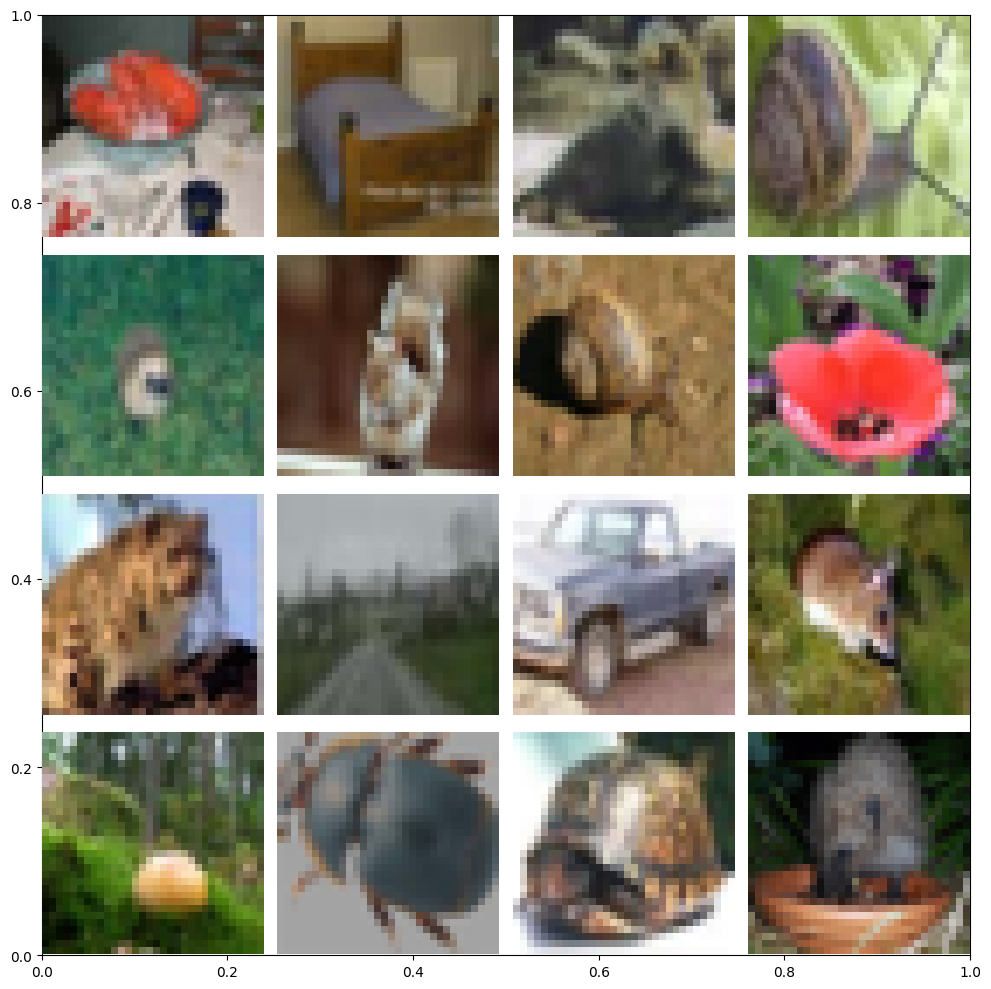

labels[8198].shape: (1,)
imgs[8198].shape: (32, 32, 3)


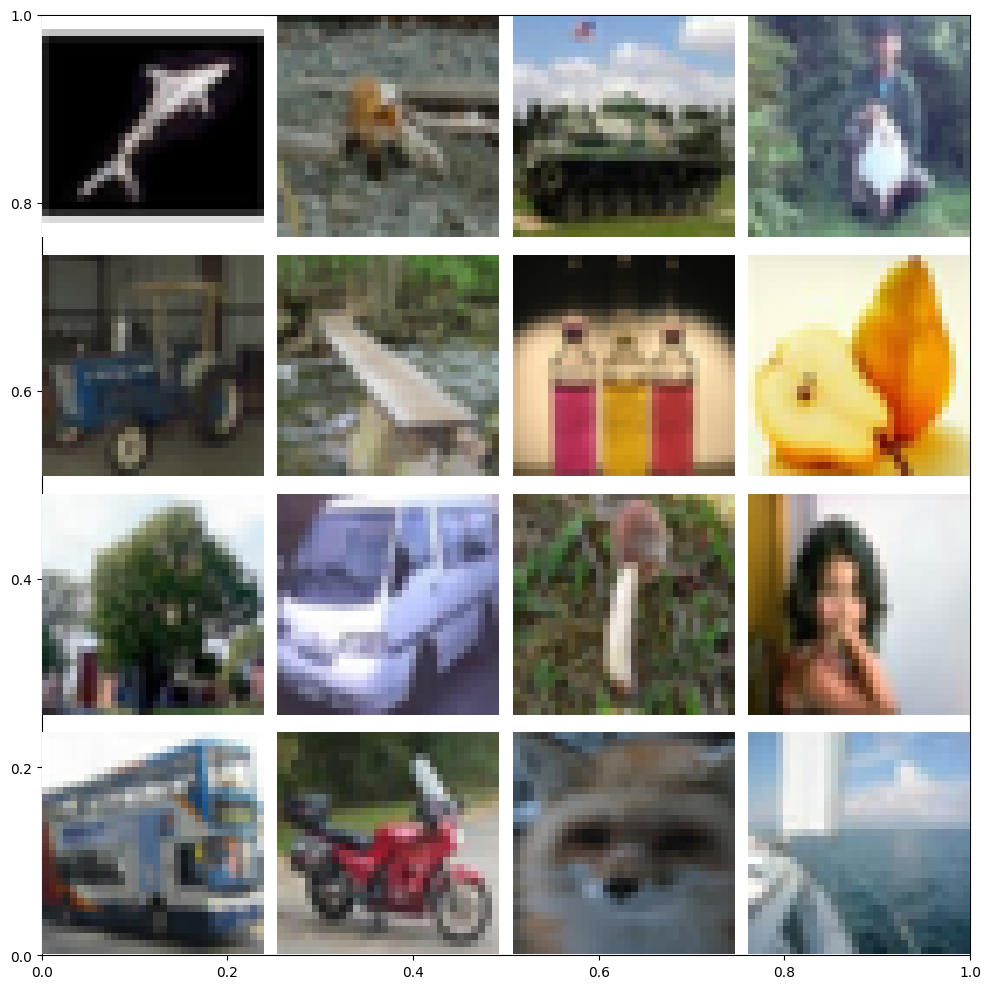

<ipython-input-4-78561581887d>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


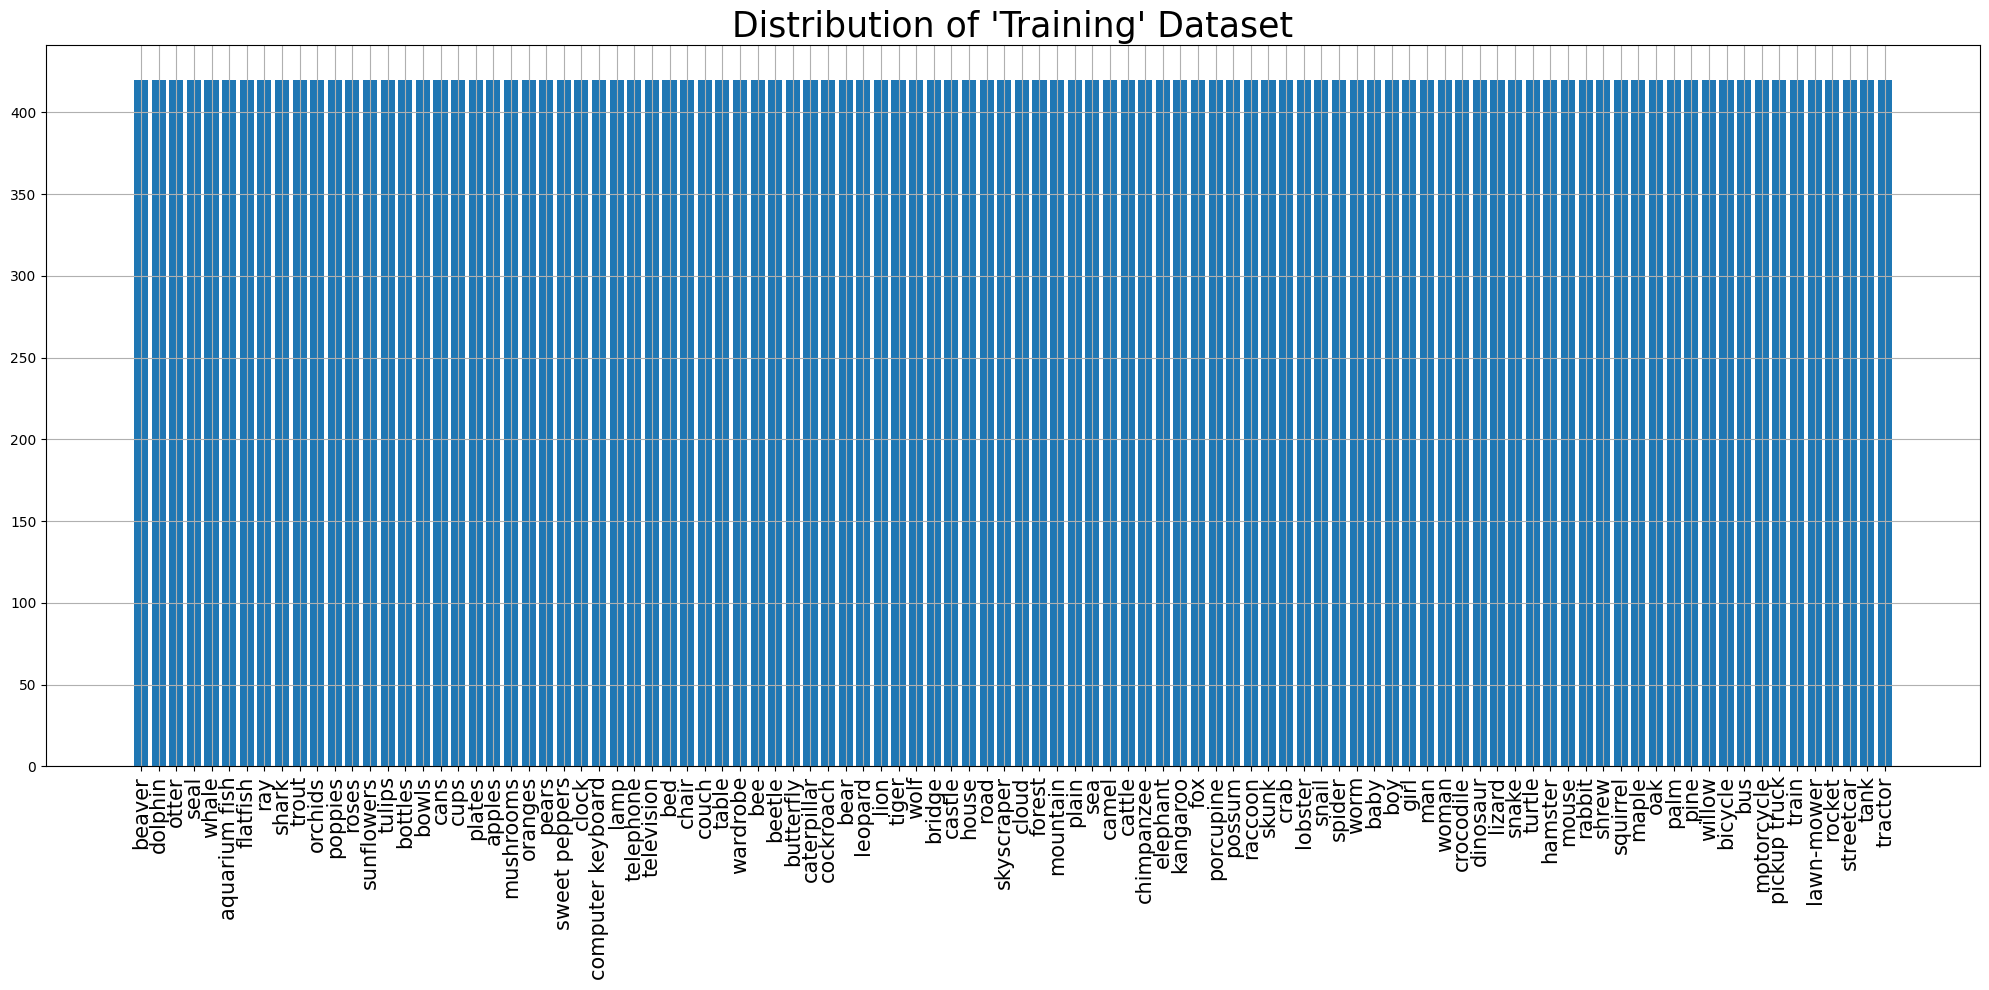

<ipython-input-4-78561581887d>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


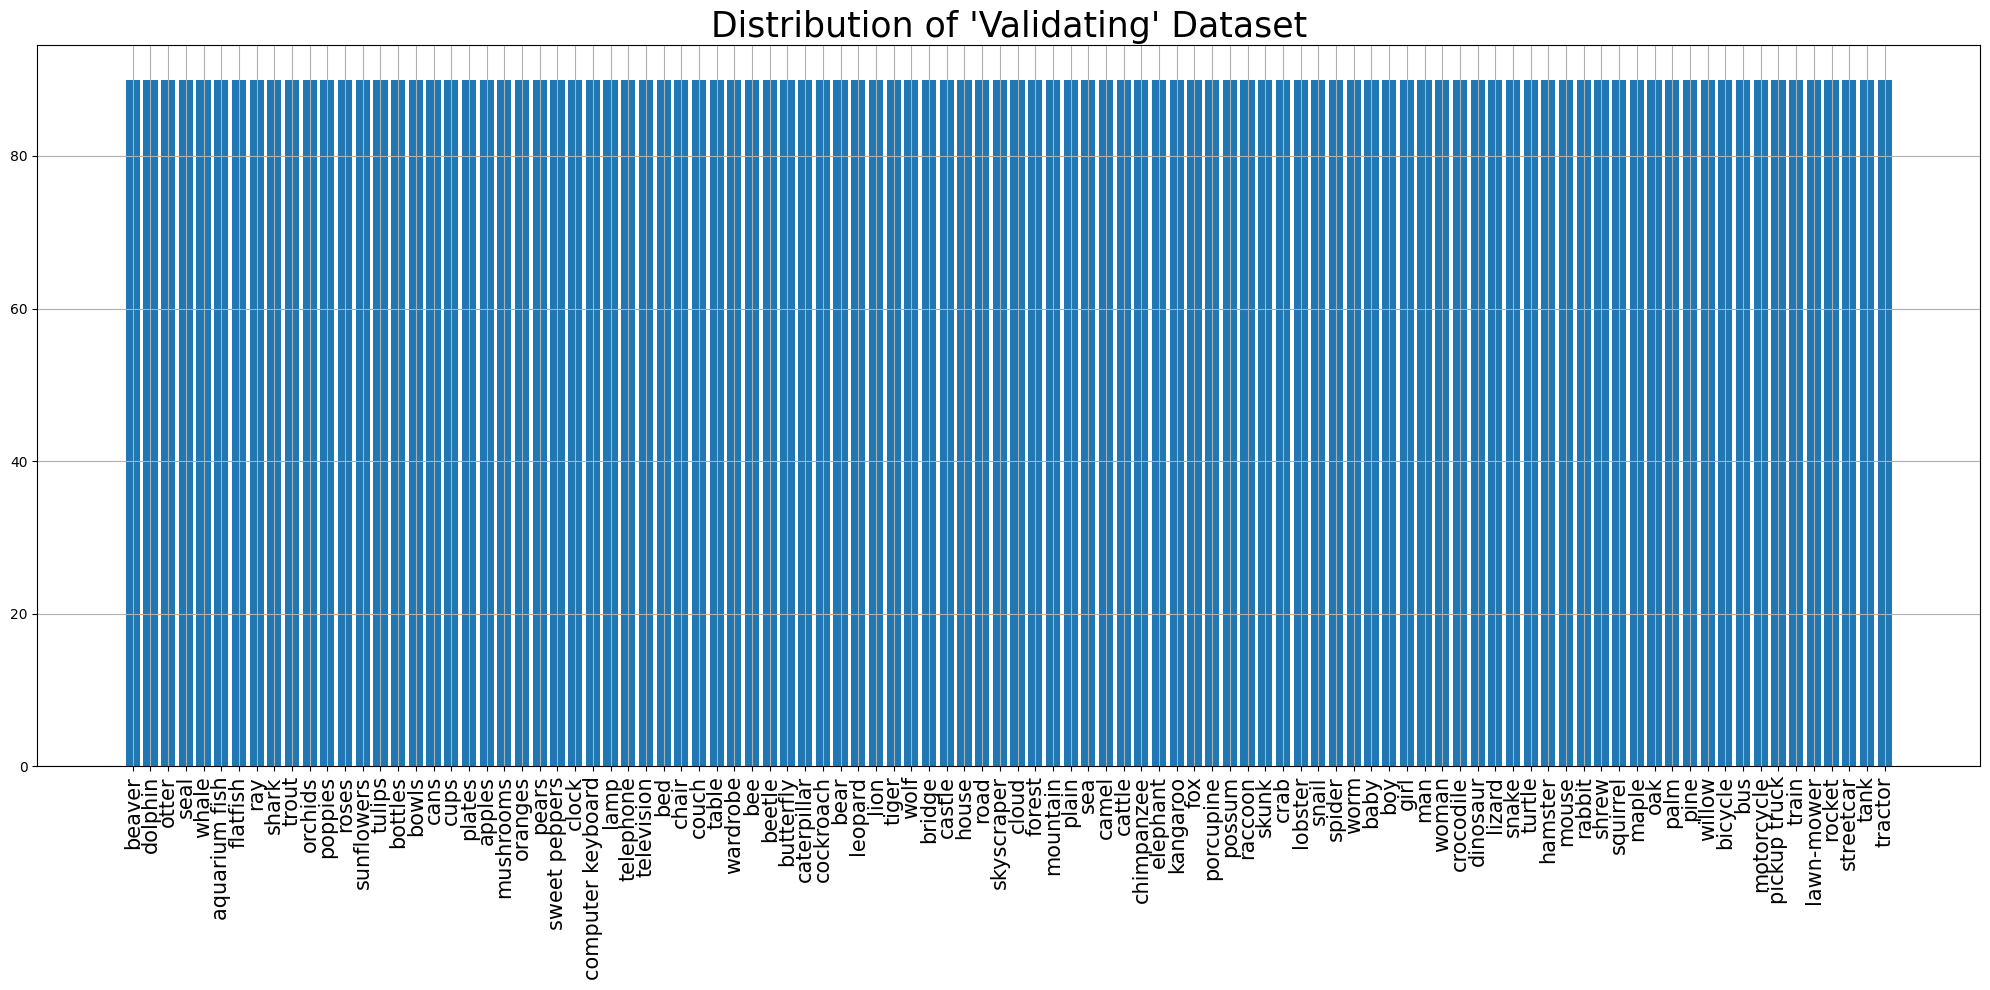

<ipython-input-4-78561581887d>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


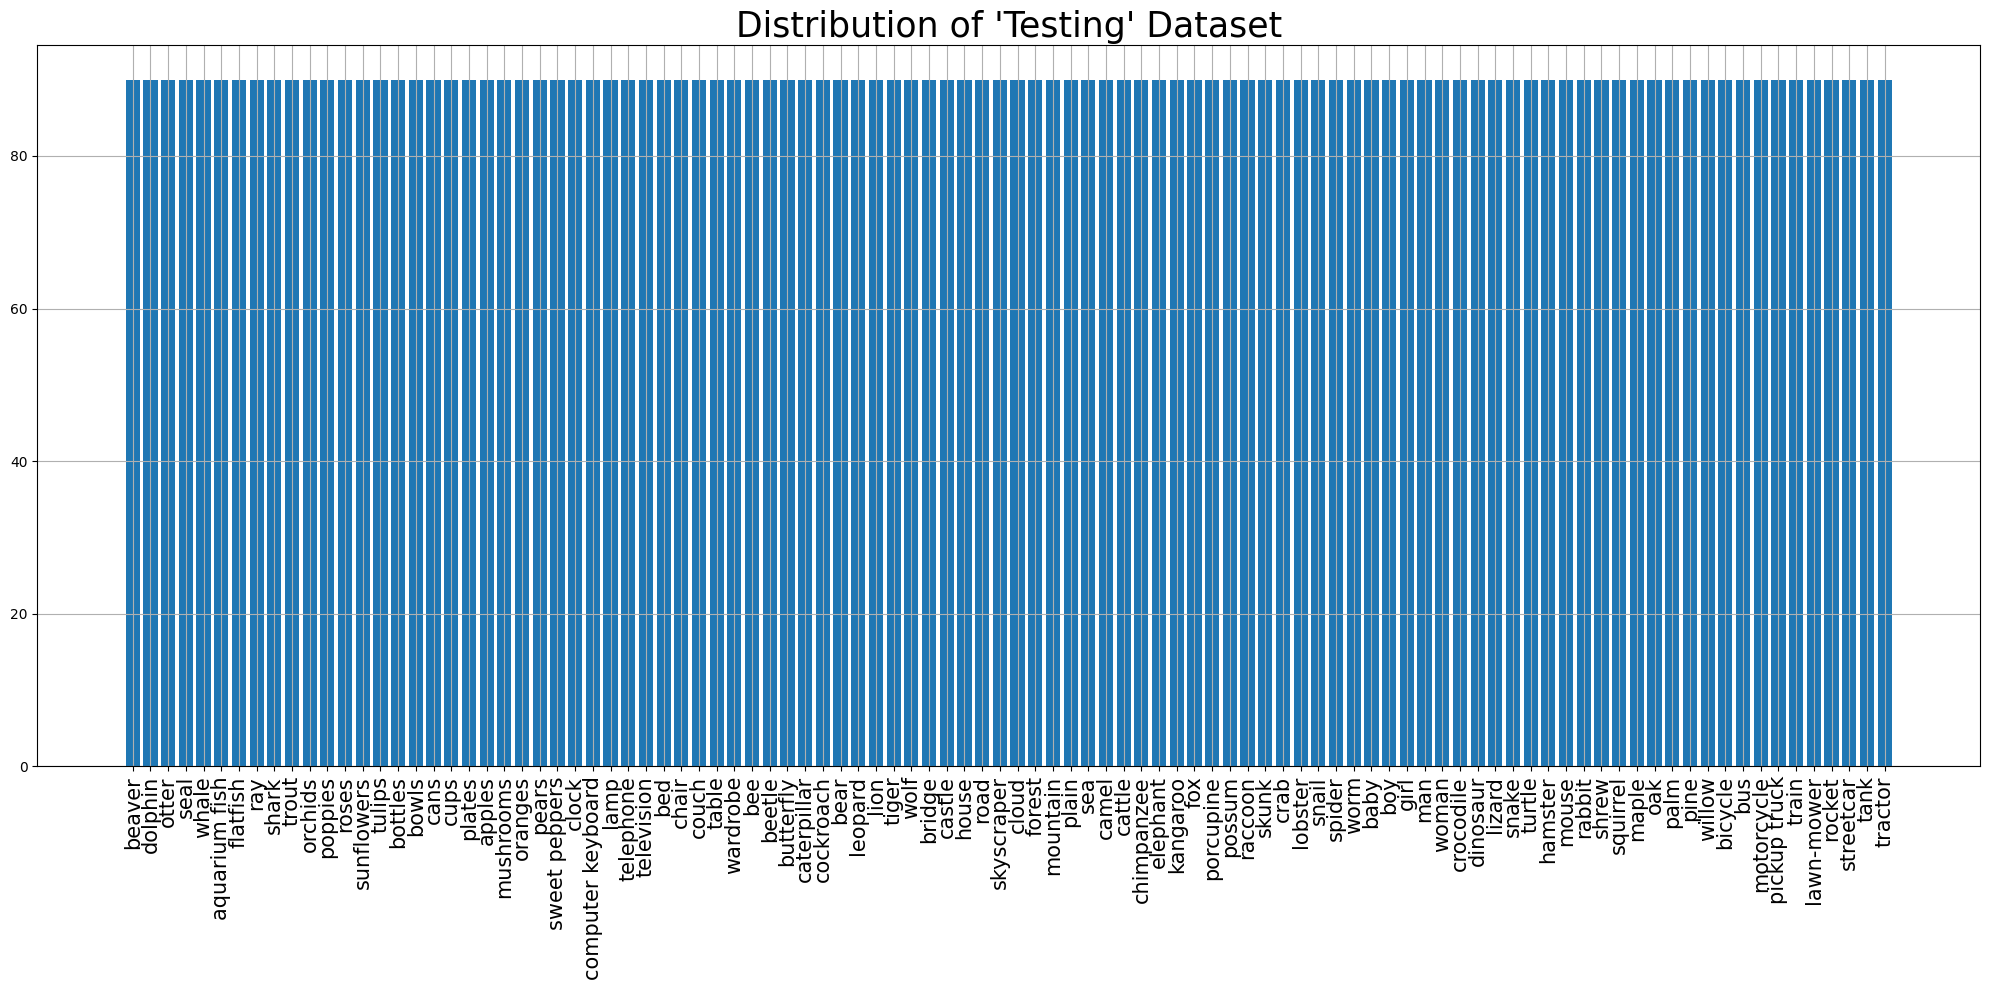

Training dataset:
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)

Validation dataset:
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)

Testing dataset:
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
<class 'tuple'>
2
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
(64, 224, 224, 3)
(64, 100)
Model input shape: (None, 224, 224, 3)
Model output shape: (None, 100)
2
<class 'numpy.nda

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │          51,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,665,188 (94.09 MB)

 Trainable params: 1,100,388 (4.20 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/25
657/657 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3163 - f1_score: 0.3101 - loss: 2.9066 - precision: 0.6639
Epoch 1: val_loss improved from inf to 1.51737, saving model to best_model_v1.keras
657/657 ━━━━━━━━━━━━━━━━━━━━ 57s 58ms/step - accuracy: 0.3165 - f1_score: 0.3102 - loss: 2.9057 - precision: 0.6640 - val_accuracy: 0.5844 - val_f1_score: 0.5802 - val_loss: 1.5174 - val_precision: 0.8125
Epoch 2/25
656/657 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5261 - f1_score: 0.5223 - loss: 1.7312 - precision: 0.7454
Epoch 2: val_loss improved from 1.51737 to 1.40464, saving model to best_model_v1.keras
657/657 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.5262 - f1_score: 0.5223 - loss: 1.7310 - precision: 0.7454 - val_accuracy: 0.6093 - val_f1_score: 0.6047 - val_loss: 1.4046 - val_precision: 0.8088
Epoch 3/25
657/657 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5688 - f1_score: 0.5650 - loss: 1.5514 - precision: 0.7661
Epoch 3: val_loss improved from 1.40464 

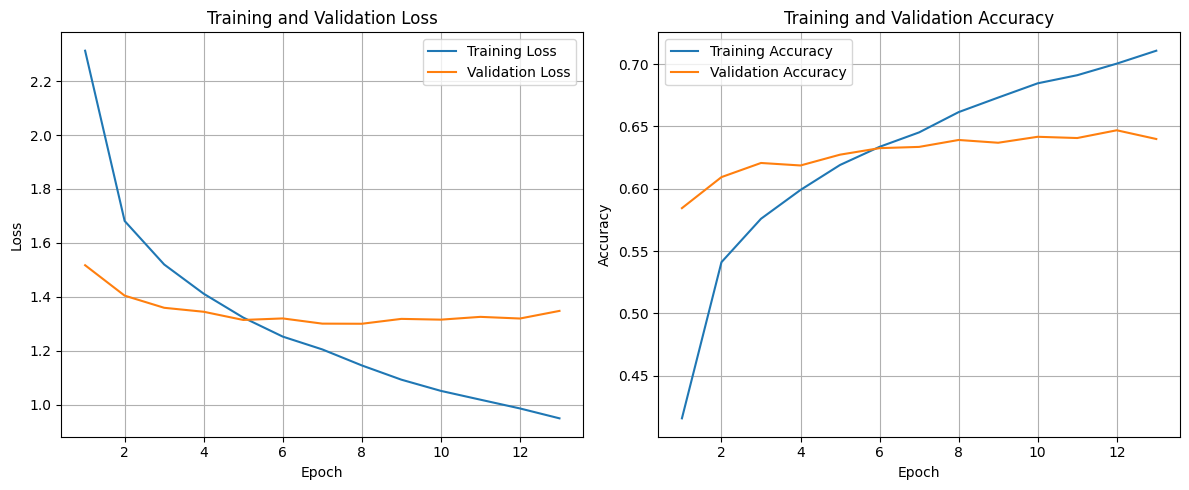

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.6264 - f1_score: 0.6223 - loss: 1.3287 - precision: 0.7795
Test Accuracy: 63.61%
Test Loss: 1.2964630126953125
Test Precision: 78.85%
Test F1 Scores (Per Class): [83.33333  79.12087  48.36601  45.0867   30.555552 67.04545  62.105255
 59.030838 78.61271  79.38144  59.886997 46.39175  65.8385   49.765247
 60.773476 57.731956 77.09496  77.27273  60.33519  58.69565  80.459755
 76.40449  79.329605 77.27273  76.300575 63.04347  51.6129   44.171776
 78.88888  63.855415 60.52631  67.796616 48.520706 51.101315 64.13043
 32.584263 70.329666 58.20105  51.94805  87.86127  72.18934  84.32432
 58.741253 69.047615 50.53763  38.15789  49.777775 52.991444 78.49462
 81.17647  38.260864 71.26436  63.157898 88.2353   68.852455 36.756752
 79.09604  70.35175  72.97298  53.08641  76.82927  74.19354  61.9883
 66.66666  42.335762 52.564095 64.70587  55.3398   88.52458  84.74575
 62.427734 71.962616 39.999996 59.016384 34.11764  81.31868  83.76962
 57.627

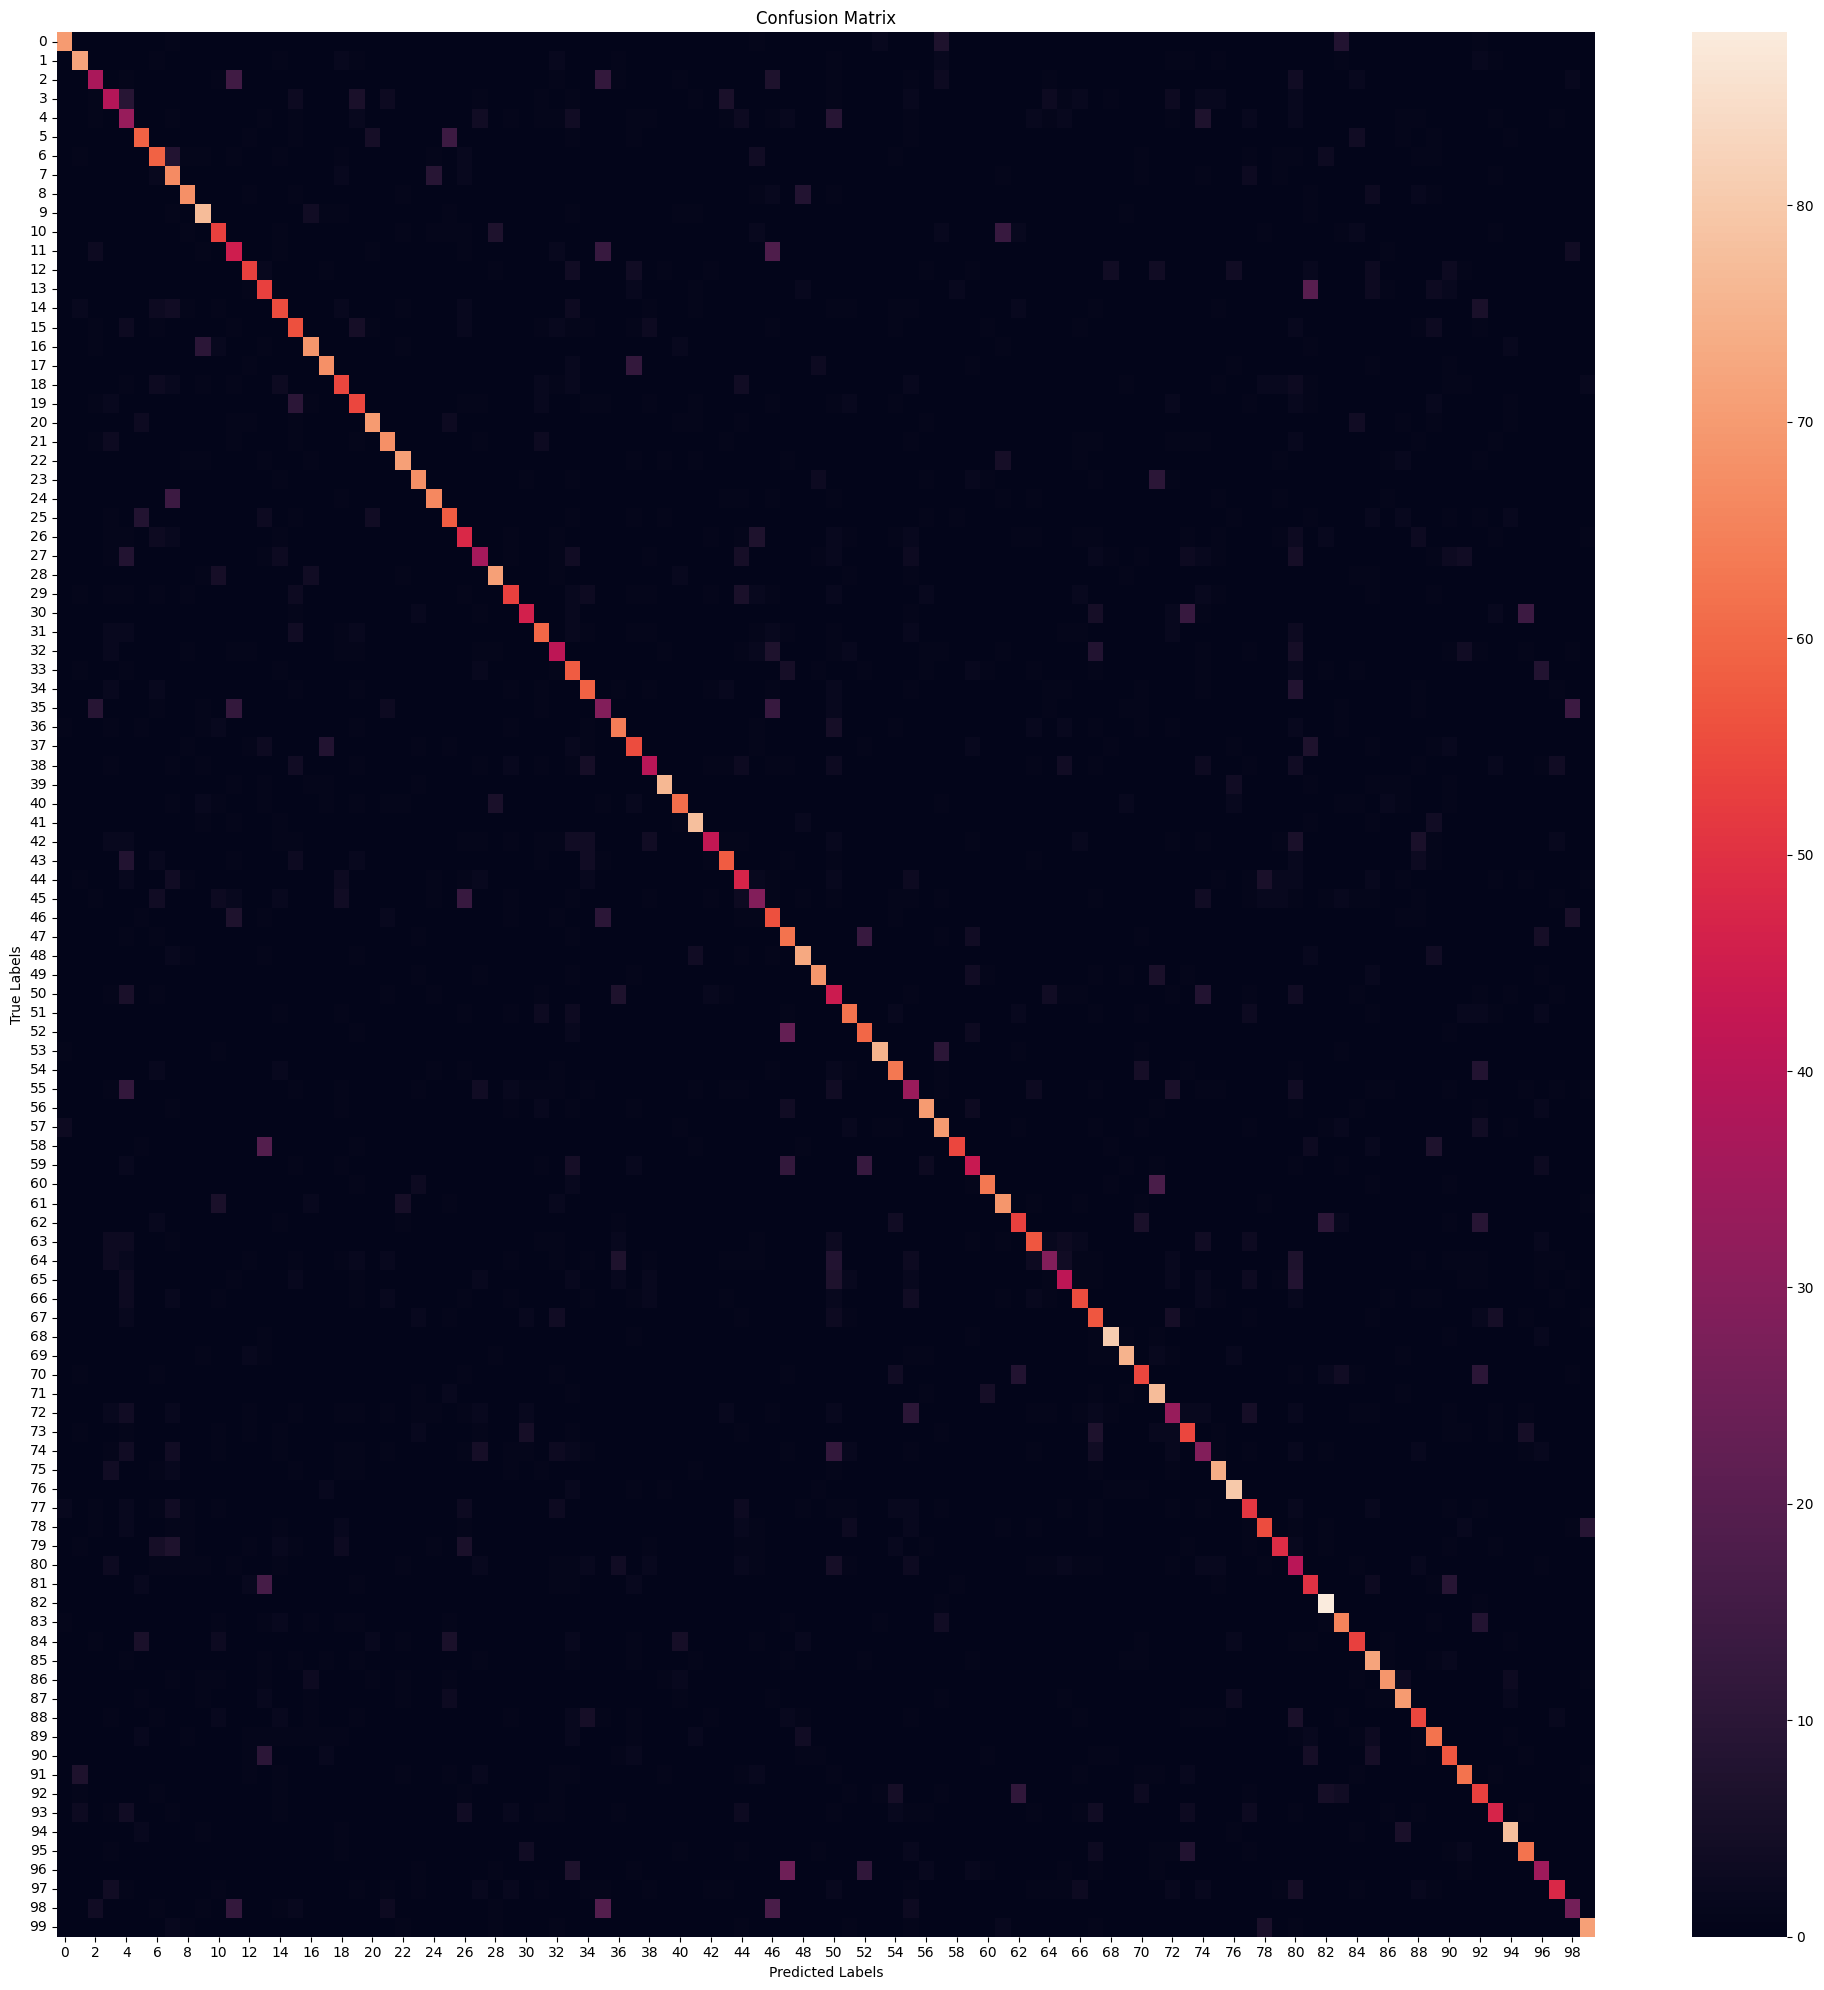

                   precision    recall  f1-score   support

           beaver       0.90      0.78      0.83        90
          dolphin       0.78      0.80      0.79        90
            otter       0.59      0.41      0.48        90
             seal       0.47      0.43      0.45        90
            whale       0.26      0.37      0.31        90
    aquarium fish       0.69      0.66      0.67        90
         flatfish       0.59      0.66      0.62        90
              ray       0.49      0.74      0.59        90
            shark       0.82      0.76      0.79        90
            trout       0.74      0.86      0.79        90
          orchids       0.61      0.59      0.60        90
          poppies       0.43      0.50      0.46        90
            roses       0.75      0.59      0.66        90
       sunflowers       0.43      0.59      0.50        90
           tulips       0.60      0.61      0.61        90
          bottles       0.54      0.62      0.58       

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │          51,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,665,188 (94.09 MB)

 Trainable params: 1,100,388 (4.20 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/15
1313/1314 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6793 - f1_score: 0.6779 - loss: 1.0716 - precision: 0.8211
Epoch 1: val_loss improved from inf to 1.25322, saving model to best_model_fine_tune_v1.keras
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 57s 35ms/step - accuracy: 0.6793 - f1_score: 0.6779 - loss: 1.0716 - precision: 0.8211 - val_accuracy: 0.6526 - val_f1_score: 0.6520 - val_loss: 1.2532 - val_precision: 0.7981
Epoch 2/15
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7028 - f1_score: 0.7014 - loss: 0.9859 - precision: 0.8391
Epoch 2: val_loss improved from 1.25322 to 1.24656, saving model to best_model_fine_tune_v1.keras
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 36s 27ms/step - accuracy: 0.7028 - f1_score: 0.7013 - loss: 0.9859 - precision: 0.8391 - val_accuracy: 0.6550 - val_f1_score: 0.6544 - val_loss: 1.2466 - val_precision: 0.7967
Epoch 3/15
1312/1314 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7128 - f1_score: 0.7110 - loss: 0.9560 - precision: 0.8423
Epoch 3: v

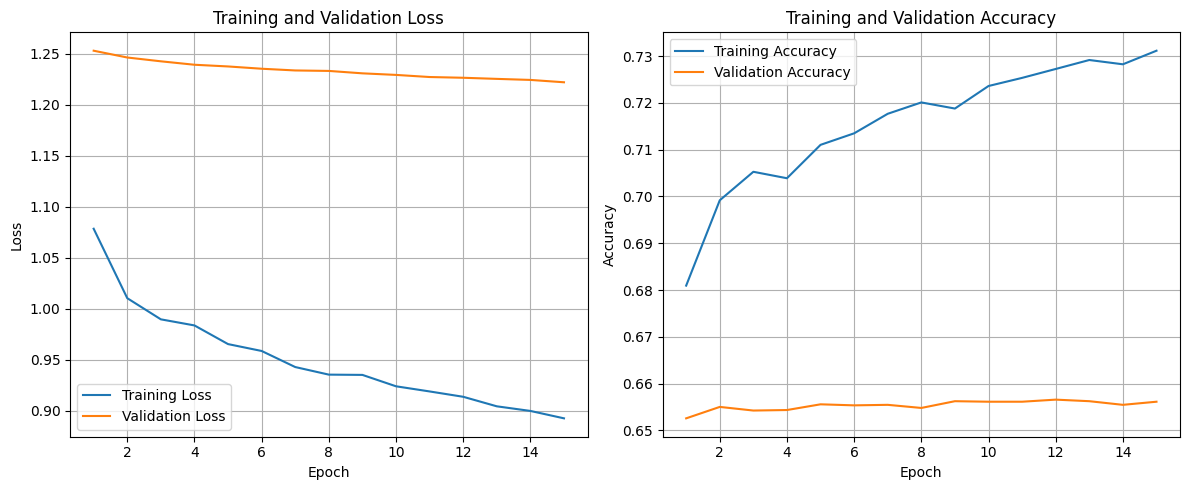

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.6513 - f1_score: 0.6443 - loss: 1.2445 - precision: 0.7985
Test Accuracy: 66.03%
Test Loss: 1.2187669277191162
Test Precision: 80.41%
Test F1 Scores (Per Class): [85.08286  80.87432  54.838707 49.999992 37.433147 71.1111   57.591618
 68.53932  80.473366 79.31035  62.983418 45.882347 69.41176  58.139526
 66.27907  57.731956 77.48691  75.53191  60.439552 59.880234 81.72042
 76.34408  82.97872  79.09604  79.78141  70.17543  50.53763  45.933006
 77.9661   67.51592  61.6279   71.764694 50.28571  59.18367  67.796616
 32.369934 73.14285  56.989246 49.729725 91.95402  70.588234 83.69564
 64.80447  68.53932  51.041664 44.18604  46.590904 54.32098  80.628265
 82.68156  38.55421  74.03315  64.94845  90.28571  73.09644  39.999996
 80.701744 74.725266 77.8443   56.97674  81.31868  73.56321  63.157898
 65.868256 45.61403  57.142853 62.29508  59.999996 89.01098  83.24323
 63.218384 73.11827  41.420113 61.202175 34.736835 84.44444  84.946236
 62

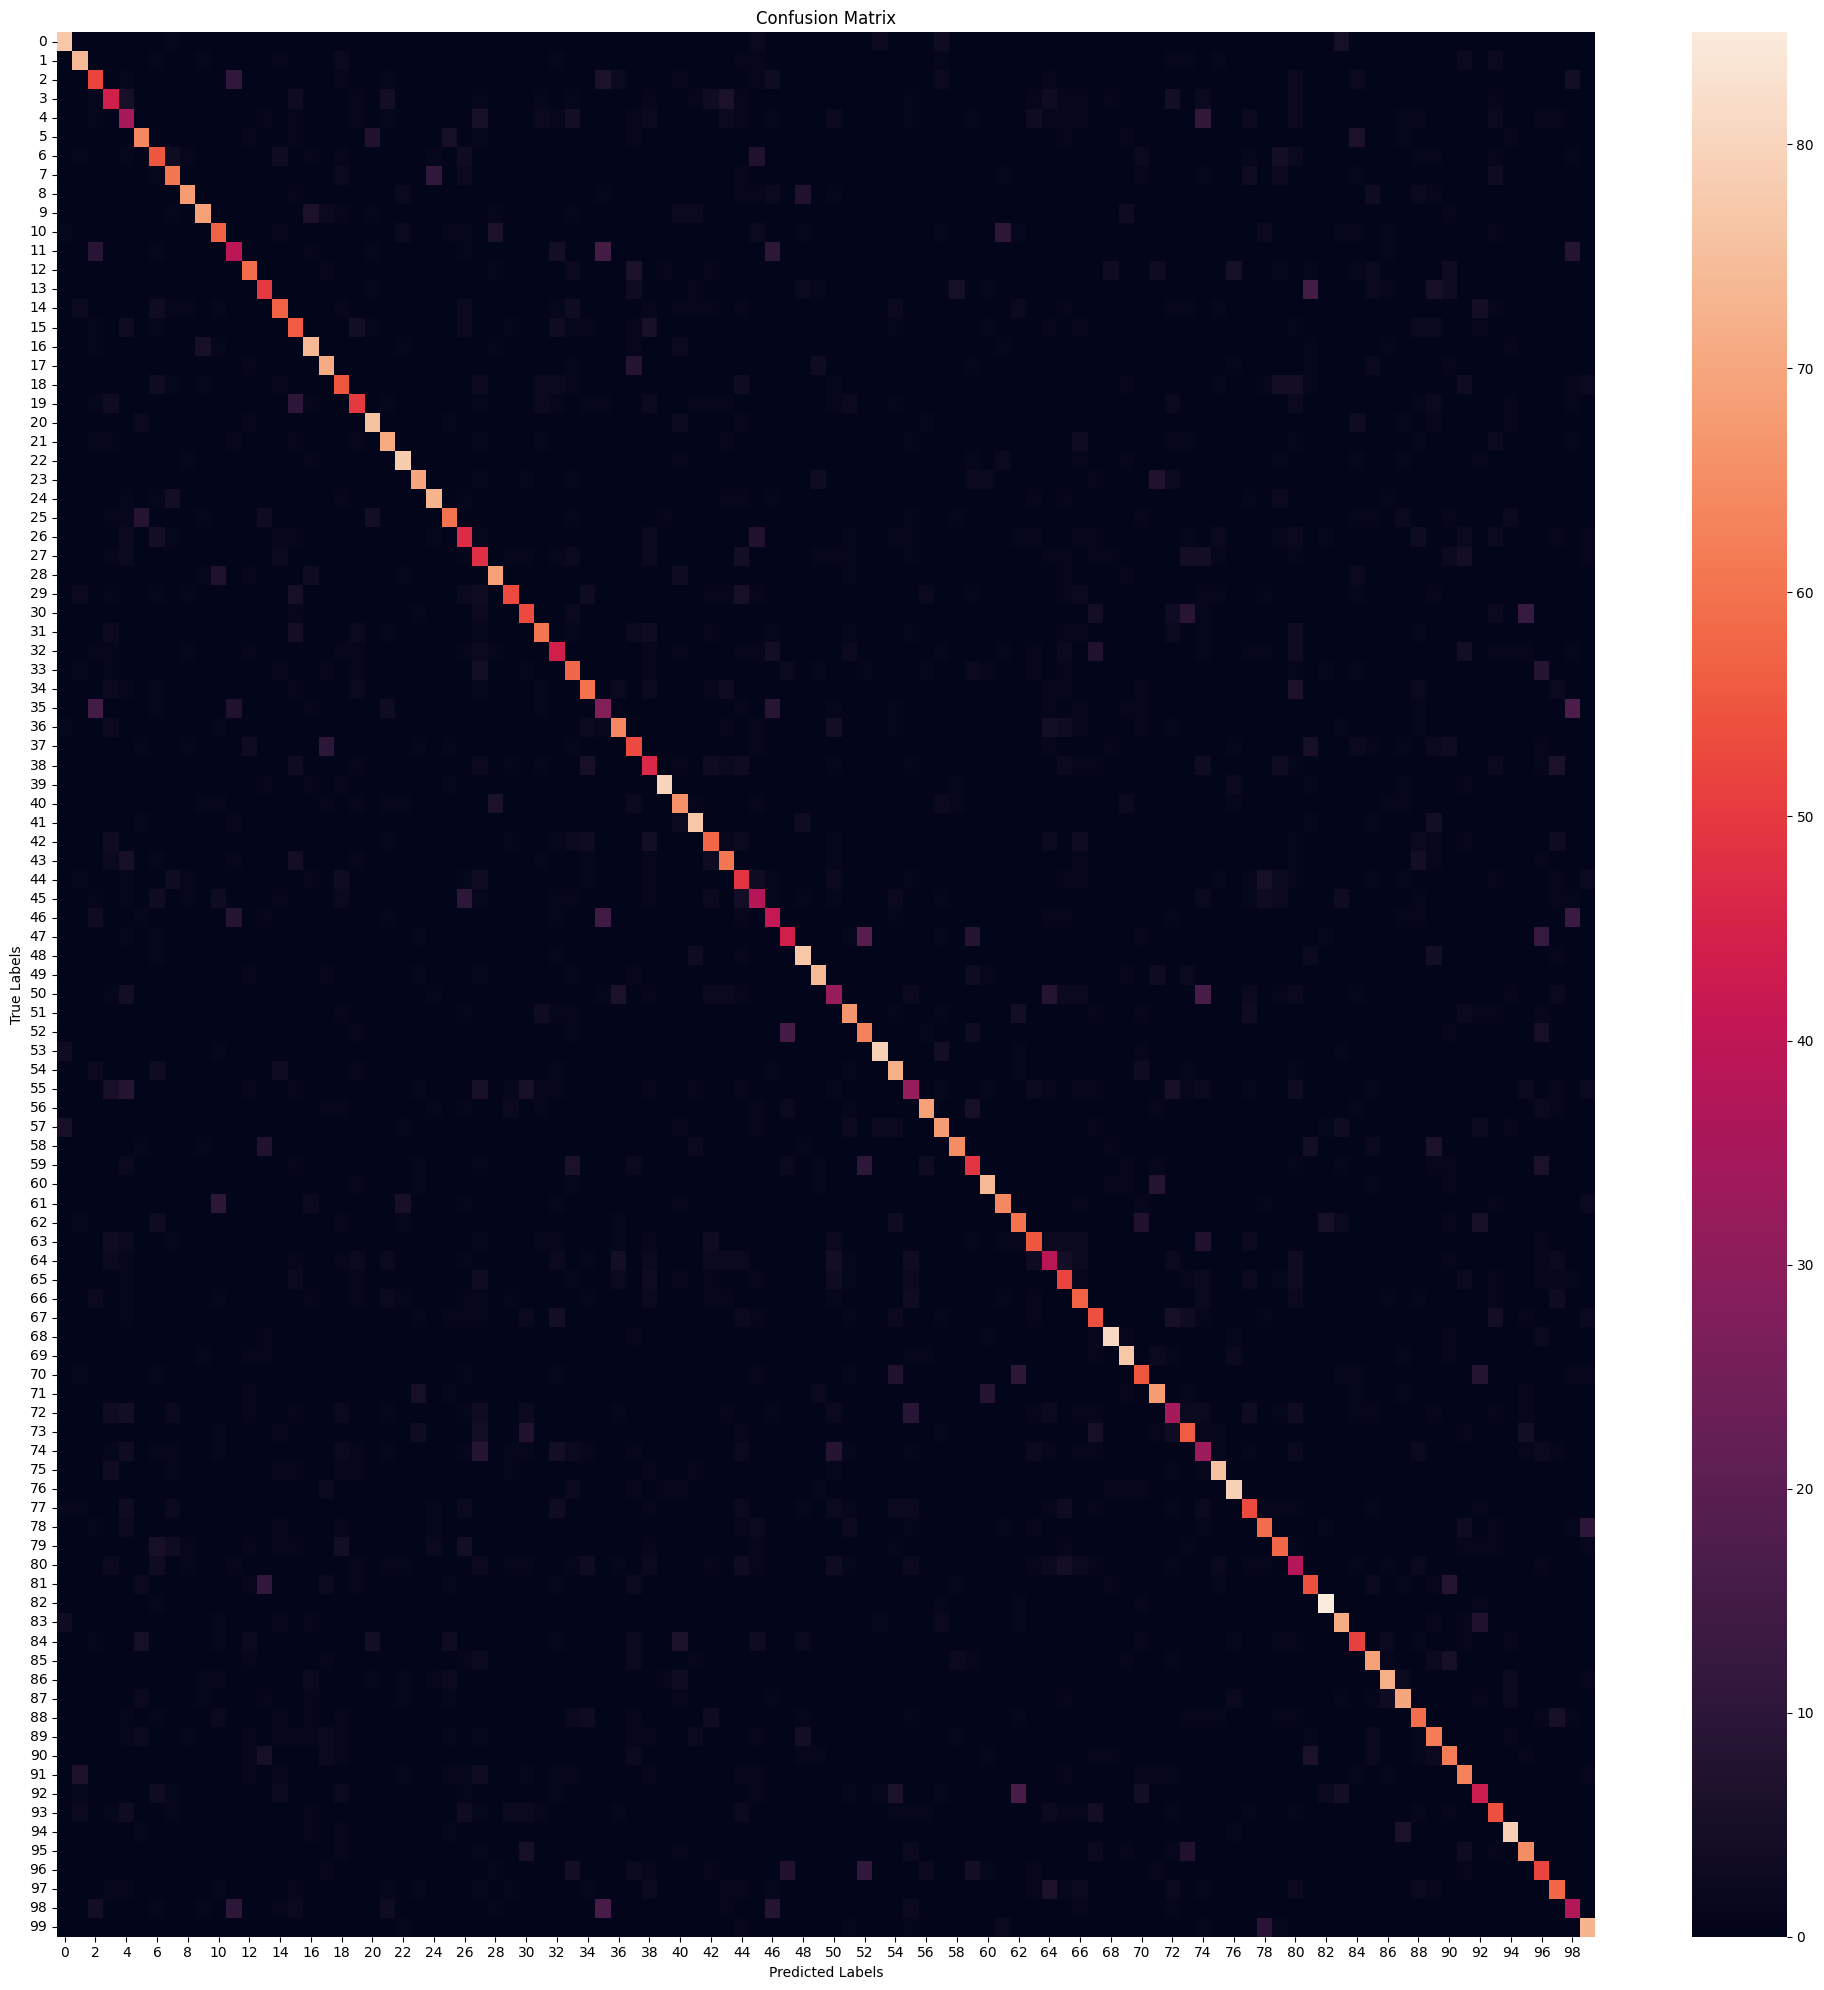

                   precision    recall  f1-score   support

           beaver       0.85      0.86      0.85        90
          dolphin       0.80      0.82      0.81        90
            otter       0.54      0.58      0.56        90
             seal       0.51      0.49      0.50        90
            whale       0.36      0.39      0.37        90
    aquarium fish       0.71      0.71      0.71        90
         flatfish       0.54      0.61      0.58        90
              ray       0.69      0.68      0.69        90
            shark       0.86      0.76      0.80        90
            trout       0.82      0.77      0.79        90
          orchids       0.63      0.63      0.63        90
          poppies       0.49      0.43      0.46        90
            roses       0.74      0.66      0.69        90
       sunflowers       0.61      0.56      0.58        90
           tulips       0.70      0.63      0.66        90
          bottles       0.54      0.62      0.58       

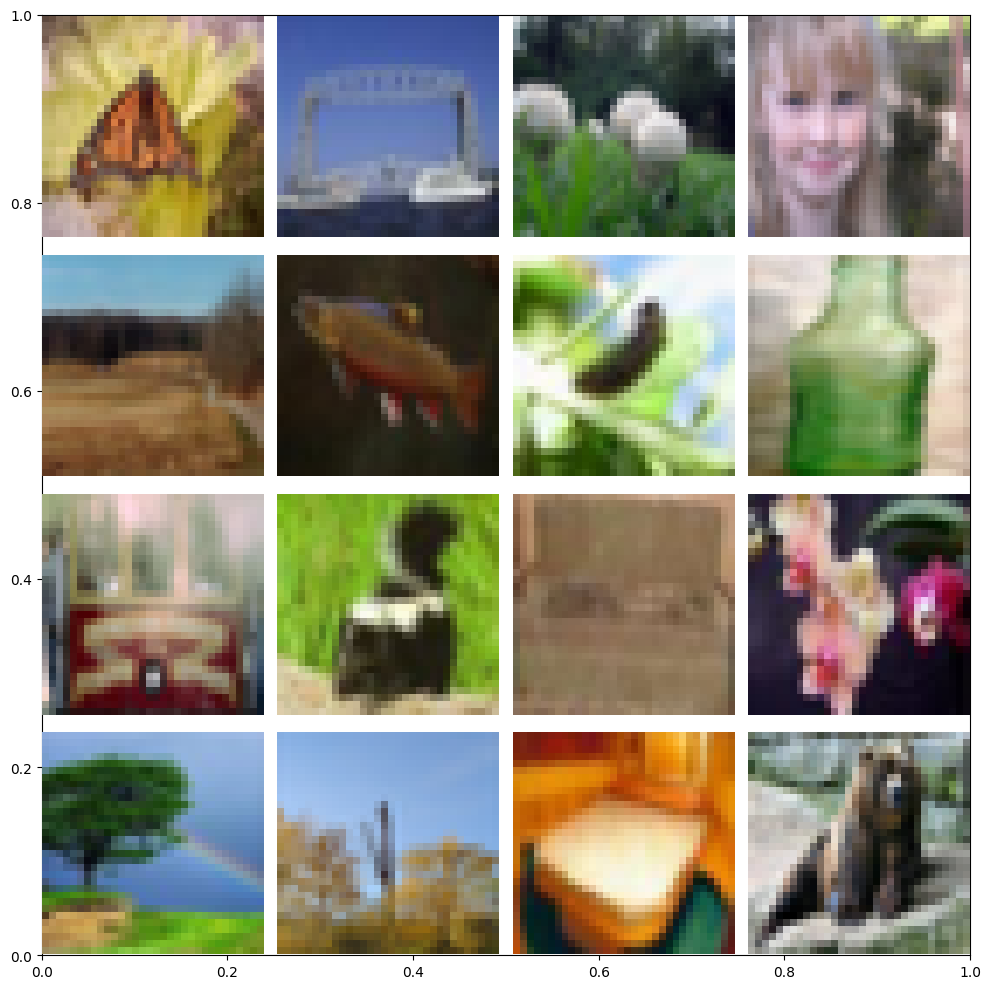

labels[27017].shape: (1,)
imgs[27017].shape: (32, 32, 3)


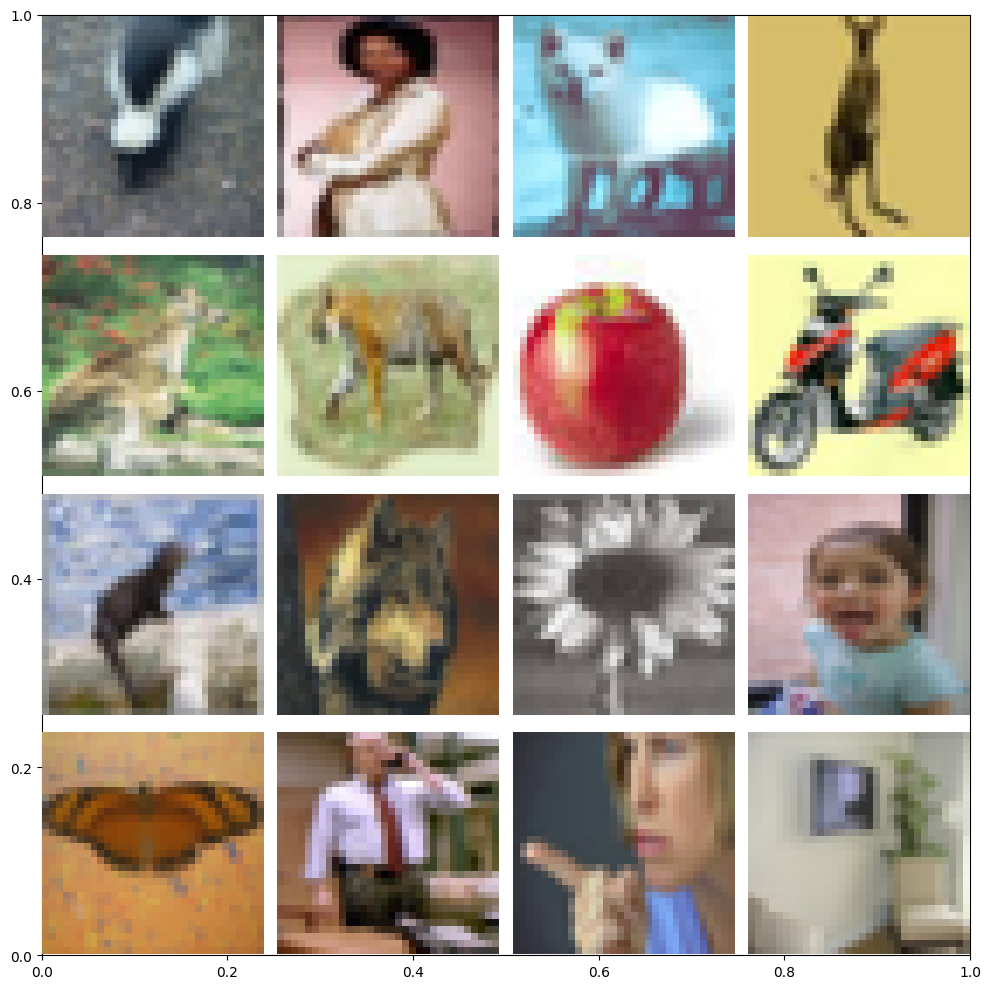

<ipython-input-4-78561581887d>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


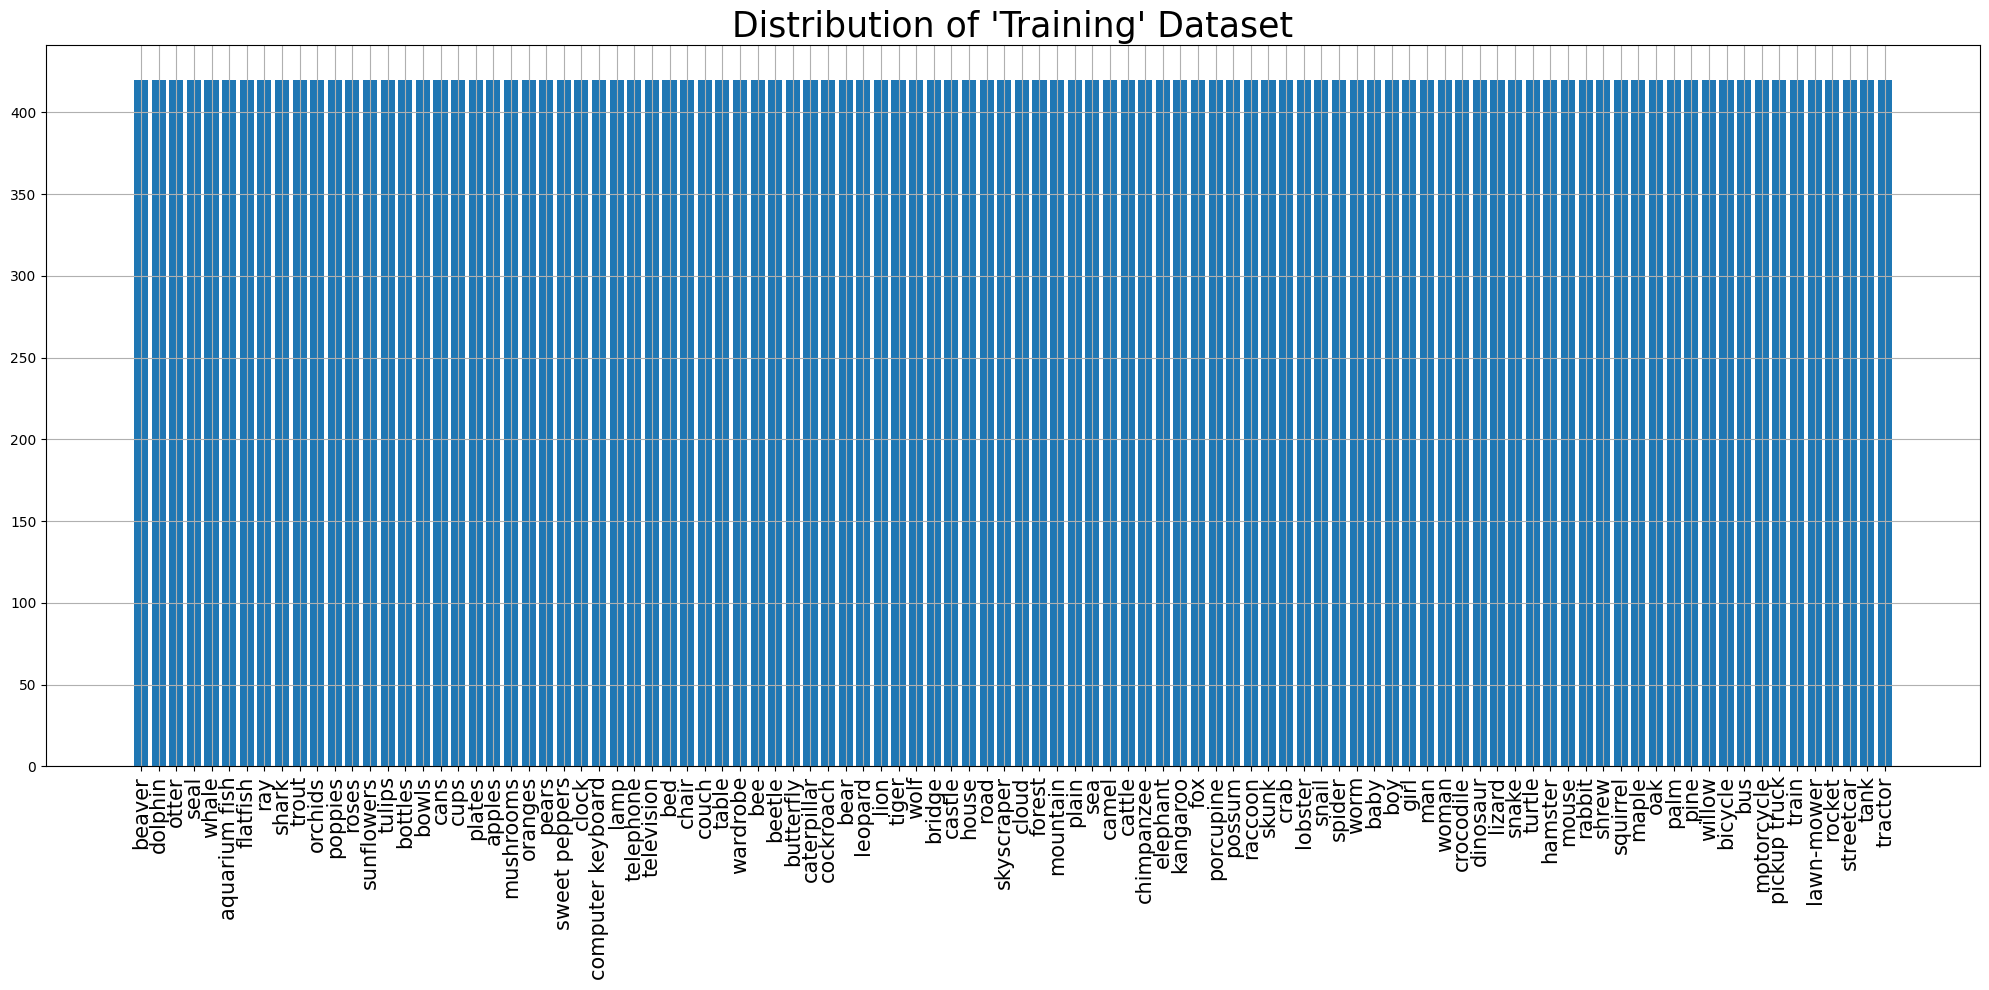

<ipython-input-4-78561581887d>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


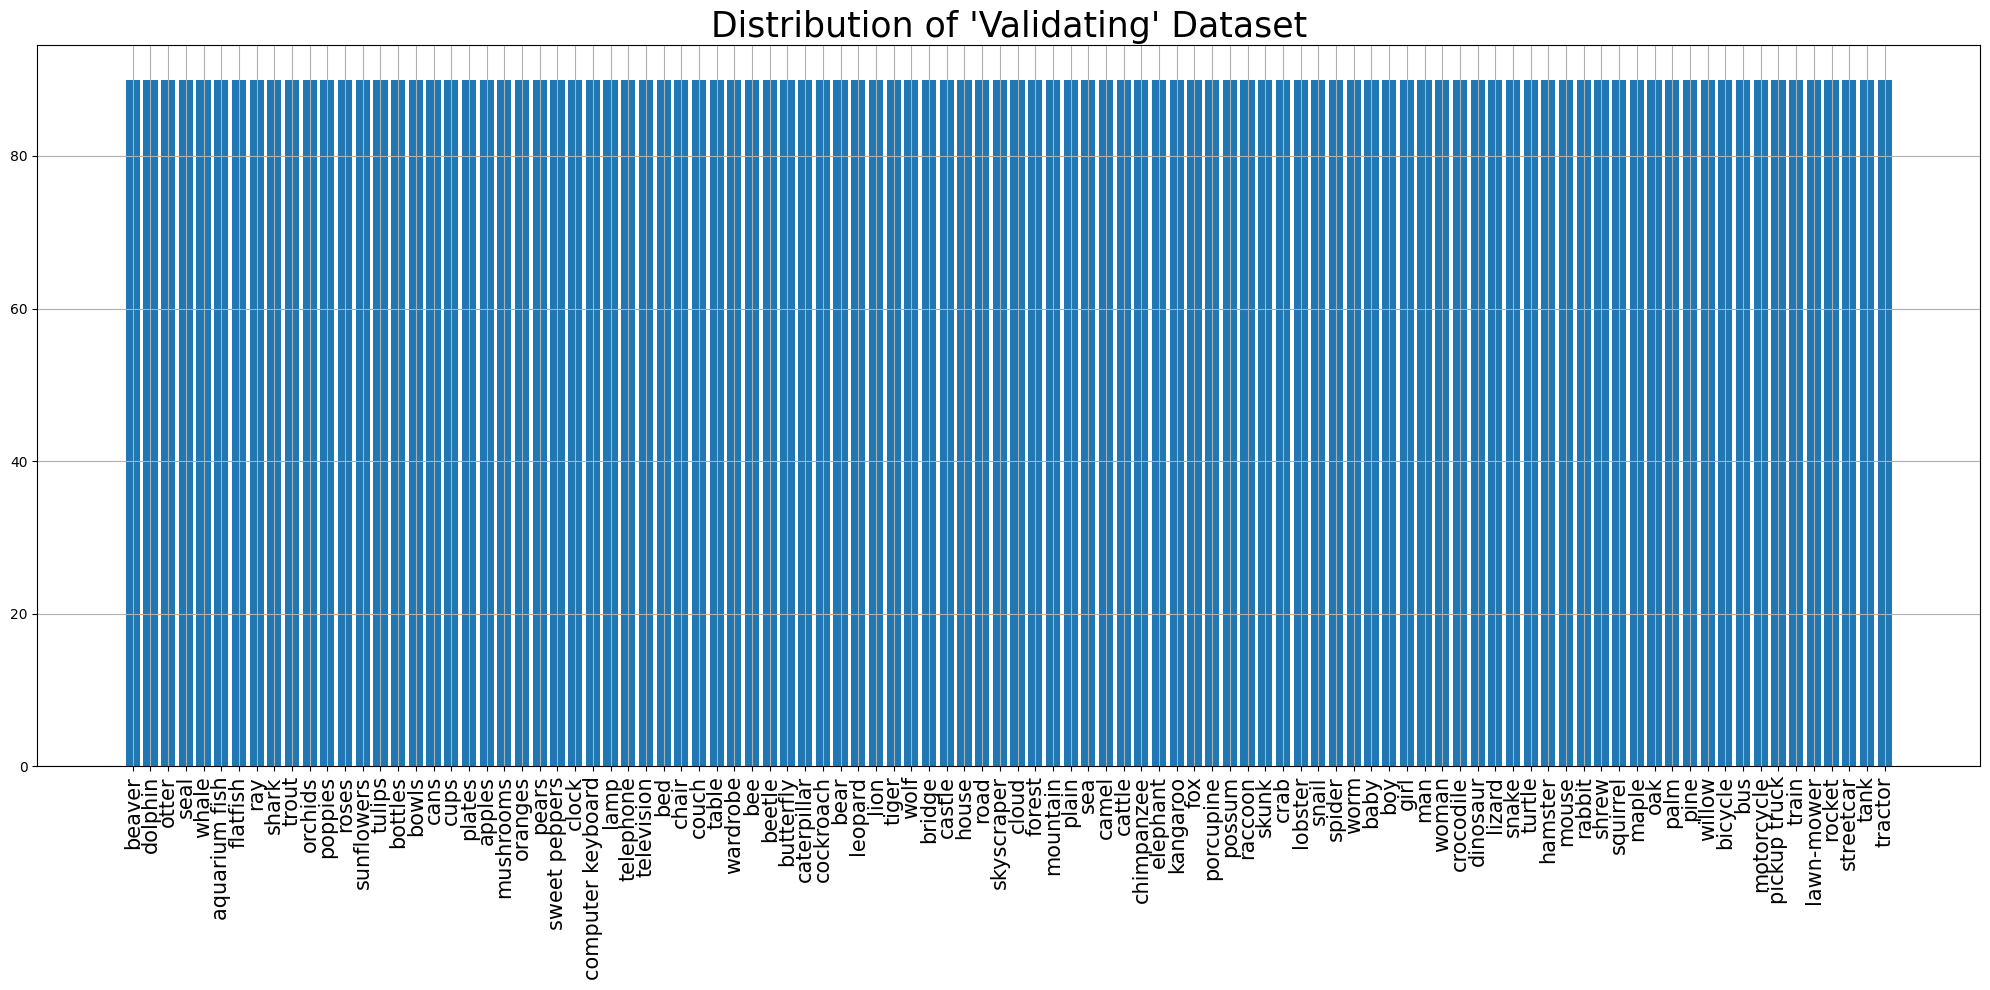

<ipython-input-4-78561581887d>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


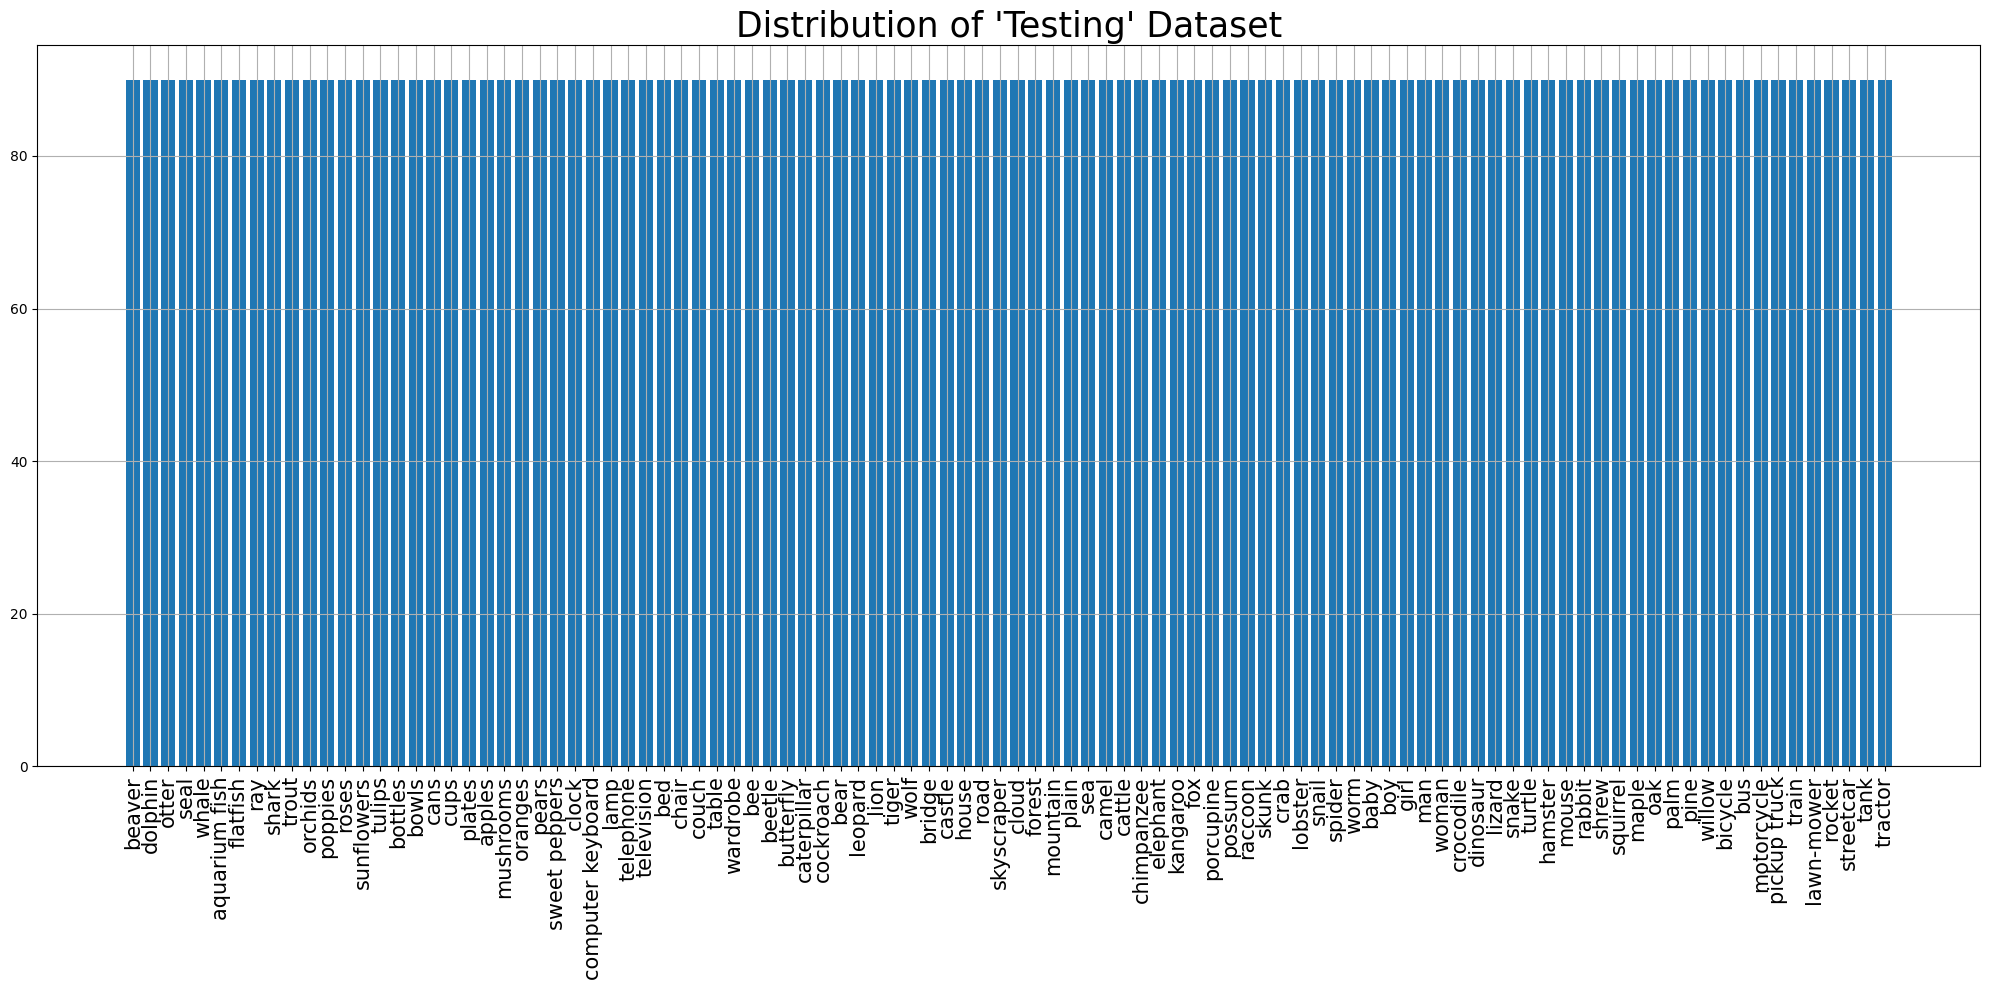

Training dataset:
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)

Validation dataset:
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)

Testing dataset:
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)
<class 'tuple'>
2
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
(64, 224, 224, 3)
(64, 100)
Model input shape: (None, 224, 224, 3)
Model output shape: (None, 100)
2
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(64, 224, 224, 3) (6

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 100)                 │          51,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,665,188 (94.09 MB)

 Trainable params: 1,100,388 (4.20 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/25
657/657 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3139 - f1_score: 0.3082 - loss: 2.9117 - precision: 0.6544
Epoch 1: val_loss improved from inf to 1.49852, saving model to best_model_v1.keras
657/657 ━━━━━━━━━━━━━━━━━━━━ 40s 46ms/step - accuracy: 0.3141 - f1_score: 0.3084 - loss: 2.9108 - precision: 0.6545 - val_accuracy: 0.5829 - val_f1_score: 0.5788 - val_loss: 1.4985 - val_precision: 0.8196
Epoch 2/25
655/657 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5216 - f1_score: 0.5179 - loss: 1.7409 - precision: 0.7447
Epoch 2: val_loss improved from 1.49852 to 1.39130, saving model to best_model_v1.keras
657/657 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.5217 - f1_score: 0.5180 - loss: 1.7406 - precision: 0.7448 - val_accuracy: 0.6111 - val_f1_score: 0.6073 - val_loss: 1.3913 - val_precision: 0.8062
Epoch 3/25
656/657 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5652 - f1_score: 0.5614 - loss: 1.5490 - precision: 0.7578
Epoch 3: val_loss improved from 1.39130 

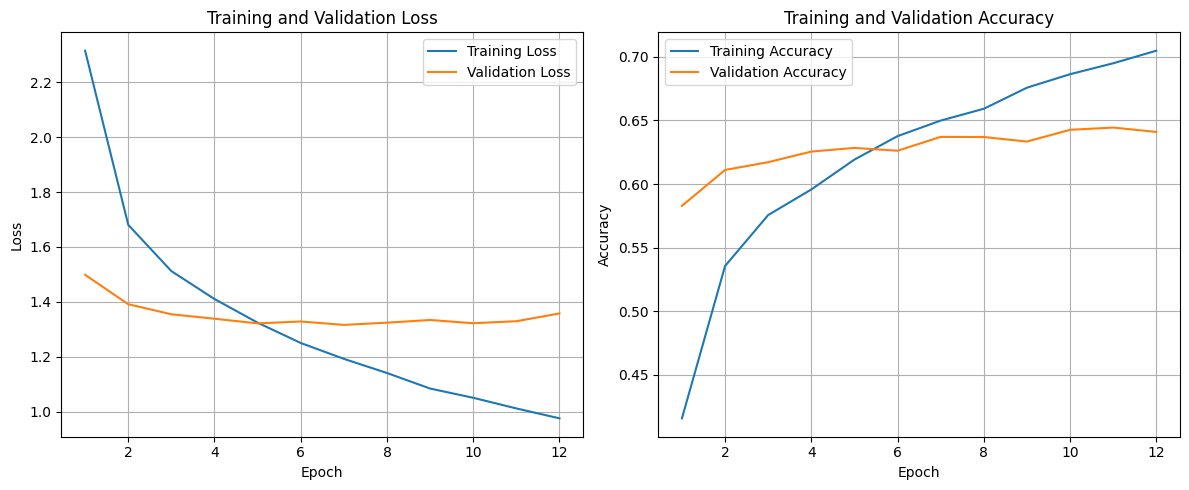

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.6268 - f1_score: 0.6216 - loss: 1.3299 - precision: 0.7835
Test Accuracy: 63.76%
Test Loss: 1.3040658235549927
Test Precision: 78.92%
Test F1 Scores (Per Class): [80.92485  74.99999  56.28742  39.72602  29.729725 66.666664 63.414627
 65.97938  77.71428  84.02366  63.803684 39.58333  63.5838   59.40594
 65.088745 56.25     78.172585 73.91304  58.653843 61.90476  82.22221
 79.768776 78.85714  77.9661   76.34408  60.869564 48.623848 51.308887
 77.09496  62.025307 59.459454 64.55026  50.32258  50.220257 61.956512
 29.230764 67.0391   52.427177 48.19277  90.05848  72.72727  81.28342
 62.576683 71.00591  42.553185 46.15384  44.14414  49.999992 80.41236
 80.43478  38.05309  72.093025 63.82978  88.372086 71.8232   29.870125
 81.707306 69.99999  77.707    49.999992 74.69879  73.11827  62.63736
 63.09523  47.43589  52.439022 60.869564 56.25     81.6568   83.63635
 67.42856  71.57894  34.17721  64.70587  38.341965 76.8421   76.69902
 61.538

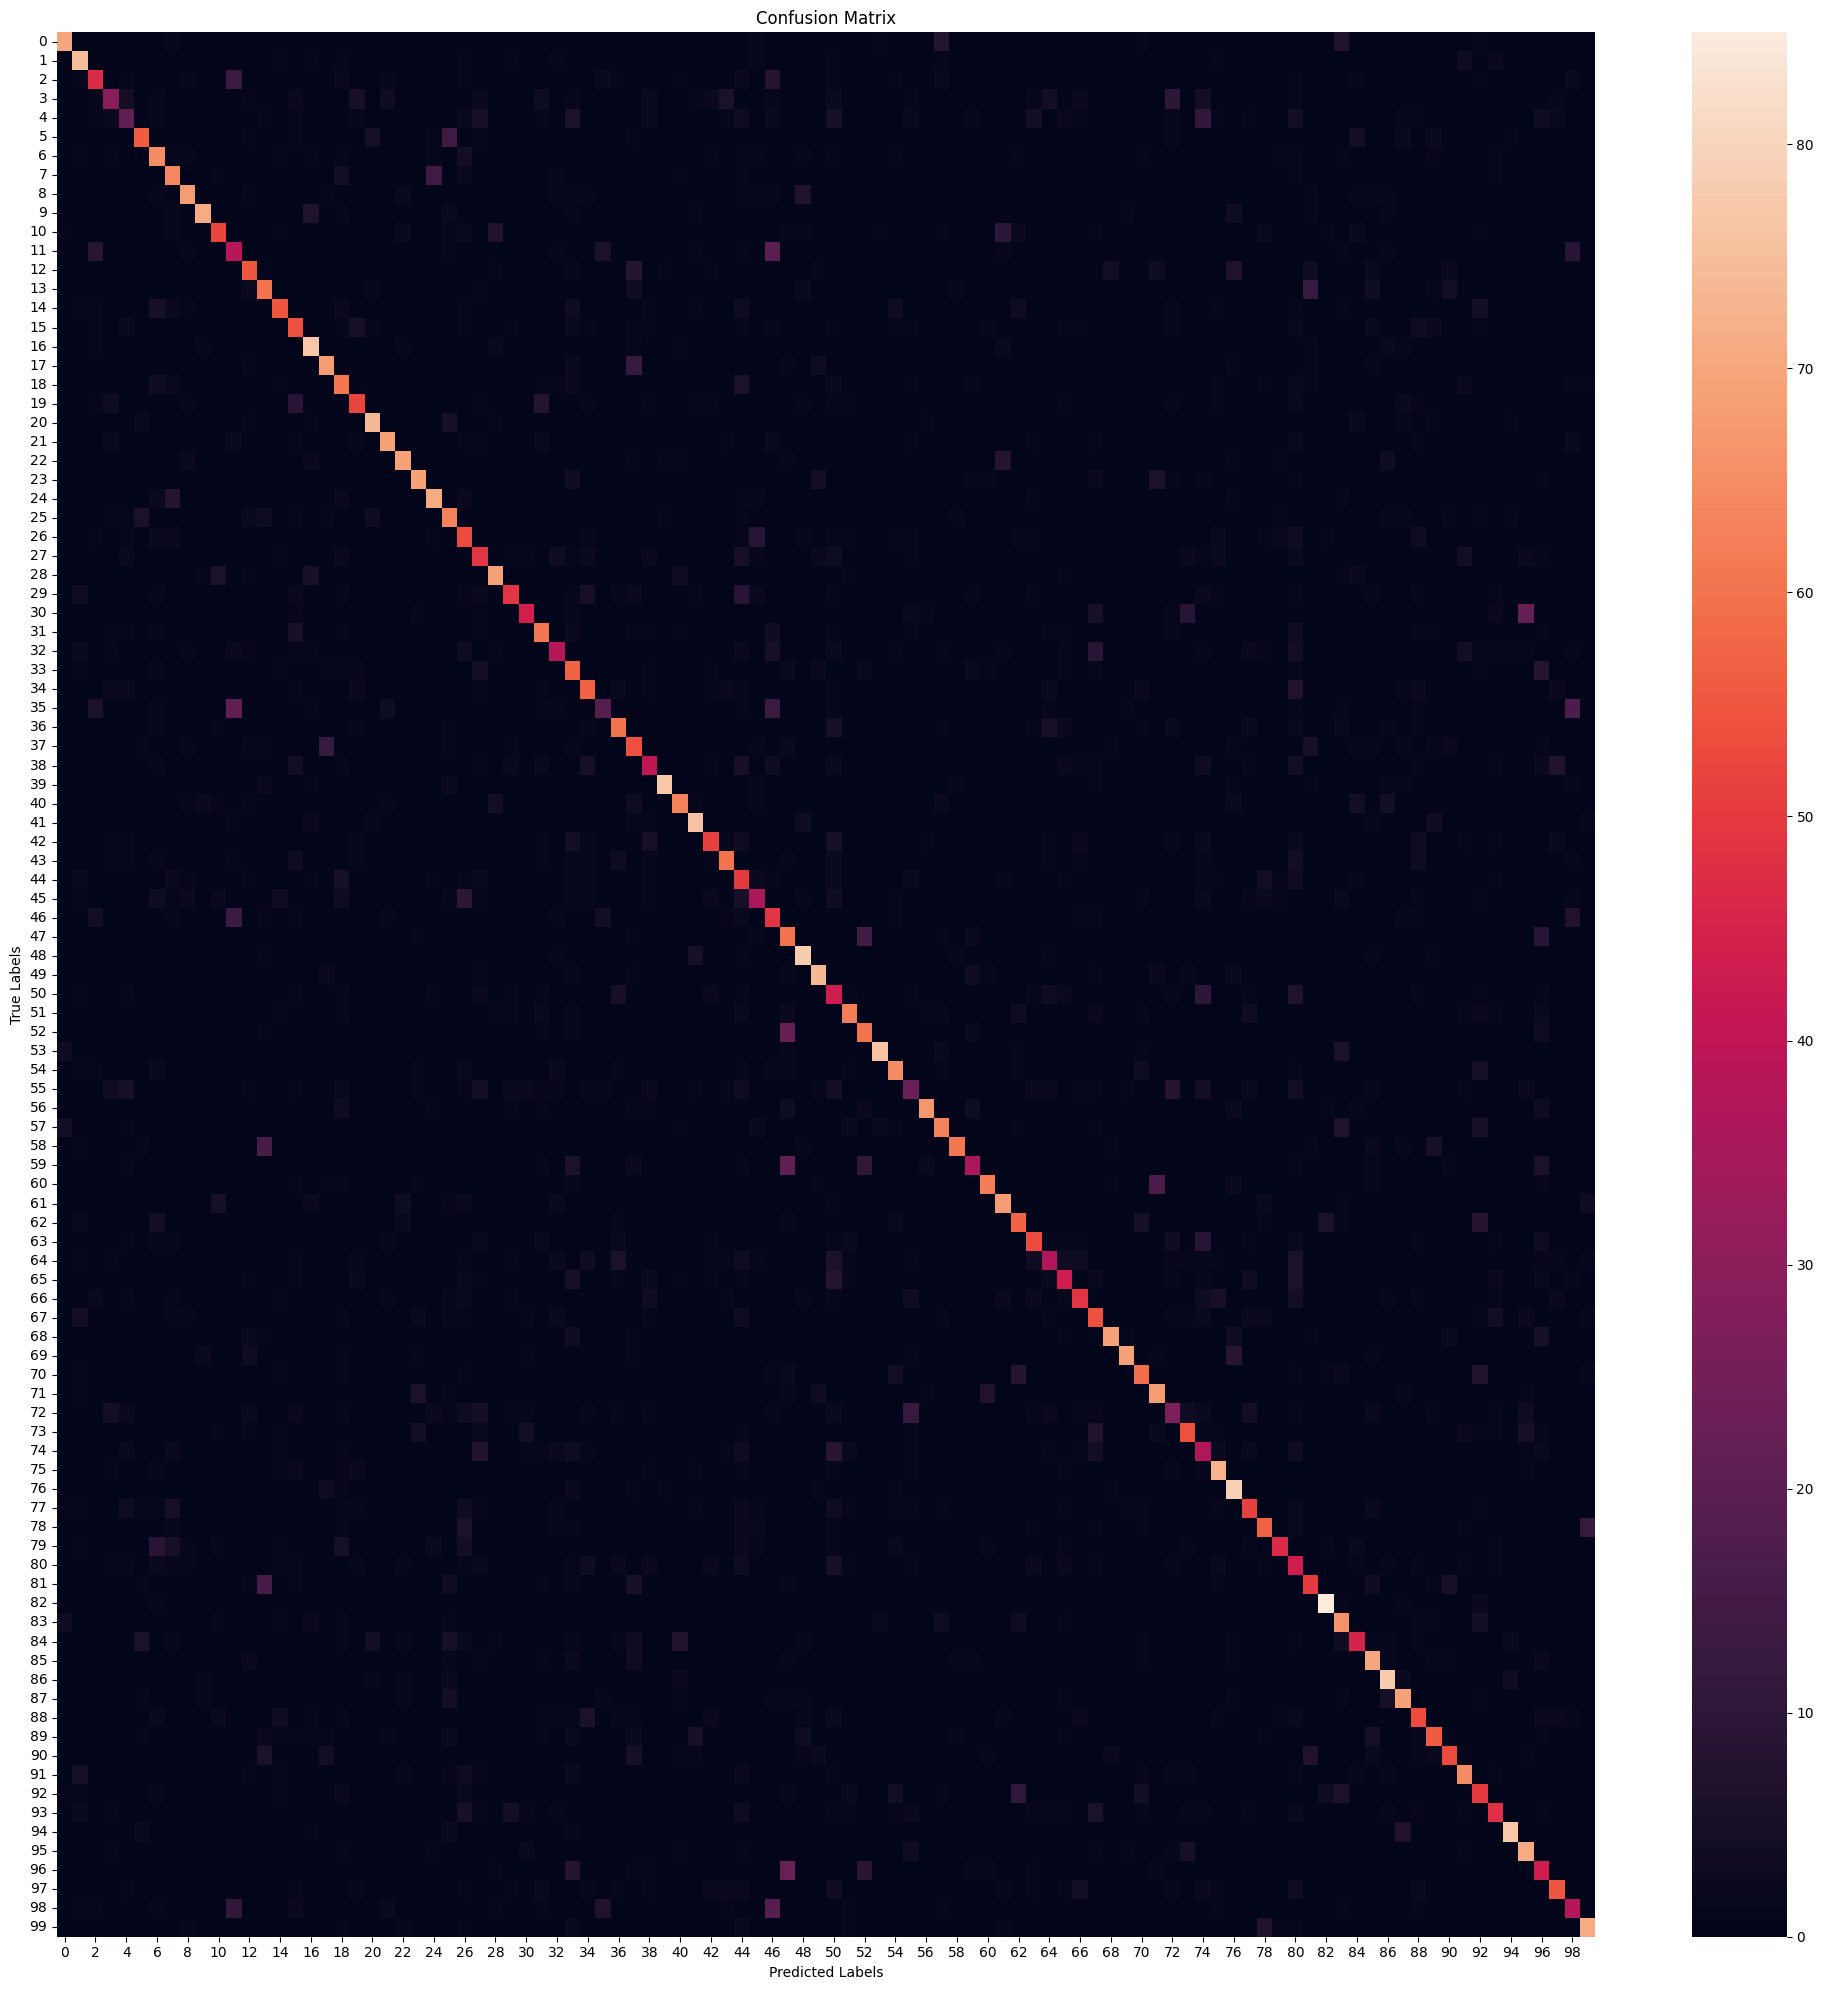

                   precision    recall  f1-score   support

           beaver       0.84      0.78      0.81        90
          dolphin       0.68      0.83      0.75        90
            otter       0.61      0.52      0.56        90
             seal       0.52      0.32      0.40        90
            whale       0.38      0.23      0.29        90
    aquarium fish       0.72      0.62      0.67        90
         flatfish       0.57      0.72      0.63        90
              ray       0.62      0.71      0.66        90
            shark       0.80      0.76      0.78        90
            trout       0.90      0.79      0.84        90
          orchids       0.71      0.58      0.64        90
          poppies       0.37      0.42      0.40        90
            roses       0.66      0.61      0.64        90
       sunflowers       0.54      0.67      0.59        90
           tulips       0.70      0.61      0.65        90
          bottles       0.53      0.60      0.56       

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 100)                 │          51,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,665,188 (94.09 MB)

 Trainable params: 1,100,388 (4.20 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/15
1313/1314 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6698 - f1_score: 0.6681 - loss: 1.1204 - precision: 0.8110
Epoch 1: val_loss improved from inf to 1.27476, saving model to best_model_fine_tune_v1.keras
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 57s 35ms/step - accuracy: 0.6698 - f1_score: 0.6681 - loss: 1.1204 - precision: 0.8110 - val_accuracy: 0.6466 - val_f1_score: 0.6449 - val_loss: 1.2748 - val_precision: 0.7966
Epoch 2/15
1313/1314 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6925 - f1_score: 0.6904 - loss: 1.0296 - precision: 0.8278
Epoch 2: val_loss improved from 1.27476 to 1.26837, saving model to best_model_fine_tune_v1.keras
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 36s 27ms/step - accuracy: 0.6925 - f1_score: 0.6904 - loss: 1.0296 - precision: 0.8278 - val_accuracy: 0.6497 - val_f1_score: 0.6480 - val_loss: 1.2684 - val_precision: 0.7961
Epoch 3/15
1313/1314 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6985 - f1_score: 0.6965 - loss: 1.0061 - precision: 0.8351
Epoch 3: v

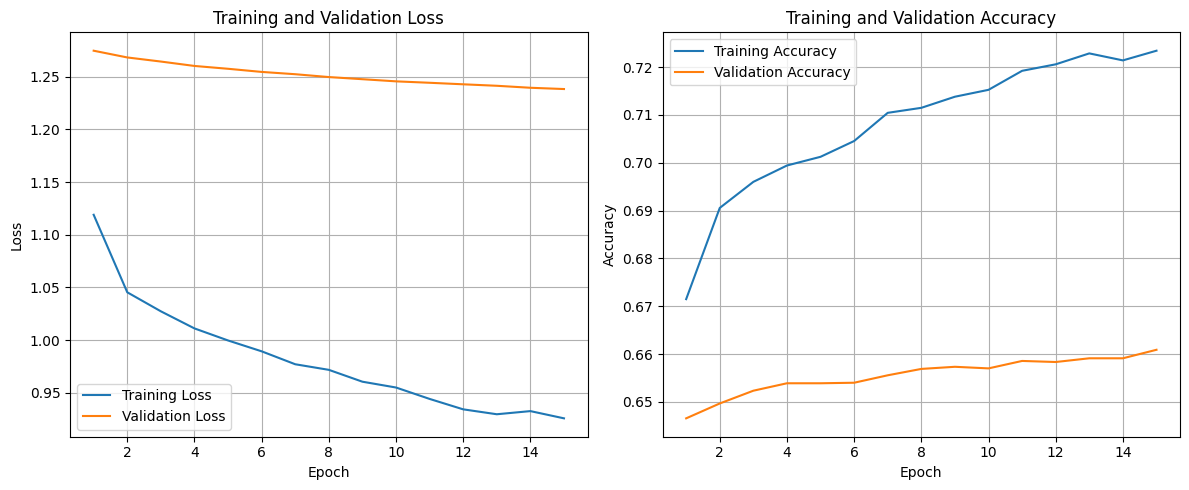

141/141 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 0.6568 - f1_score: 0.6484 - loss: 1.2409 - precision: 0.7961
Test Accuracy: 66.28%
Test Loss: 1.2180702686309814
Test Precision: 80.19%
Test F1 Scores (Per Class): [84.26965  77.89473  58.63874  48.863632 37.988823 67.05202  62.827217
 71.18643  81.14285  83.236984 64.83515  44.571423 65.14285  61.538452
 65.11627  57.297295 80.42328  77.173904 60.33519  61.90476  81.96721
 78.723404 81.96721  78.88888  79.787224 65.517235 55.555553 48.2412
 77.77777  65.47618  66.66666  66.66666  51.807224 62.105255 66.29213
 37.988823 69.61325  57.297295 51.396645 90.90909  68.06282  82.48587
 62.702698 72.31638  49.197857 52.631577 50.847454 52.1739   81.675385
 84.61538  39.534874 73.62636  64.2857   91.208786 70.05075  38.418076
 81.6568   73.91304  75.30864  55.294113 78.16091  74.57626  63.73626
 63.953484 45.23809  51.461983 61.62162  58.69565  88.04347  86.910995
 64.739876 74.19354  42.23602  62.76595  38.341965 79.787224 83.798874
 63.68

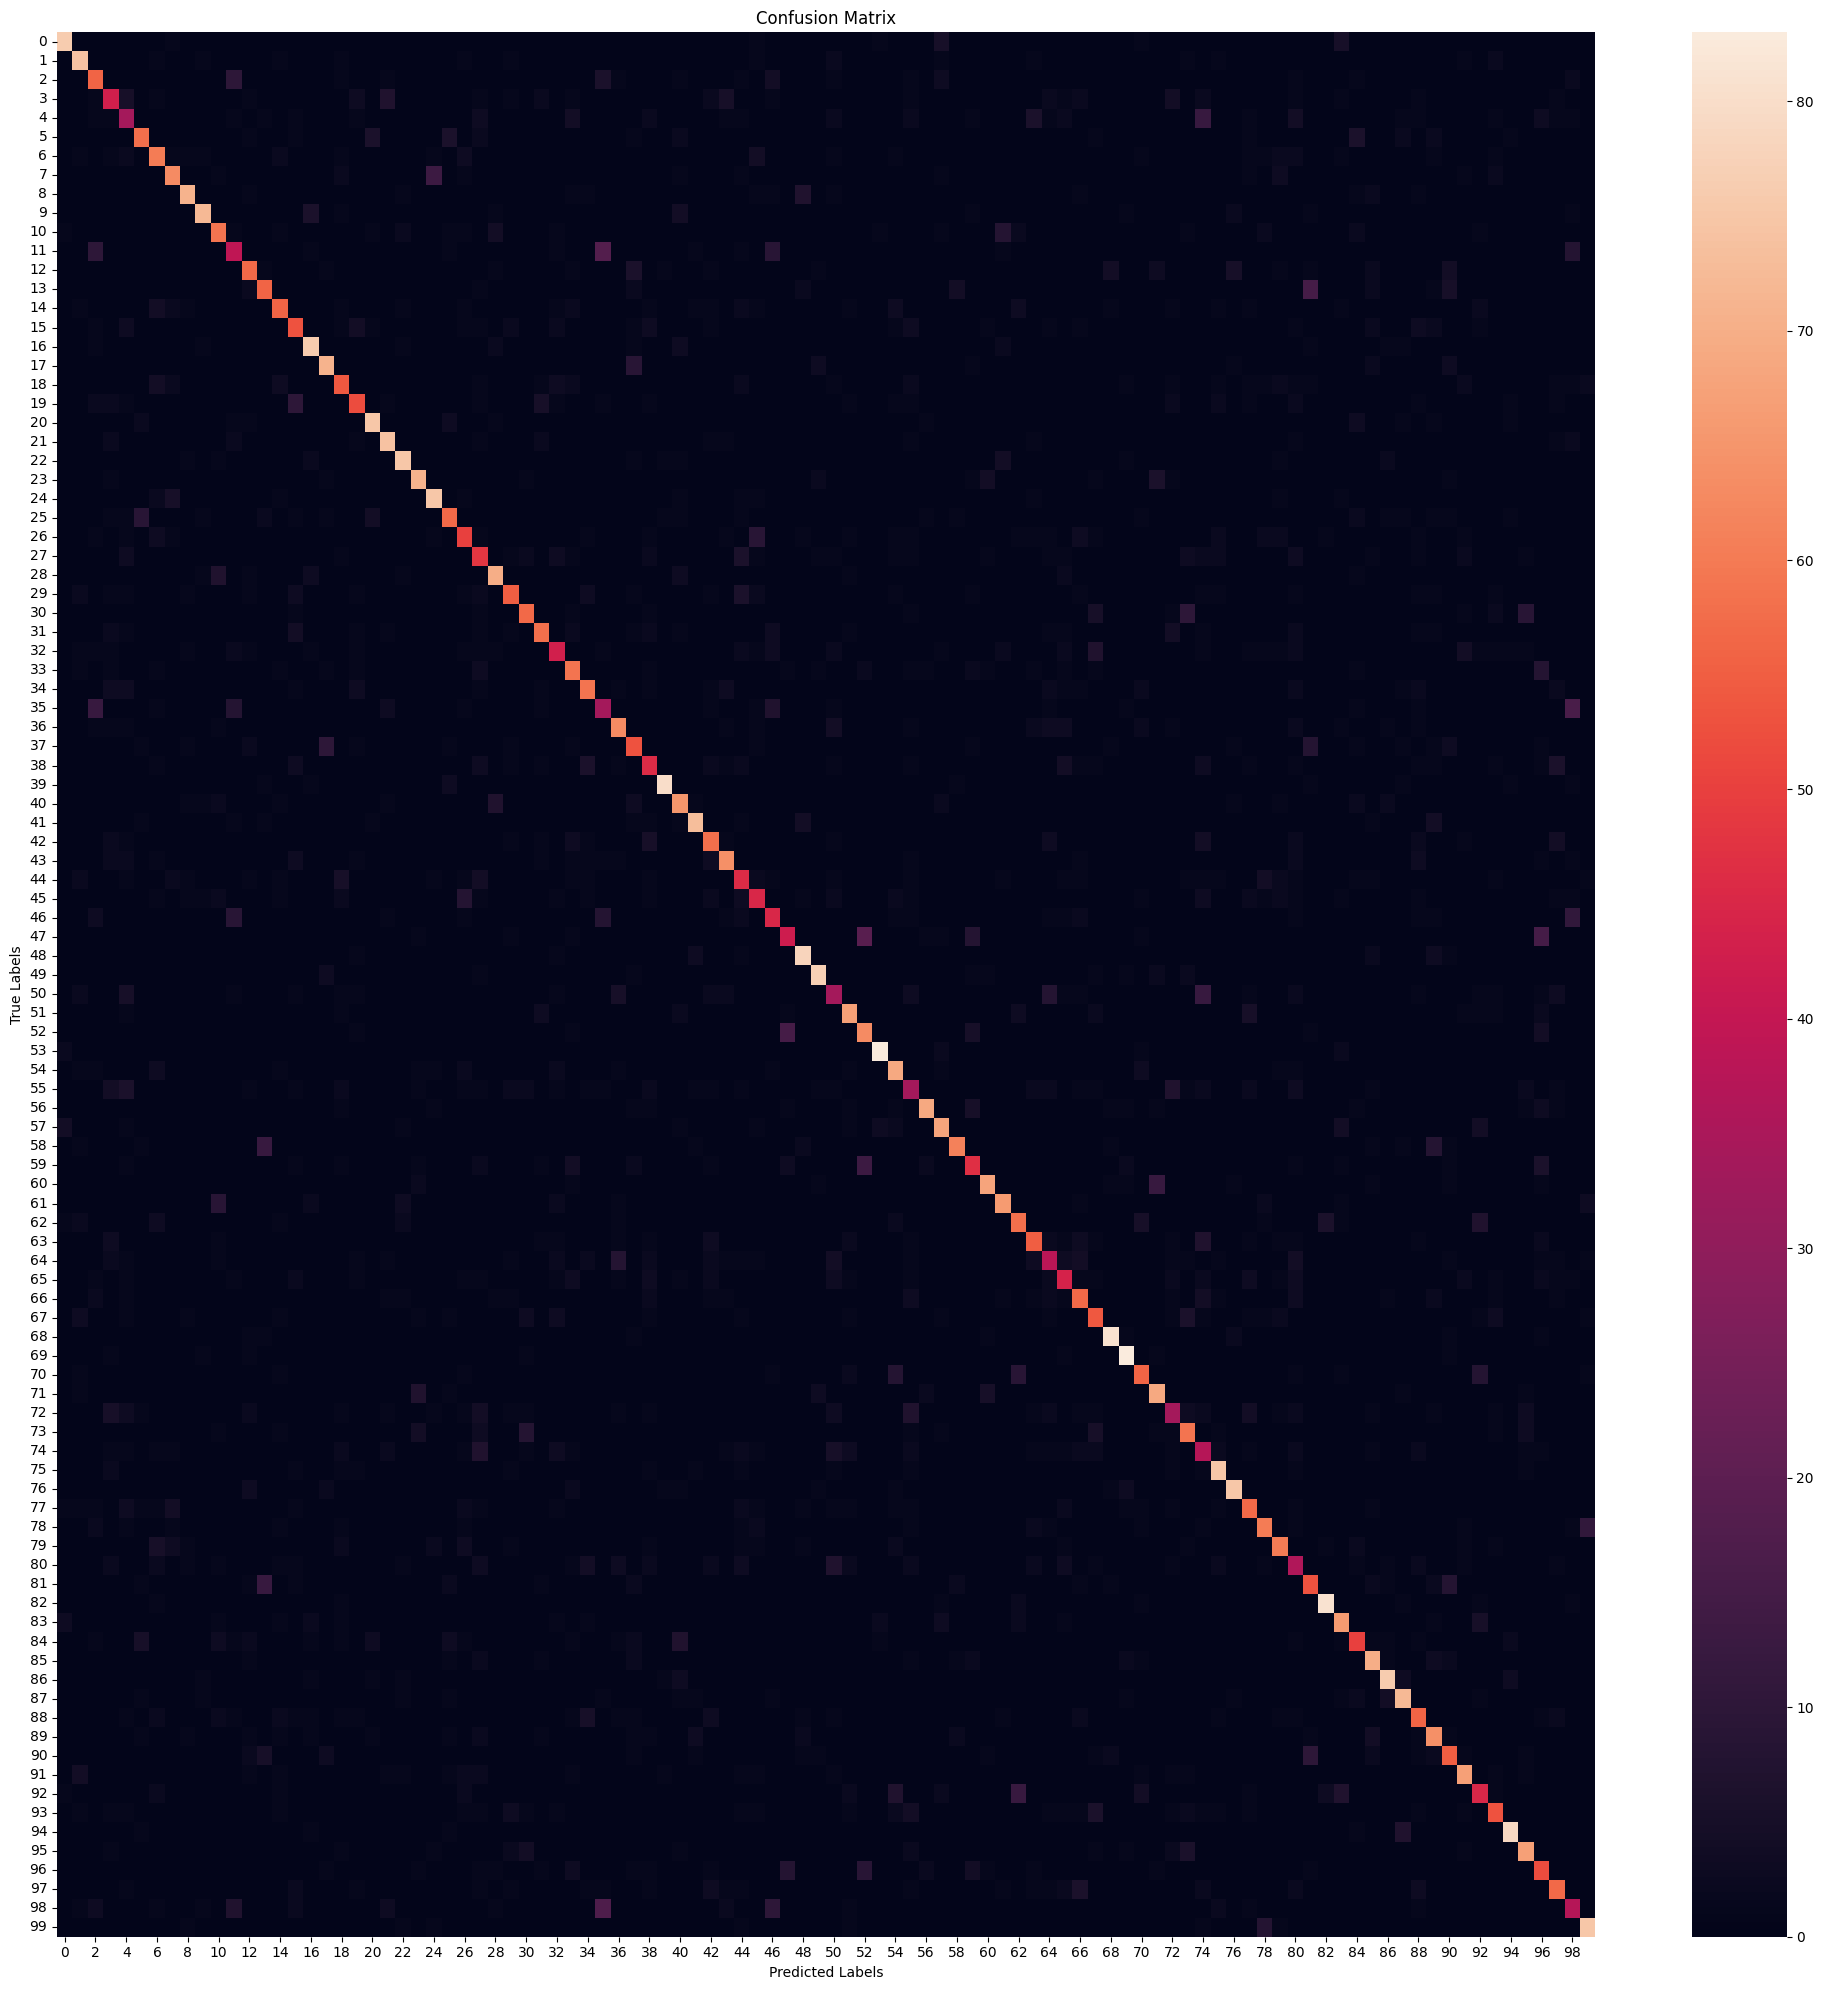

                   precision    recall  f1-score   support

           beaver       0.85      0.84      0.85        90
          dolphin       0.74      0.82      0.78        90
            otter       0.55      0.62      0.59        90
             seal       0.50      0.48      0.49        90
            whale       0.38      0.38      0.38        90
    aquarium fish       0.70      0.64      0.67        90
         flatfish       0.59      0.67      0.63        90
              ray       0.73      0.70      0.72        90
            shark       0.84      0.79      0.81        90
            trout       0.87      0.80      0.83        90
          orchids       0.64      0.66      0.65        90
          poppies       0.46      0.43      0.45        90
            roses       0.67      0.63      0.65        90
       sunflowers       0.61      0.62      0.62        90
           tulips       0.68      0.62      0.65        90
          bottles       0.56      0.59      0.57       

In [5]:
for repeat_2_times in range(2):
    #### <<<<<<<<<<Load and process data>>>>>>>>>>
    # Load CIFAR-100 dataset
    (X_train, y_train), (X_test, y_test) = cifar100.load_data(label_mode='fine')

    # Split (8000) of training data into temporary set
    X_temp, X_train, y_temp, y_train = train_test_split(X_train, y_train, test_size=0.84, stratify=y_train, random_state=42)
    print(f"X_temp.shape: {X_temp.shape}\n")

    # Split temp data into equal validation (4000) and testing (4000) data
    X_temp_val, X_temp_test, y_temp_val, y_temp_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
    print(f"X_temp_val.shape: {X_temp_val.shape}")
    print(f"y_temp_val.shape: {y_temp_val.shape}")
    print(f"X_temp_test.shape: {X_temp_test.shape}")
    print(f"y_temp_test.shape: {y_temp_test.shape}\n")

    # Split test data into validation (5000) and testing (5000)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)

    # Add temp_val to validation (9000) and temp_test to testing (9000) to get a 70/15/15 data split
    X_val = np.concatenate((X_val, X_temp_val), axis=0)
    y_val = np.concatenate((y_val, y_temp_val), axis=0)
    X_test = np.concatenate((X_test, X_temp_test), axis=0)
    y_test = np.concatenate((y_test, y_temp_test), axis=0)

    print(f"X_train.shape: {X_train.shape}")
    print(f"y_train.shape: {y_train.shape}")
    print(f"X_val.shape: {X_val.shape}")
    print(f"y_val.shape: {y_val.shape}")
    print(f"X_test.shape: {X_test.shape}")
    print(f"y_test.shape: {y_test.shape}\n")

    display_imgs(X_train, y_train)

    # Normalise images (scale to range [0, 1]) - Improves convergence speed & accuracy
    X_train, X_val, X_test = X_train / 255.0, X_val / 255.0, X_test / 255.0
    display_imgs(X_train, y_train)

    labels_names = ['beaver','dolphin','otter','seal','whale','aquarium fish','flatfish','ray','shark','trout',
                   'orchids','poppies','roses','sunflowers','tulips','bottles','bowls','cans','cups','plates',
                   'apples','mushrooms','oranges','pears','sweet peppers','clock','computer keyboard','lamp',
                   'telephone','television','bed','chair','couch','table','wardrobe','bee','beetle','butterfly',
                   'caterpillar','cockroach','bear','leopard','lion','tiger','wolf','bridge','castle','house',
                   'road','skyscraper','cloud','forest','mountain','plain','sea','camel','cattle','chimpanzee',
                   'elephant','kangaroo','fox','porcupine','possum','raccoon','skunk','crab','lobster','snail',
                   'spider','worm','baby','boy','girl','man','woman','crocodile','dinosaur','lizard','snake',
                   'turtle','hamster','mouse','rabbit','shrew','squirrel','maple','oak','palm','pine','willow',
                   'bicycle','bus','motorcycle','pickup truck','train','lawn-mower','rocket','streetcar','tank',
                   'tractor']

    class_distrib(y_train, labels_names, "Training")
    class_distrib(y_val, labels_names, "Validating")
    class_distrib(y_test, labels_names, "Testing")

    # Create TensorFlow datasets

    batch_size = 64

    train_dataset = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
                     .map(lambda x, y: (tf.image.resize(x, (224, 224)),
                                        tf.squeeze(tf.one_hot(y, depth=100, dtype=tf.float32))))  # Remove extra dimension
                     .batch(batch_size)
                     .prefetch(tf.data.experimental.AUTOTUNE))

    val_dataset = (tf.data.Dataset.from_tensor_slices((X_val, y_val))
                   .map(lambda x, y: (tf.image.resize(x, (224, 224)),
                                      tf.squeeze(tf.one_hot(y, depth=100, dtype=tf.float32))))  # Remove extra dimension
                   .batch(batch_size)
                   .prefetch(tf.data.experimental.AUTOTUNE))

    test_dataset = (tf.data.Dataset.from_tensor_slices((X_test, y_test))
                     .map(lambda x, y: (tf.image.resize(x, (224, 224)),
                                        tf.squeeze(tf.one_hot(y, depth=100, dtype=tf.float32))))  # Remove extra dimension
                    .batch(batch_size)
                    .prefetch(tf.data.experimental.AUTOTUNE))

    print(f"Training dataset:\n {train_dataset}")
    for img, lbl in train_dataset.take(1):
        #if isinstance(batch, tuple) and len(batch) == 2:
        print(f"Image shape: {img.shape}")  # Should be (batch_size, 224, 224, 3)
        print(f"Label shape: {lbl.shape}")  # Should be (batch_size, 10)
        del img,lbl
    print(f"\nValidation dataset:\n {val_dataset}")
    for img, lbl in val_dataset.take(1):
        #if isinstance(batch, tuple) and len(batch) == 2:
        print(f"Image shape: {img.shape}")  # Should be (batch_size, 224, 224, 3)
        print(f"Label shape: {lbl.shape}")  # Should be (batch_size, 10)
        del img,lbl
    print(f"\nTesting dataset:\n {test_dataset}")
    for img, lbl in test_dataset.take(1):
        #if isinstance(batch, tuple) and len(batch) == 2:
        print(f"Image shape: {img.shape}")  # Should be (batch_size, 224, 224, 3)
        print(f"Label shape: {lbl.shape}")  # Should be (batch_size, 10)
        del img,lbl


    #### <<<<<<<<<<Pre-trained model>>>>>>>>>>
    # Load ResNet50 pre-trained on ImageNet (w/out the top classification layer which is designed for ImageNet (diff dataset))
    resnet_50_base = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the layers of VGG16 so they don't get updated during training - can unfreeze for fine tuning later
    resnet_50_base.trainable = False

    # Add custom classification layers for CIFAR-100 (100 classes) - adapt model to CIFAR-100
    model = models.Sequential([
        resnet_50_base,
        layers.GlobalAveragePooling2D(), # Better for ResNet than Flatten
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.6), # DEBUG dropout
        layers.Dense(100, activation='softmax')  # CIFAR-100 has 100 classes
    ])

    for sample in test_dataset.take(1):
        print(type(sample))  # Should be <class 'tuple'>
        print(len(sample))  # Should be 2
        print(type(sample[0]), type(sample[1]))  # Both should be <class 'tensorflow.Tensor'>
        print(sample[0].shape)  # Should be (batch_size, 224, 224, 3)
        print(sample[1].shape)  # Should be (batch_size, 100)
    print(f"Model input shape: {model.input_shape}")
    print(f"Model output shape: {model.output_shape}")
    sample = next(iter(test_dataset.as_numpy_iterator()))
    print(len(sample))  # Should be 2
    print(type(sample[0]), type(sample[1]))  # Both should be <class 'numpy.ndarray'>
    print(sample[0].shape, sample[1].shape)  # Should match model input and output
    print("\n")
    #for x, y in test_dataset.take(1):
    #    print(type(x), type(y))  # Both should be <class 'tensorflow.Tensor'>
    #for x_batch, y_batch in test_dataset.take(1):
    #    test_loss, test_acc = model.evaluate(x_batch, y_batch)
    #    print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

    # Compile the model
    #tensorboard_callback = keras.callbacks.TensorBoard(log_dir="./logs")
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-3, weight_decay=3e-2), # DEBUG weight
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'precision', 'f1_score'])

    model.summary()

    #### <<<<<<<<<<Train Model & Track Training/Validation Error>>>>>>>>>>
    early_stopping = EarlyStopping(monitor='val_loss', # or val_accuracy
                                   patience=5, # Num. epochs with no improvements - help void overfitting
                                   restore_best_weights=True)
    #reduce_lr = ReduceLROnPlateau(monitor='val_loss', # or val_accuracy
    #                              factor=0.1, # Reduce lr by a factor
    #                              patience=3, # Num epochs w/ no improvement
    #                              min_lr=1e-6, # Min lr
    #                              verbose=1)
    #tensorboard = TensorBoard(log_dir='./logs', # Logs directory
    #                         histogram_freq=1, # Logs histograms for weights/activations
    #                         write_graph=True, # Logs graph of model
    #                         write_images=True) # Log images like weight histogram
    checkpoint = ModelCheckpoint('best_model_v1.keras', # Path where the best model will be saved
                                 monitor='val_loss', # What to monitor (validation loss)
                                 save_best_only=True, # Only save model when validation loss improves
                                 mode='min', # Looking to minimse the validation loss
                                 verbose=1) # Print out message when saving model
    checkpoint_fine_tune = ModelCheckpoint('best_model_fine_tune_v1.keras', # Path where the best model will be saved
                                 monitor='val_loss', # What to monitor (validation loss)
                                 save_best_only=True, # Only save model when validation loss improves
                                 mode='min', # Looking to minimse the validation loss
                                 verbose=1) # Print out message when saving model
    #cvs_logger = CSVLogger('training_log.csv', seperator=',', append=True) # Save train metrics to analyse

    # Train the model
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=25,
                        batch_size=batch_size, callbacks=[early_stopping, checkpoint], verbose=1)

    #### <<<<<<<<<<Plot Training & Validation Error>>>>>>>>>>

    # Extract loss and accuracy
    epochs = range(1,len(history.history['loss'])+1)
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    plot_evidence(epochs, train_loss, val_loss, train_acc, val_acc)

    #### <<<<<<<<<<Evaluate Model on Test Data>>>>>>>>>>

    # Evaluate on test data
    model = load_model('best_model_v1.keras')
    results = model.evaluate(test_dataset)
    test_loss = results[0]
    test_acc = results[1]
    test_precision = results[2]
    test_f1_scores = results[3]
    print(f"Test Accuracy: {test_acc*100:.2f}%")
    print(f"Test Loss: {test_loss}")
    print(f"Test Precision: {test_precision*100:.2f}%")
    print(f"Test F1 Scores (Per Class): {test_f1_scores.numpy()*100}")
    print(f"Average Test F1 Scores:{np.average(test_f1_scores.numpy()*100):.2f}\n")

    #### <<<<<<<<<<Generate Confusion Matrix>>>>>>>>>>

    # Get predictions
    X_test_revised = tf.image.resize(X_test, (224, 224))
    y_pred = model.predict(X_test_revised)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = y_test.flatten()

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

    # Plot confusion matrix
    plt.figure(figsize=(20, 20))
    sns.heatmap(conf_matrix) #cmap='Blues', fmt='d'
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    print(classification_report(y_true_classes, y_pred_classes, target_names=labels_names))
    #tensorboard --logdir==path_to_your_logs

    # Create a DataFrame from the history of the training and store the epoch values.
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    # Finally, display the hist DataFrame.
    hist

    #### <<<<<<<<<<Fine-Tune>>>>>>>>>>
    # Adapt Model
    for layer in resnet_50_base.layers:
        layer.trainable = True # Allow layers to be updated

    # Compile again w/ lower learning rate (prevents destroying learned features)
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'precision', 'f1_score'])

    model.summary()

    #### <<<<<<<<<<Modify Dataset>>>>>>>>>>


    # DEBUG augment
    train_dataset_aug_ = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
                     .map(augment_dataset, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                     .batch(batch_size)
                     .prefetch(tf.data.experimental.AUTOTUNE))

    # Combine the original dataset and the augmented dataset
    train_dataset_aug = train_dataset.concatenate(train_dataset_aug_) # Not val or test as augment train helps generalise better, but want to provide consistent benchmark for eval perf

    #### <<<<<<<<<<Train Model & Track Training/Validation Error>>>>>>>>>>

    # Train the model
    history_fine_tune = model.fit(train_dataset_aug, validation_data=val_dataset, epochs=15,
                                  batch_size=batch_size, callbacks=[early_stopping, checkpoint_fine_tune], verbose=1)

    #### <<<<<<<<<<Plot Training & Validation Error>>>>>>>>>>

    # Extract loss and accuracy
    epochs = range(1,len(history_fine_tune.history['loss'])+1)
    train_loss = history_fine_tune.history['loss']
    val_loss = history_fine_tune.history['val_loss']
    train_acc = history_fine_tune.history['accuracy']
    val_acc = history_fine_tune.history['val_accuracy']

    plot_evidence(epochs, train_loss, val_loss, train_acc, val_acc)

    #### <<<<<<<<<<Evaluate Model on Test Data>>>>>>>>>>

    # Evaluate on test data
    model_fine_tune = load_model('best_model_fine_tune_v1.keras')
    results = model_fine_tune.evaluate(test_dataset)
    test_loss = results[0]
    test_acc = results[1]
    test_precision = results[2]
    test_f1_scores = results[3]
    print(f"Test Accuracy: {test_acc*100:.2f}%")
    print(f"Test Loss: {test_loss}")
    print(f"Test Precision: {test_precision*100:.2f}%")
    print(f"Test F1 Scores (Per Class): {test_f1_scores.numpy()*100}")
    print(f"Average Test F1 Scores:{np.average(test_f1_scores.numpy()*100):.2f}\n")

    #### <<<<<<<<<<Generate Confusion Matrix>>>>>>>>>>

    # Get predictions
    X_test_revised = tf.image.resize(X_test, (224, 224))
    y_pred = model_fine_tune.predict(X_test_revised)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = y_test.flatten()

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

    # Plot confusion matrix
    plt.figure(figsize=(20, 20))
    sns.heatmap(conf_matrix) #cmap='Blues', fmt='d'
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    print(classification_report(y_true_classes, y_pred_classes, target_names=labels_names))

    # Create a DataFrame from the history of the training and store the epoch values.
    hist = pd.DataFrame(history_fine_tune.history)
    hist['epoch'] = history_fine_tune.epoch

    # Finally, display the hist DataFrame.
    hist

# Dropout(0.6), weight_decay(3e-2), l2(3e-2)

X_temp.shape: (8000, 32, 32, 3)

X_temp_val.shape: (4000, 32, 32, 3)
y_temp_val.shape: (4000, 1)
X_temp_test.shape: (4000, 32, 32, 3)
y_temp_test.shape: (4000, 1)

X_train.shape: (42000, 32, 32, 3)
y_train.shape: (42000, 1)
X_val.shape: (9000, 32, 32, 3)
y_val.shape: (9000, 1)
X_test.shape: (9000, 32, 32, 3)
y_test.shape: (9000, 1)

labels[9538].shape: (1,)
imgs[9538].shape: (32, 32, 3)


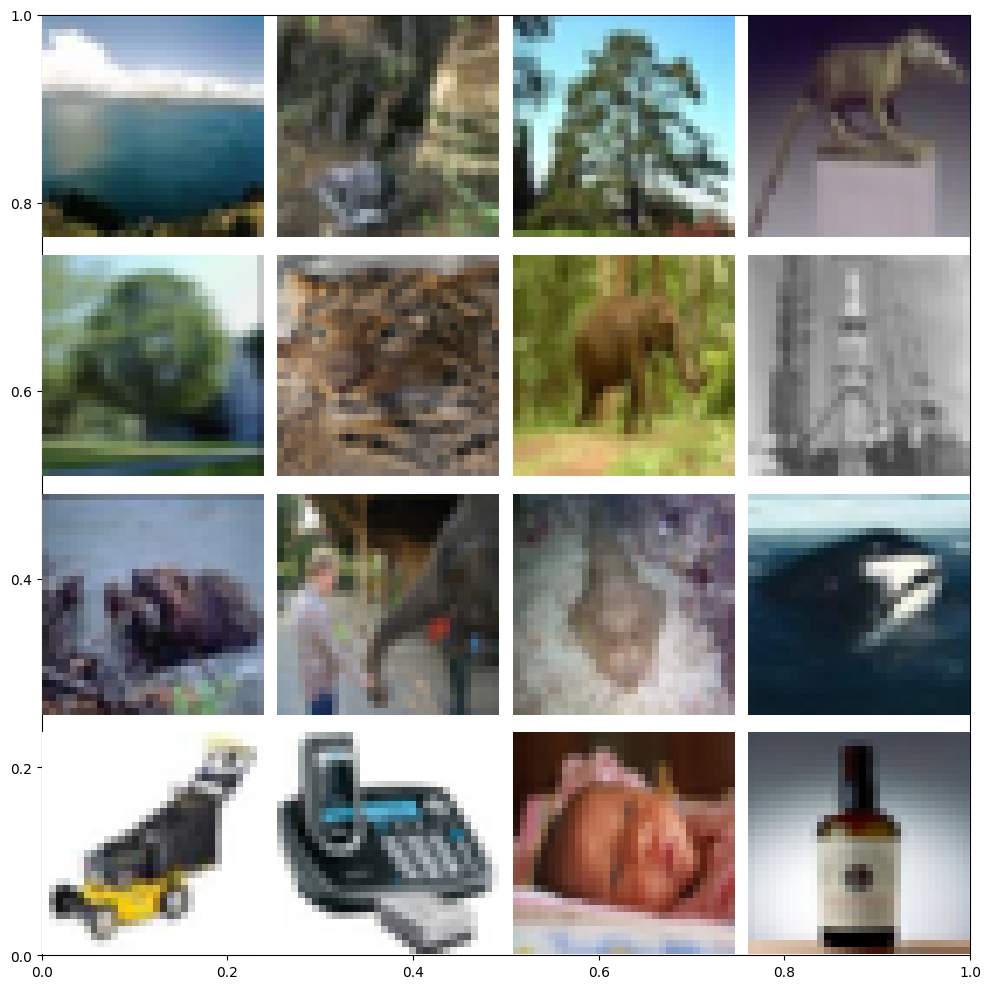

labels[24543].shape: (1,)
imgs[24543].shape: (32, 32, 3)


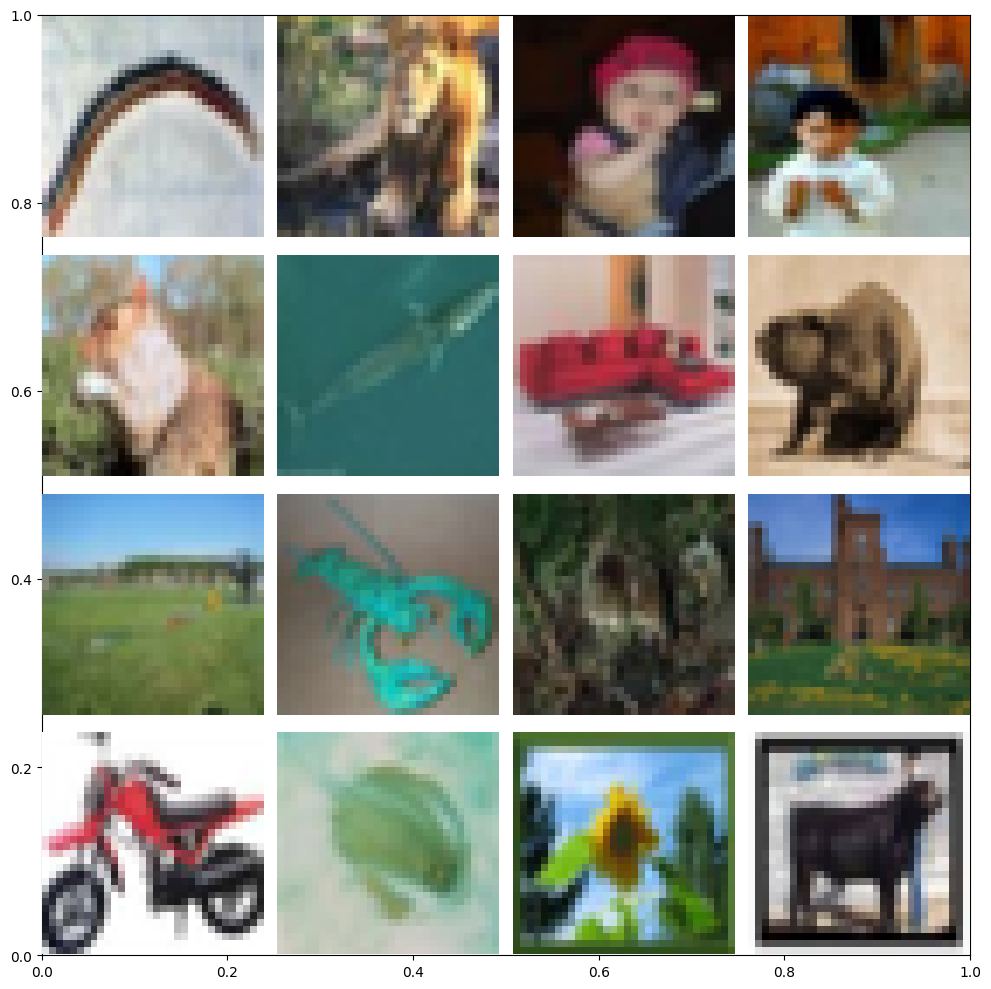

<ipython-input-4-78561581887d>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


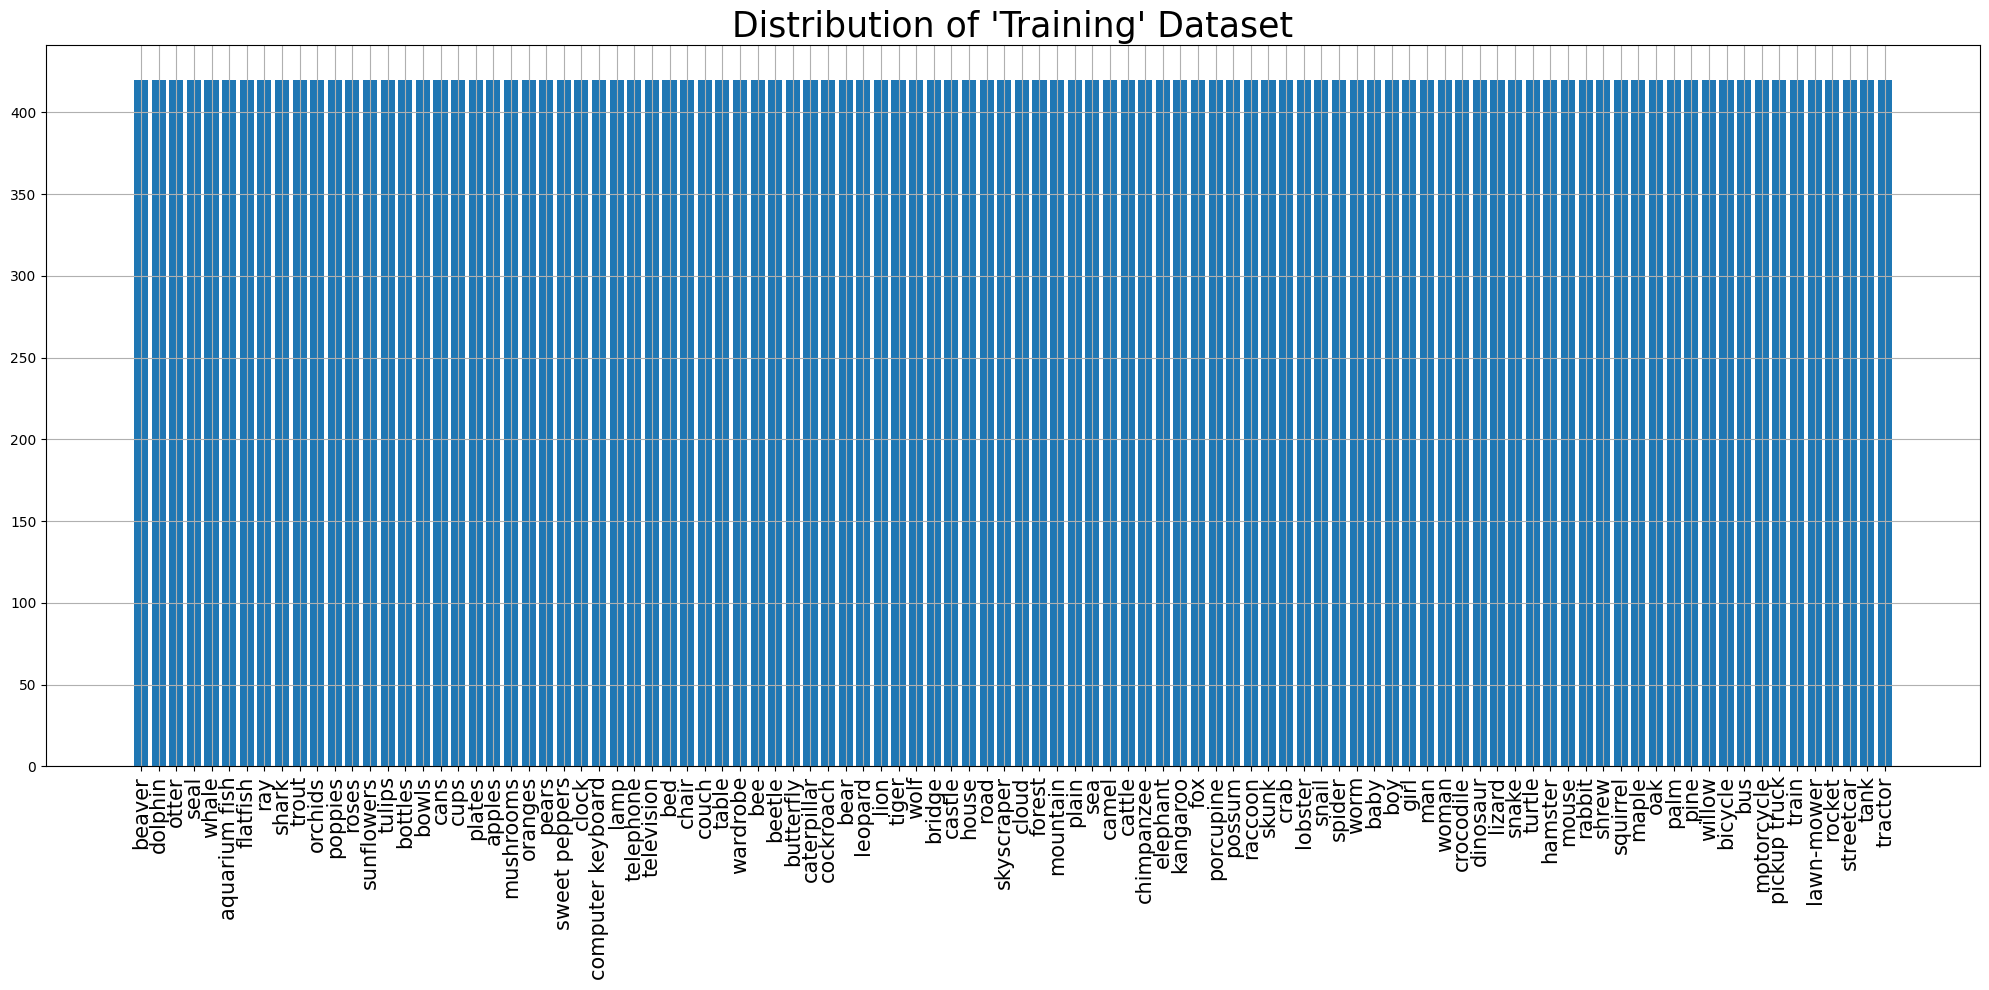

<ipython-input-4-78561581887d>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


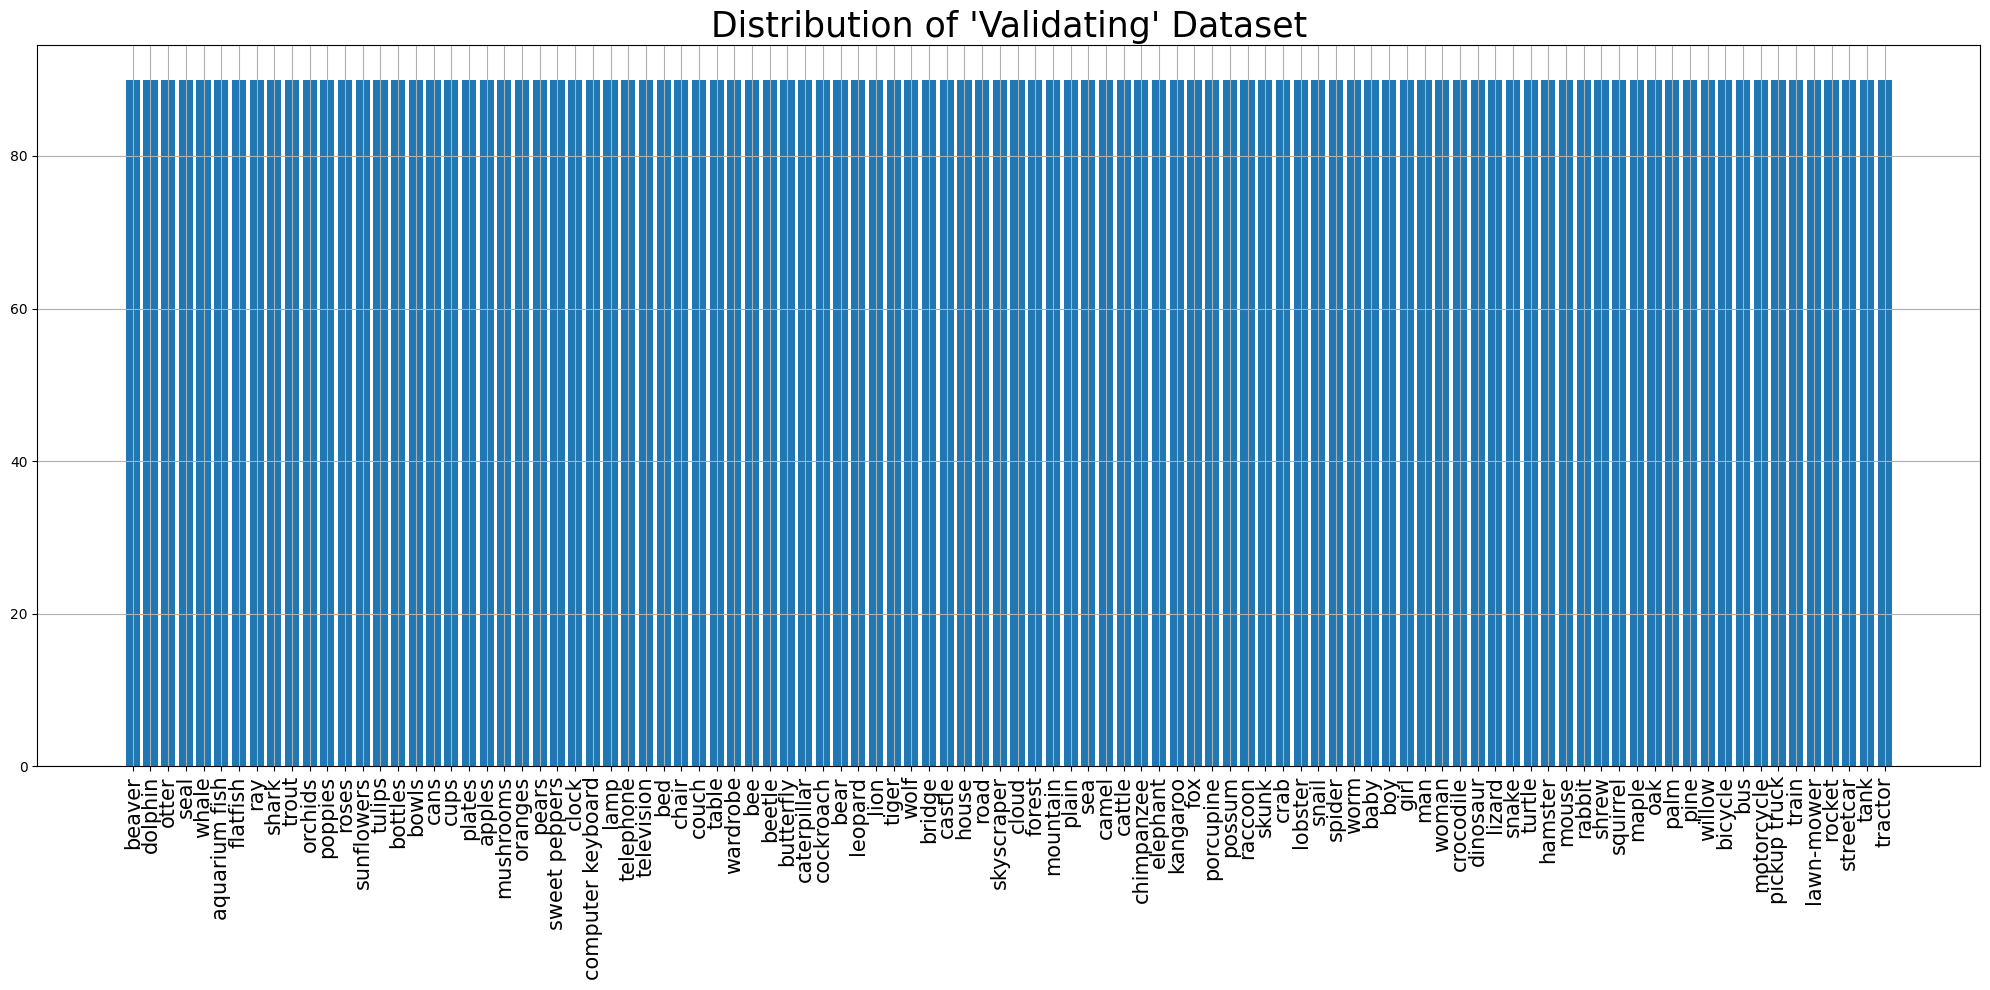

<ipython-input-4-78561581887d>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


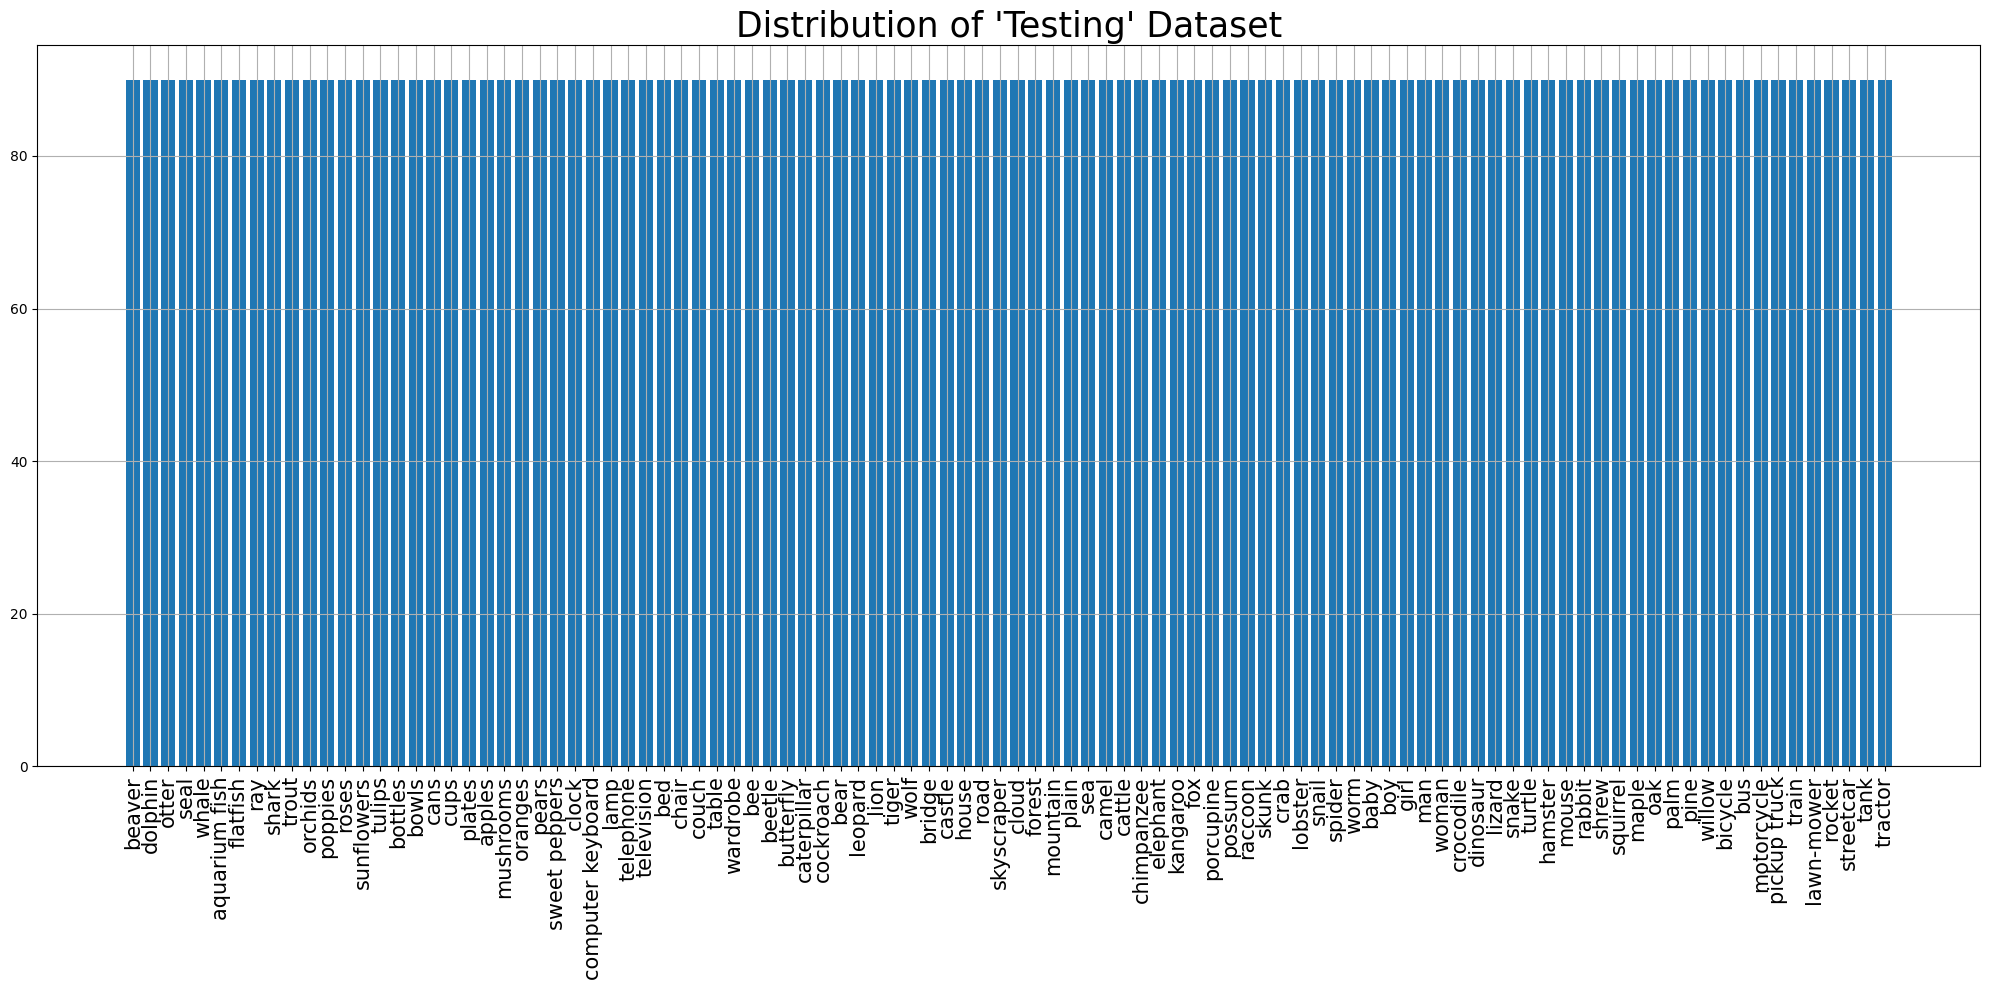

Training dataset:
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)

Validation dataset:
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)

Testing dataset:
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)
<class 'tuple'>
2
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
(64, 224, 224, 3)
(64, 100)
Model input shape: (None, 224, 224, 3)
Model output shape: (None, 100)
2
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(64, 224, 224, 3) (6

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 100)                 │          51,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,665,188 (94.09 MB)

 Trainable params: 1,100,388 (4.20 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/25
657/657 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3145 - f1_score: 0.3081 - loss: 2.9021 - precision: 0.6628
Epoch 1: val_loss improved from inf to 1.50664, saving model to best_model_v2.keras
657/657 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.3147 - f1_score: 0.3083 - loss: 2.9012 - precision: 0.6628 - val_accuracy: 0.5849 - val_f1_score: 0.5795 - val_loss: 1.5066 - val_precision: 0.8154
Epoch 2/25
655/657 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5236 - f1_score: 0.5197 - loss: 1.7418 - precision: 0.7417
Epoch 2: val_loss improved from 1.50664 to 1.39411, saving model to best_model_v2.keras
657/657 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.5236 - f1_score: 0.5198 - loss: 1.7415 - precision: 0.7417 - val_accuracy: 0.6066 - val_f1_score: 0.6033 - val_loss: 1.3941 - val_precision: 0.8063
Epoch 3/25
655/657 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5685 - f1_score: 0.5656 - loss: 1.5453 - precision: 0.7607
Epoch 3: val_loss improved from 1.39411 

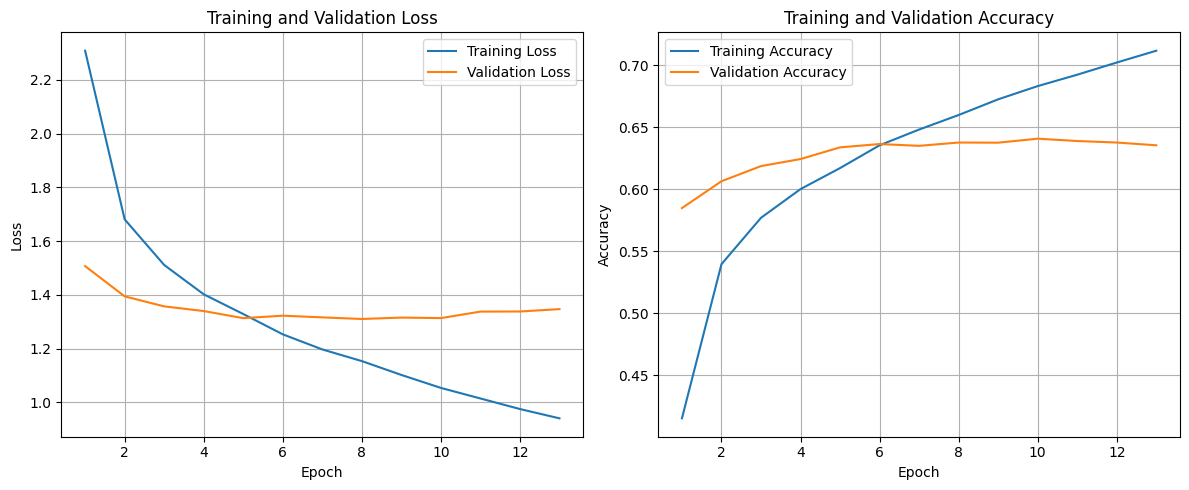

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.6260 - f1_score: 0.6178 - loss: 1.3274 - precision: 0.7766
Test Accuracy: 63.84%
Test Loss: 1.2974097728729248
Test Precision: 78.98%
Test F1 Scores (Per Class): [83.51647  75.97765  54.335255 41.134747 37.569054 64.36781  61.53846
 66.98565  79.26829  81.52173  56.37583  51.485146 66.25767  58.031082
 69.36415  49.599995 78.723404 70.046074 56.66666  54.32098  78.40909
 73.09644  75.73964  77.456635 74.69879  61.052628 54.143642 46.913574
 75.75757  60.645157 61.63522  62.702698 43.786976 56.852787 65.07177
 20.689651 68.63905  56.730766 46.857132 88.888885 69.82249  81.52173
 63.030296 68.53932  50.505043 46.540874 48.48484  58.620686 80.21977
 78.53403  37.499992 71.73912  61.187206 89.2857   67.77777  30.93922
 75.37688  72.04301  73.33333  55.84415  78.53403  69.346725 64.70587
 67.948715 42.307686 52.439022 62.195118 57.868015 86.01036  88.34355
 70.588234 72.83237  36.263733 58.139526 36.47058  81.28342  83.422455
 60.4651

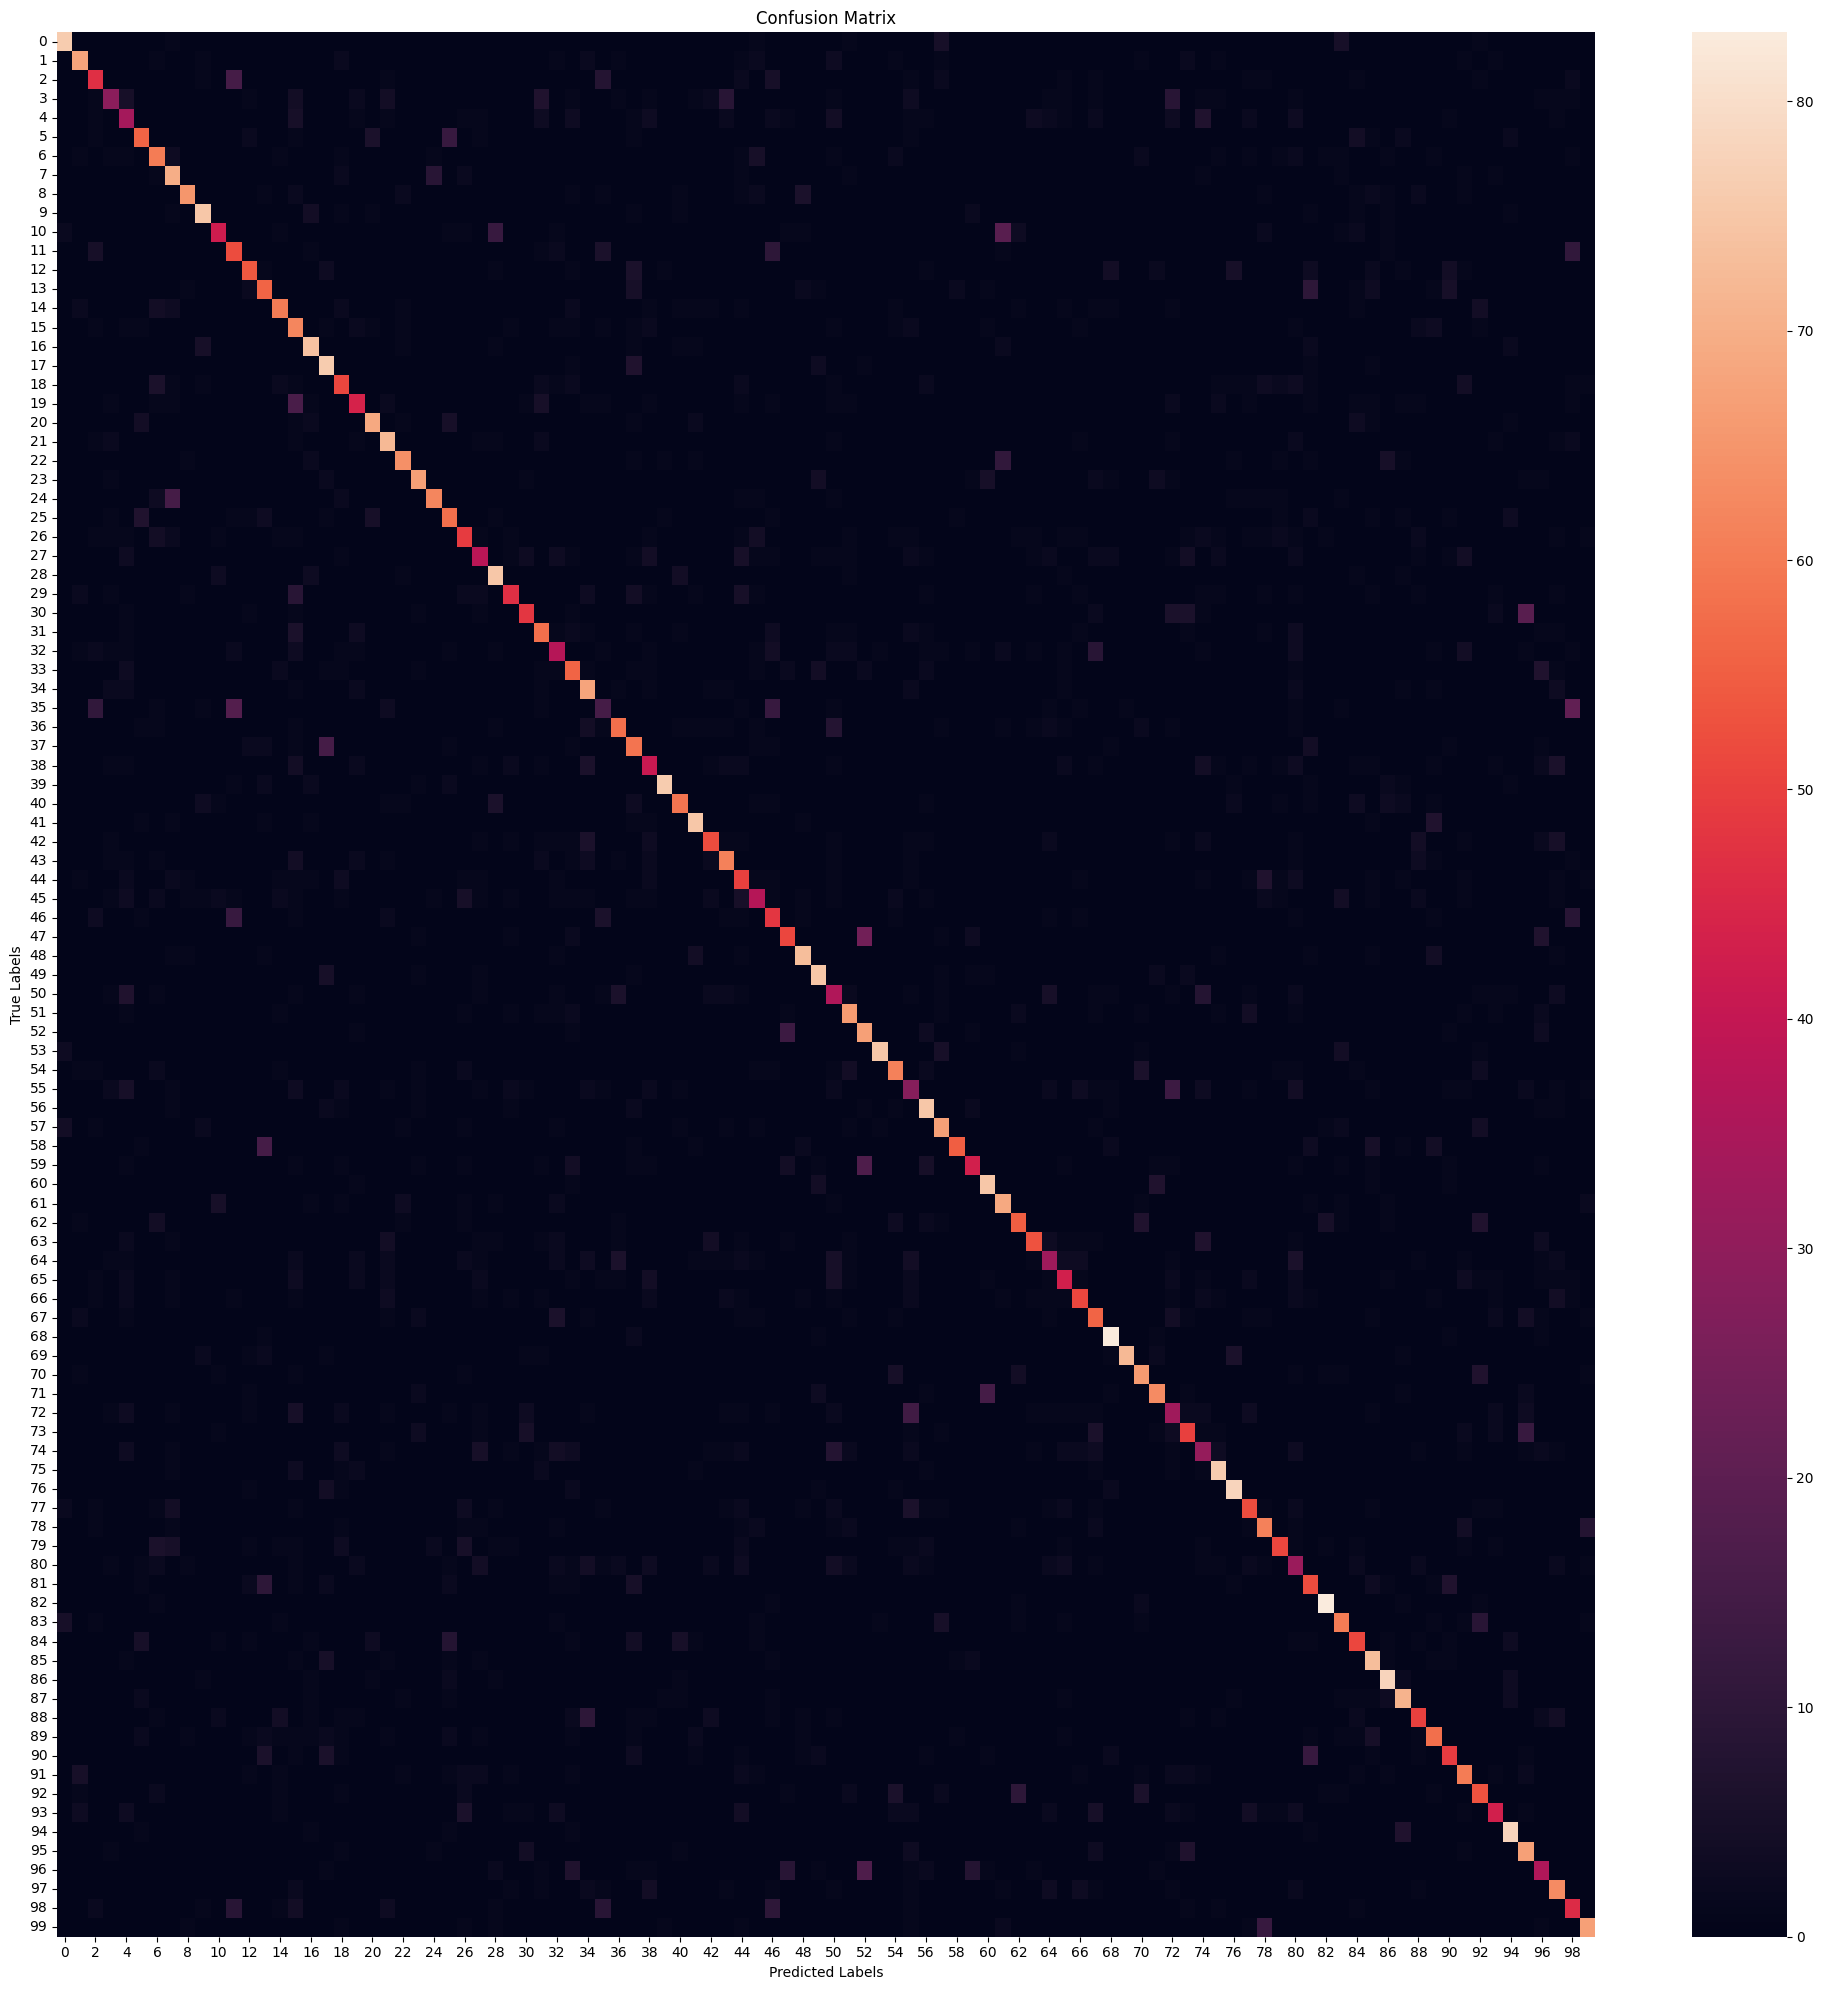

                   precision    recall  f1-score   support

           beaver       0.83      0.84      0.84        90
          dolphin       0.76      0.76      0.76        90
            otter       0.57      0.52      0.54        90
             seal       0.57      0.32      0.41        90
            whale       0.37      0.38      0.37        90
    aquarium fish       0.67      0.62      0.64        90
         flatfish       0.57      0.67      0.62        90
              ray       0.59      0.78      0.67        90
            shark       0.88      0.72      0.79        90
            trout       0.80      0.83      0.82        90
          orchids       0.71      0.47      0.56        90
          poppies       0.46      0.58      0.51        90
            roses       0.74      0.60      0.66        90
       sunflowers       0.54      0.62      0.58        90
           tulips       0.72      0.67      0.69        90
          bottles       0.39      0.69      0.50       

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 100)                 │          51,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,665,188 (94.09 MB)

 Trainable params: 1,100,388 (4.20 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/15
1313/1314 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6781 - f1_score: 0.6761 - loss: 1.0822 - precision: 0.8136
Epoch 1: val_loss improved from inf to 1.26418, saving model to best_model_fine_tune_v2.keras
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 57s 35ms/step - accuracy: 0.6781 - f1_score: 0.6761 - loss: 1.0822 - precision: 0.8137 - val_accuracy: 0.6484 - val_f1_score: 0.6466 - val_loss: 1.2642 - val_precision: 0.7936
Epoch 2/15
1312/1314 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7044 - f1_score: 0.7022 - loss: 0.9880 - precision: 0.8342
Epoch 2: val_loss improved from 1.26418 to 1.25522, saving model to best_model_fine_tune_v2.keras
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 36s 28ms/step - accuracy: 0.7044 - f1_score: 0.7022 - loss: 0.9880 - precision: 0.8342 - val_accuracy: 0.6531 - val_f1_score: 0.6515 - val_loss: 1.2552 - val_precision: 0.7943
Epoch 3/15
1312/1314 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7119 - f1_score: 0.7099 - loss: 0.9557 - precision: 0.8363
Epoch 3: v

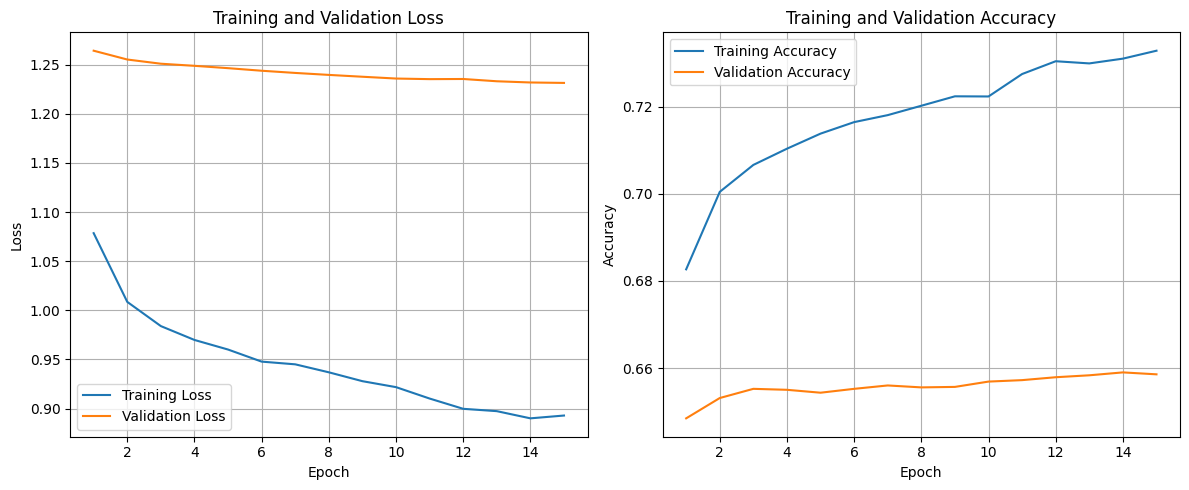

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.6510 - f1_score: 0.6435 - loss: 1.2580 - precision: 0.7801
Test Accuracy: 66.28%
Test Loss: 1.225183129310608
Test Precision: 79.53%
Test F1 Scores (Per Class): [83.14606  78.35052  52.68817  47.513805 41.807903 67.75956  62.5641
 69.27374  82.42424  79.768776 63.73626  48.235287 68.604645 61.01694
 67.44185  58.757053 77.41935  76.190475 59.66851  58.959538 81.91489
 76.041664 78.49462  81.60919  80.87432  65.89595  55.05617  50.246292
 79.329605 65.088745 64.       67.44185  55.621304 60.73298  67.02127
 35.428566 68.926544 60.63829  48.044685 91.86046  69.95074  84.7826
 65.14285  68.508286 50.82873  50.549446 51.72413  59.30232  81.72042
 82.16216  40.229874 72.222206 62.944157 88.26815  69.74358  39.999996
 83.5294   72.04301  79.51807  57.988155 82.08092  73.44632  62.76595
 67.90123  43.636356 59.770107 63.04347  65.517235 86.77248  84.44444
 68.263466 74.8663   40.46242  62.827217 39.30635  83.69564  85.86956
 58.620686 6

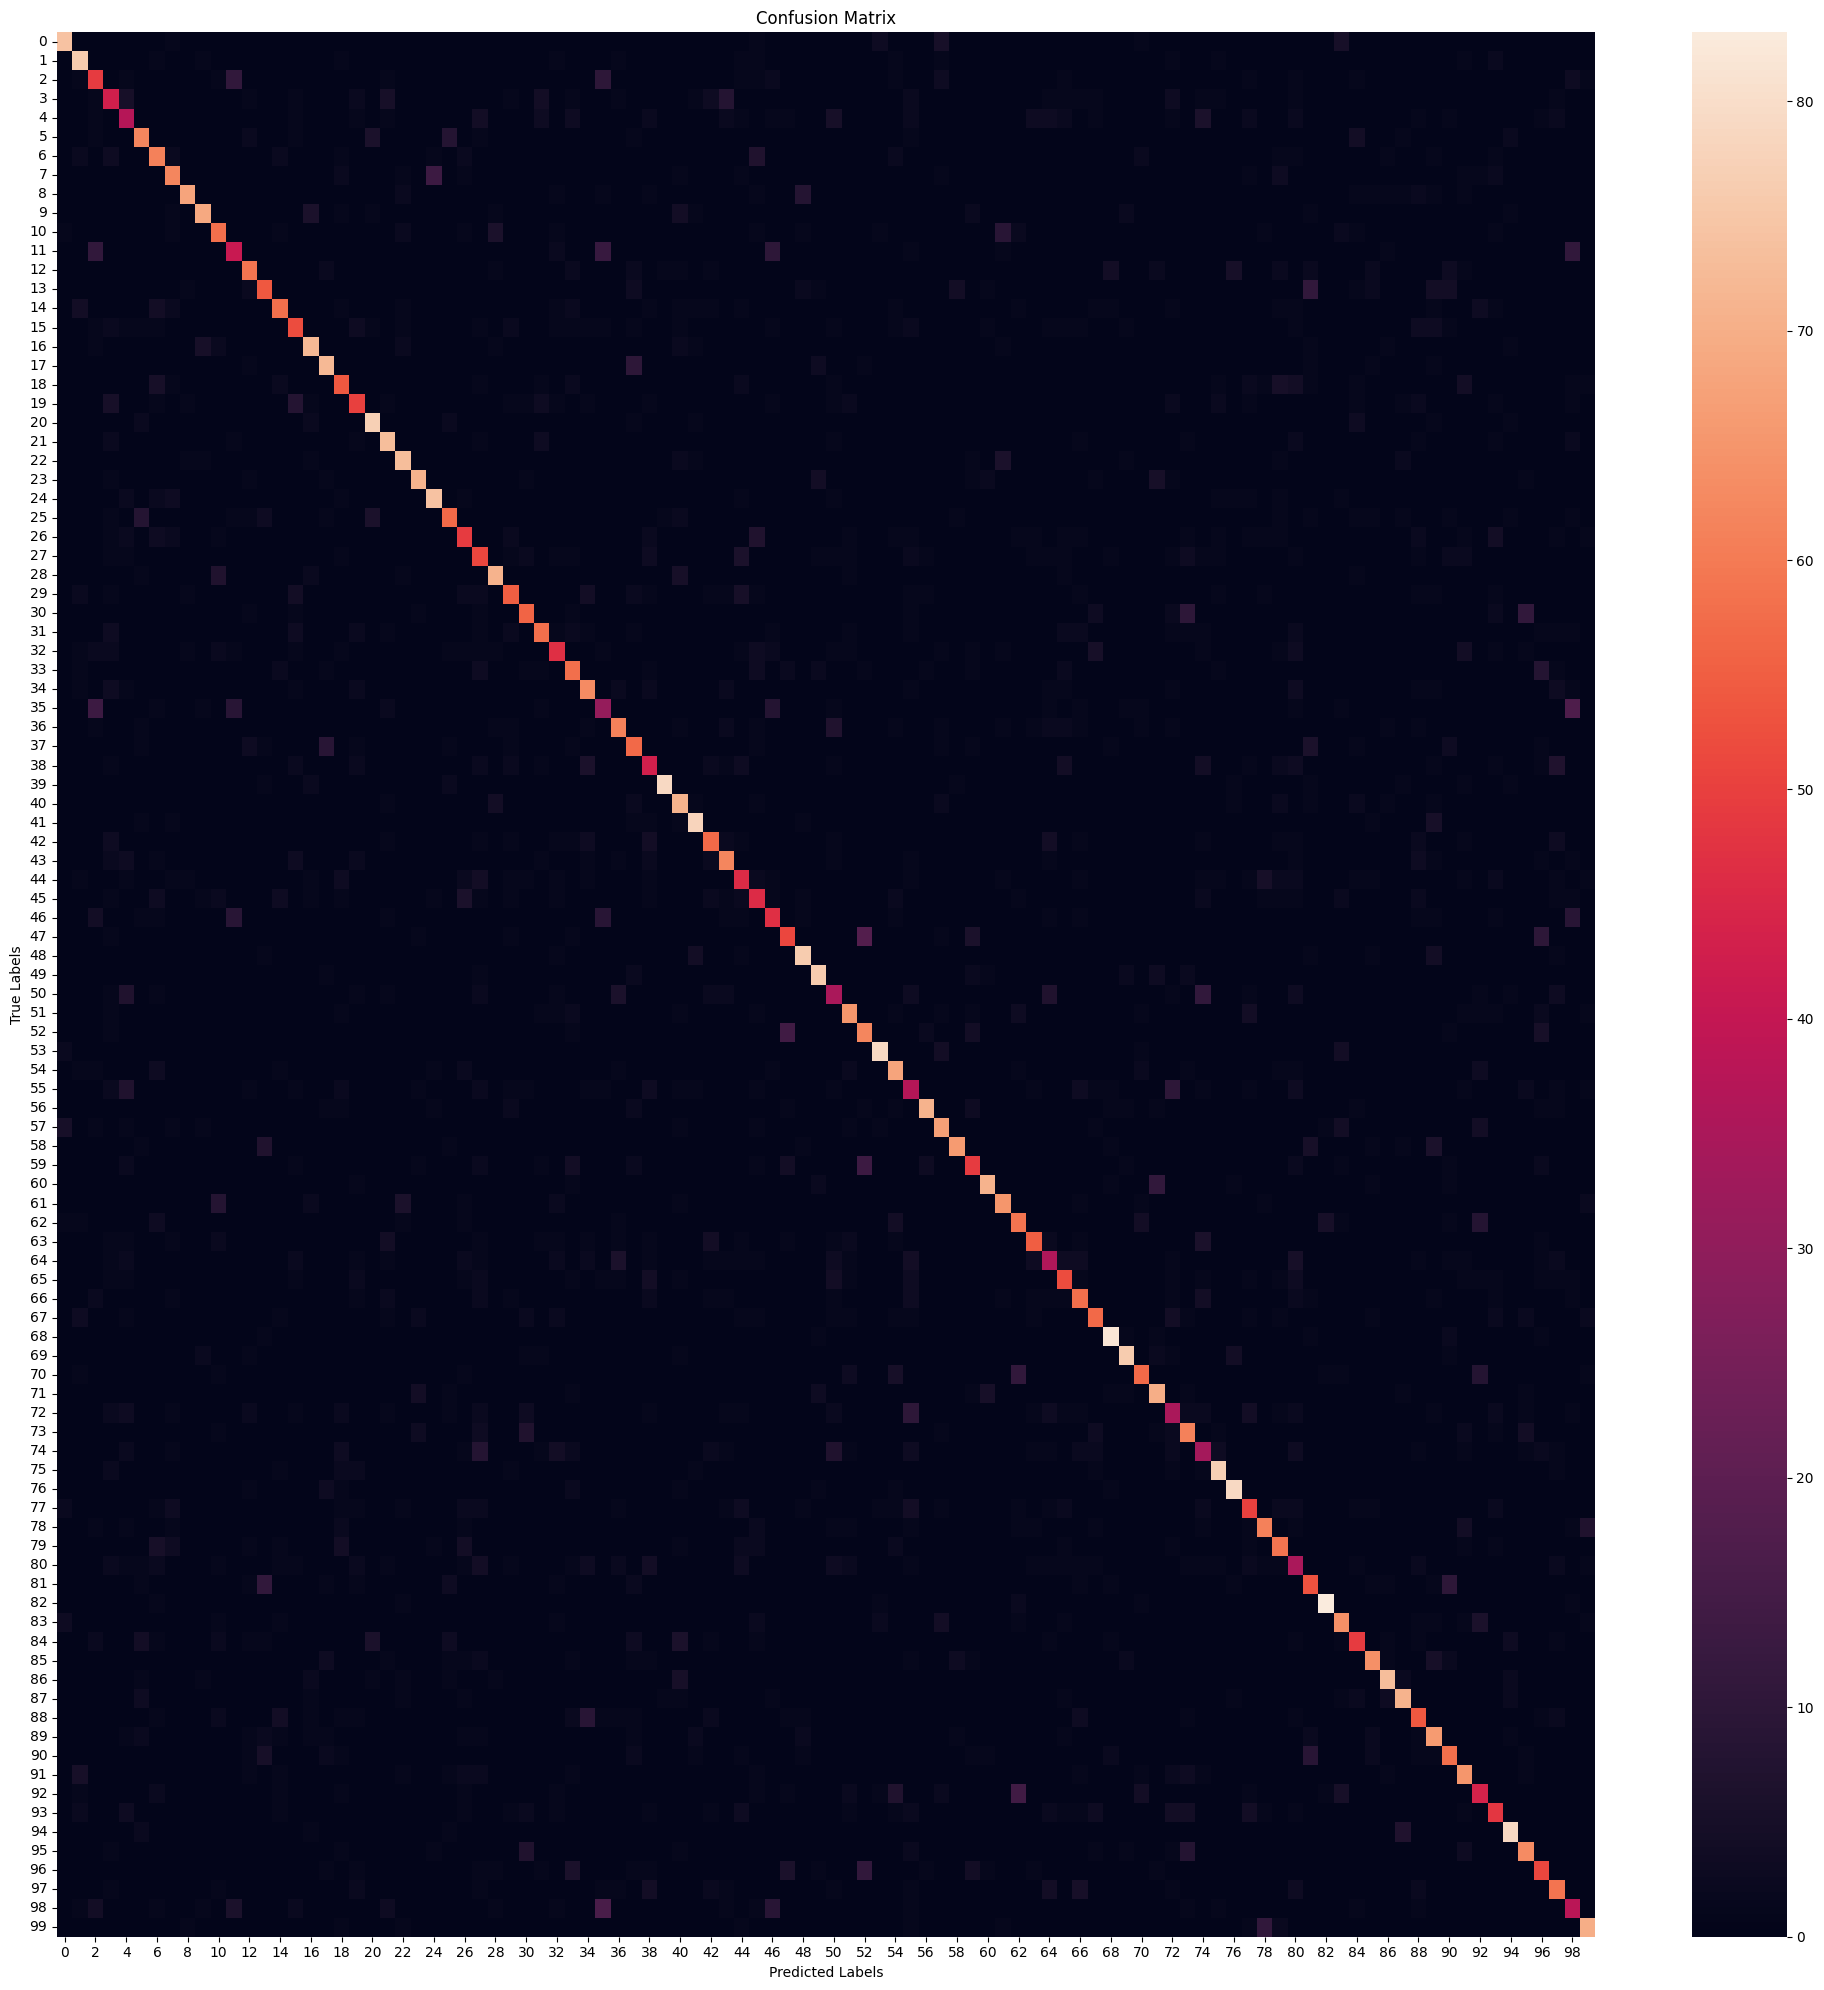

                   precision    recall  f1-score   support

           beaver       0.84      0.82      0.83        90
          dolphin       0.73      0.84      0.78        90
            otter       0.51      0.54      0.53        90
             seal       0.47      0.48      0.47        90
            whale       0.43      0.41      0.42        90
    aquarium fish       0.67      0.69      0.68        90
         flatfish       0.58      0.68      0.63        90
              ray       0.70      0.69      0.69        90
            shark       0.91      0.76      0.82        90
            trout       0.83      0.77      0.80        90
          orchids       0.63      0.64      0.64        90
          poppies       0.52      0.46      0.49        90
            roses       0.72      0.66      0.69        90
       sunflowers       0.62      0.60      0.61        90
           tulips       0.71      0.64      0.67        90
          bottles       0.60      0.58      0.59       

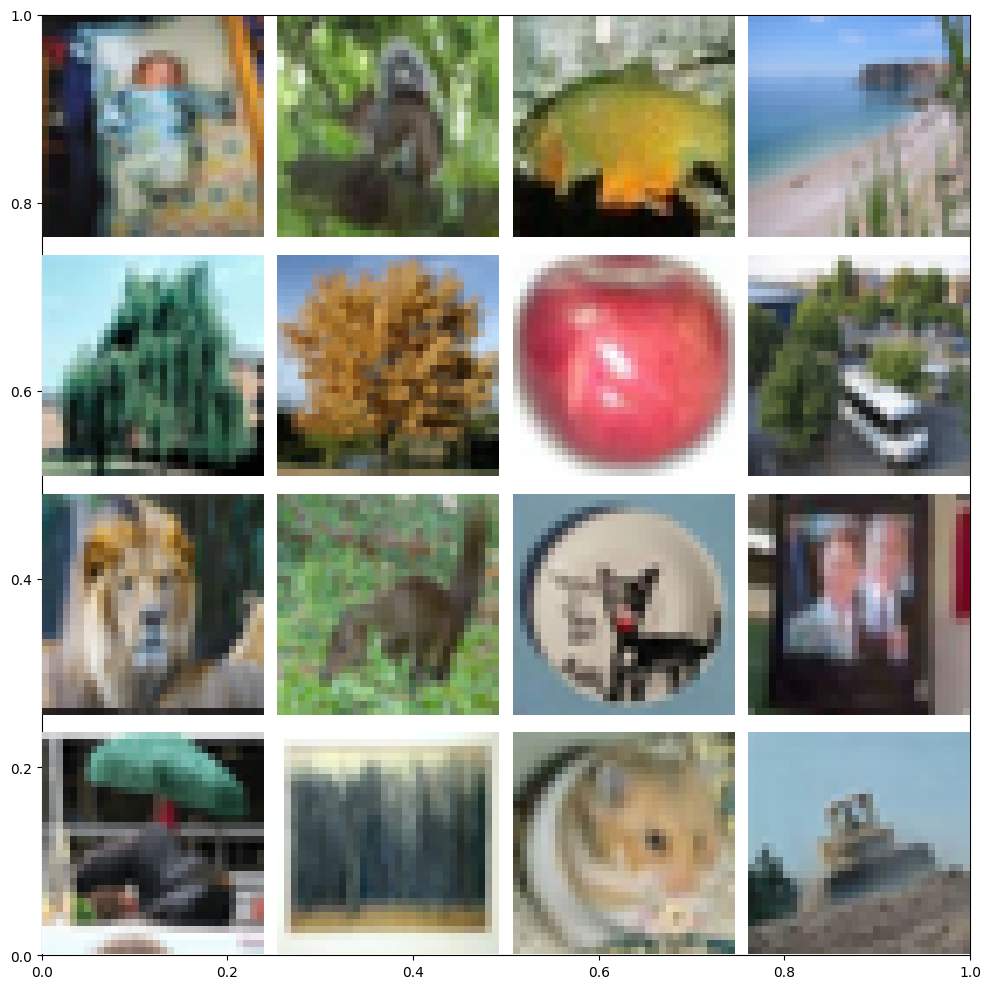

labels[24513].shape: (1,)
imgs[24513].shape: (32, 32, 3)


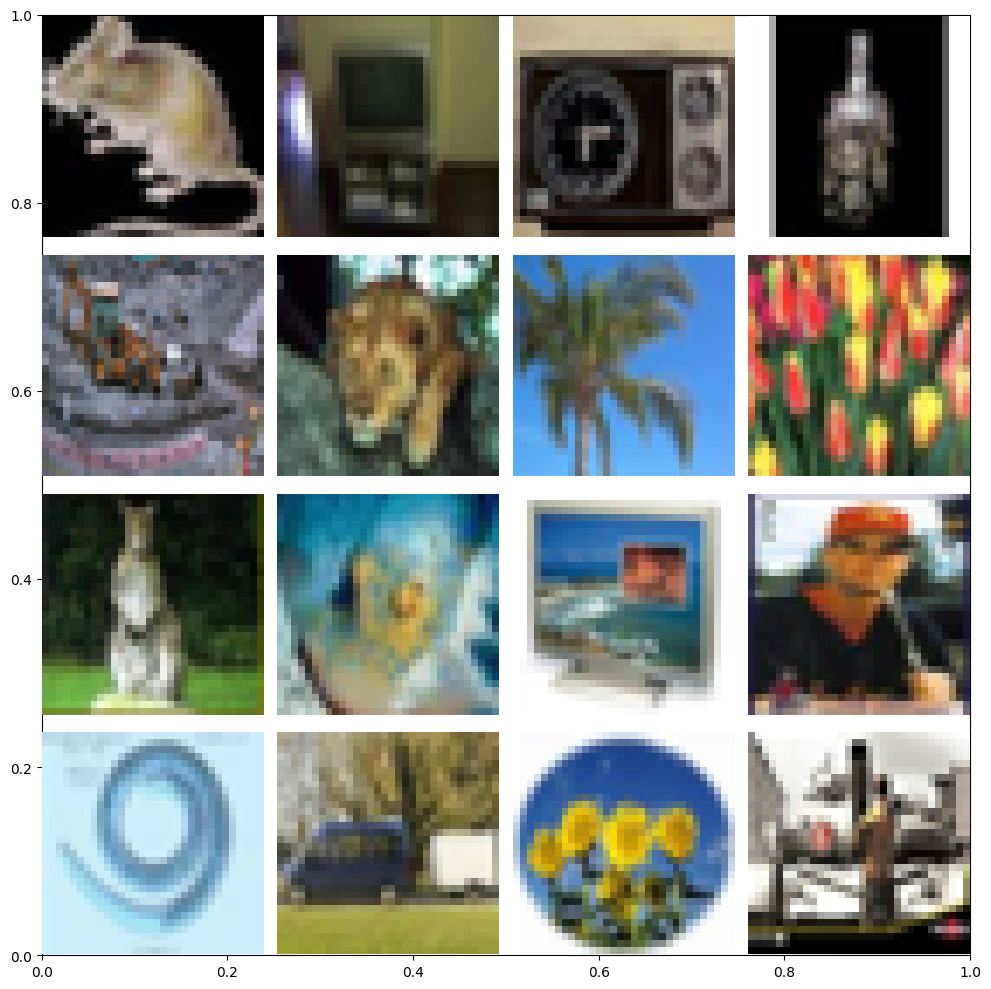

<ipython-input-4-78561581887d>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


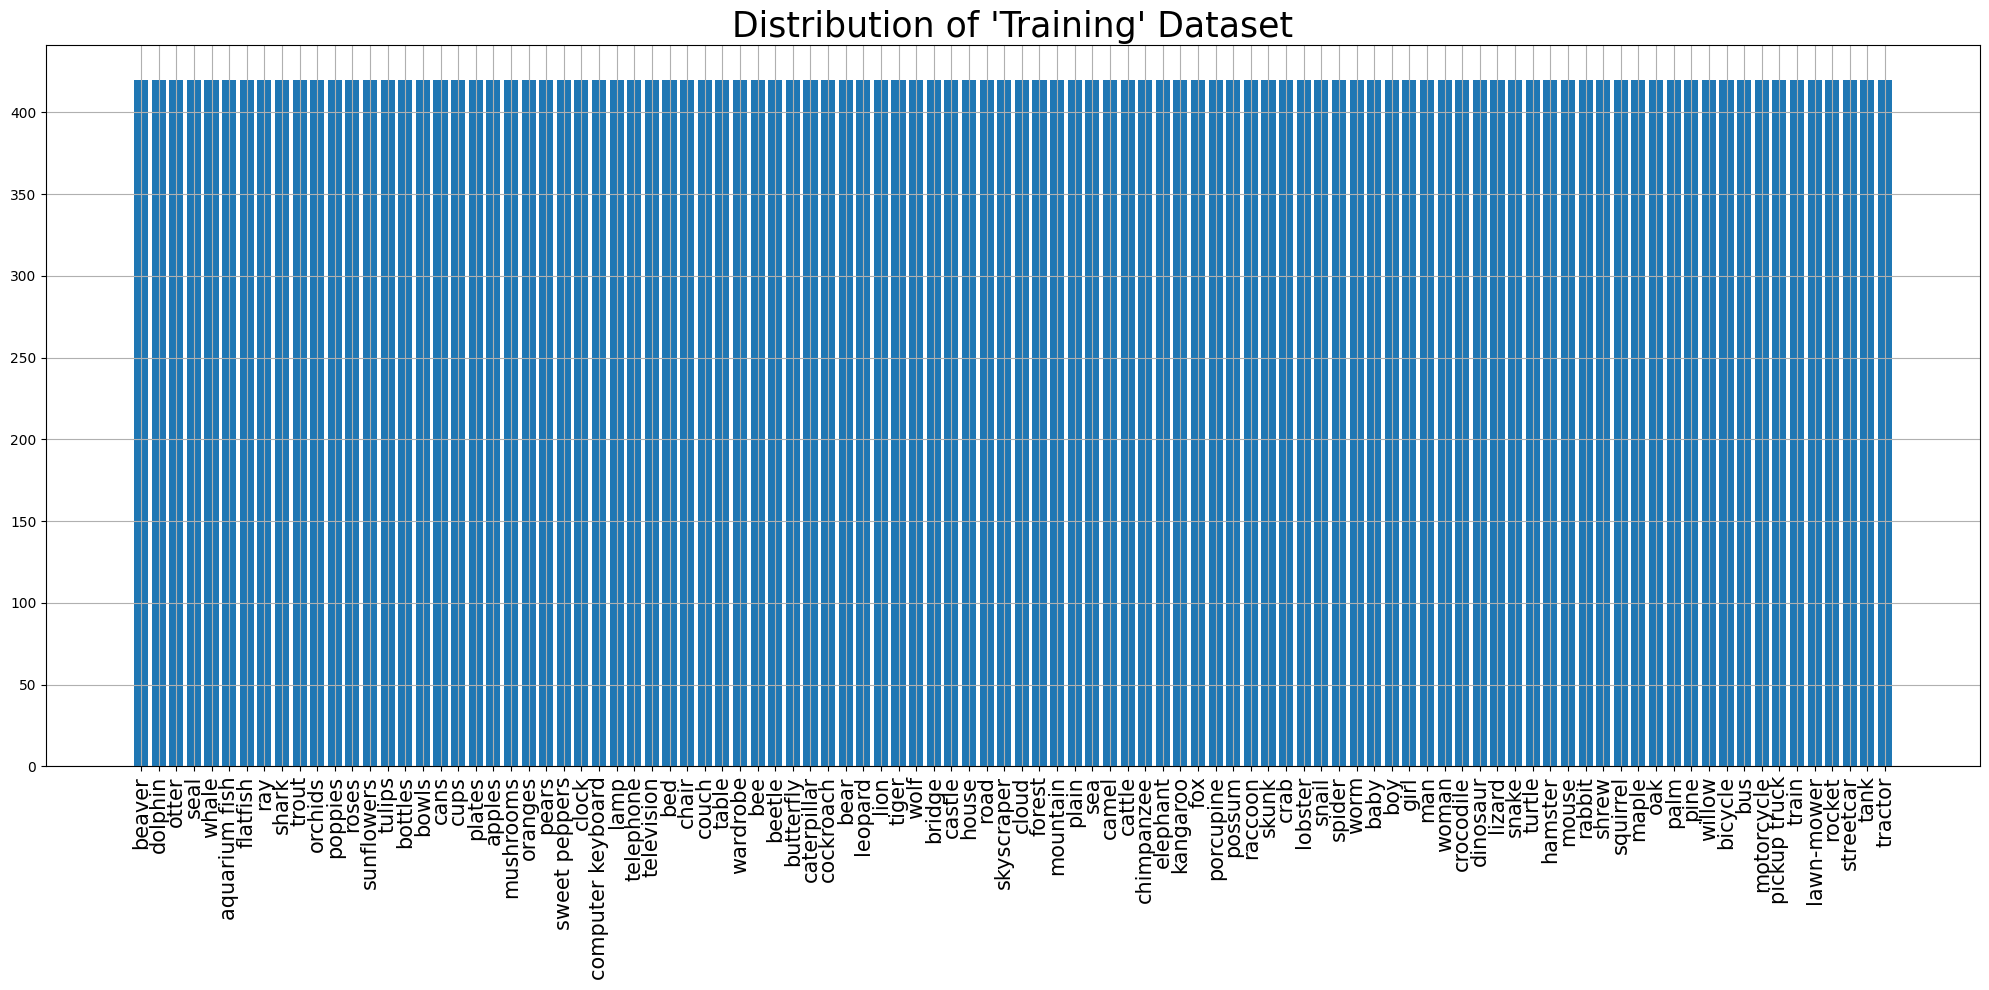

<ipython-input-4-78561581887d>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


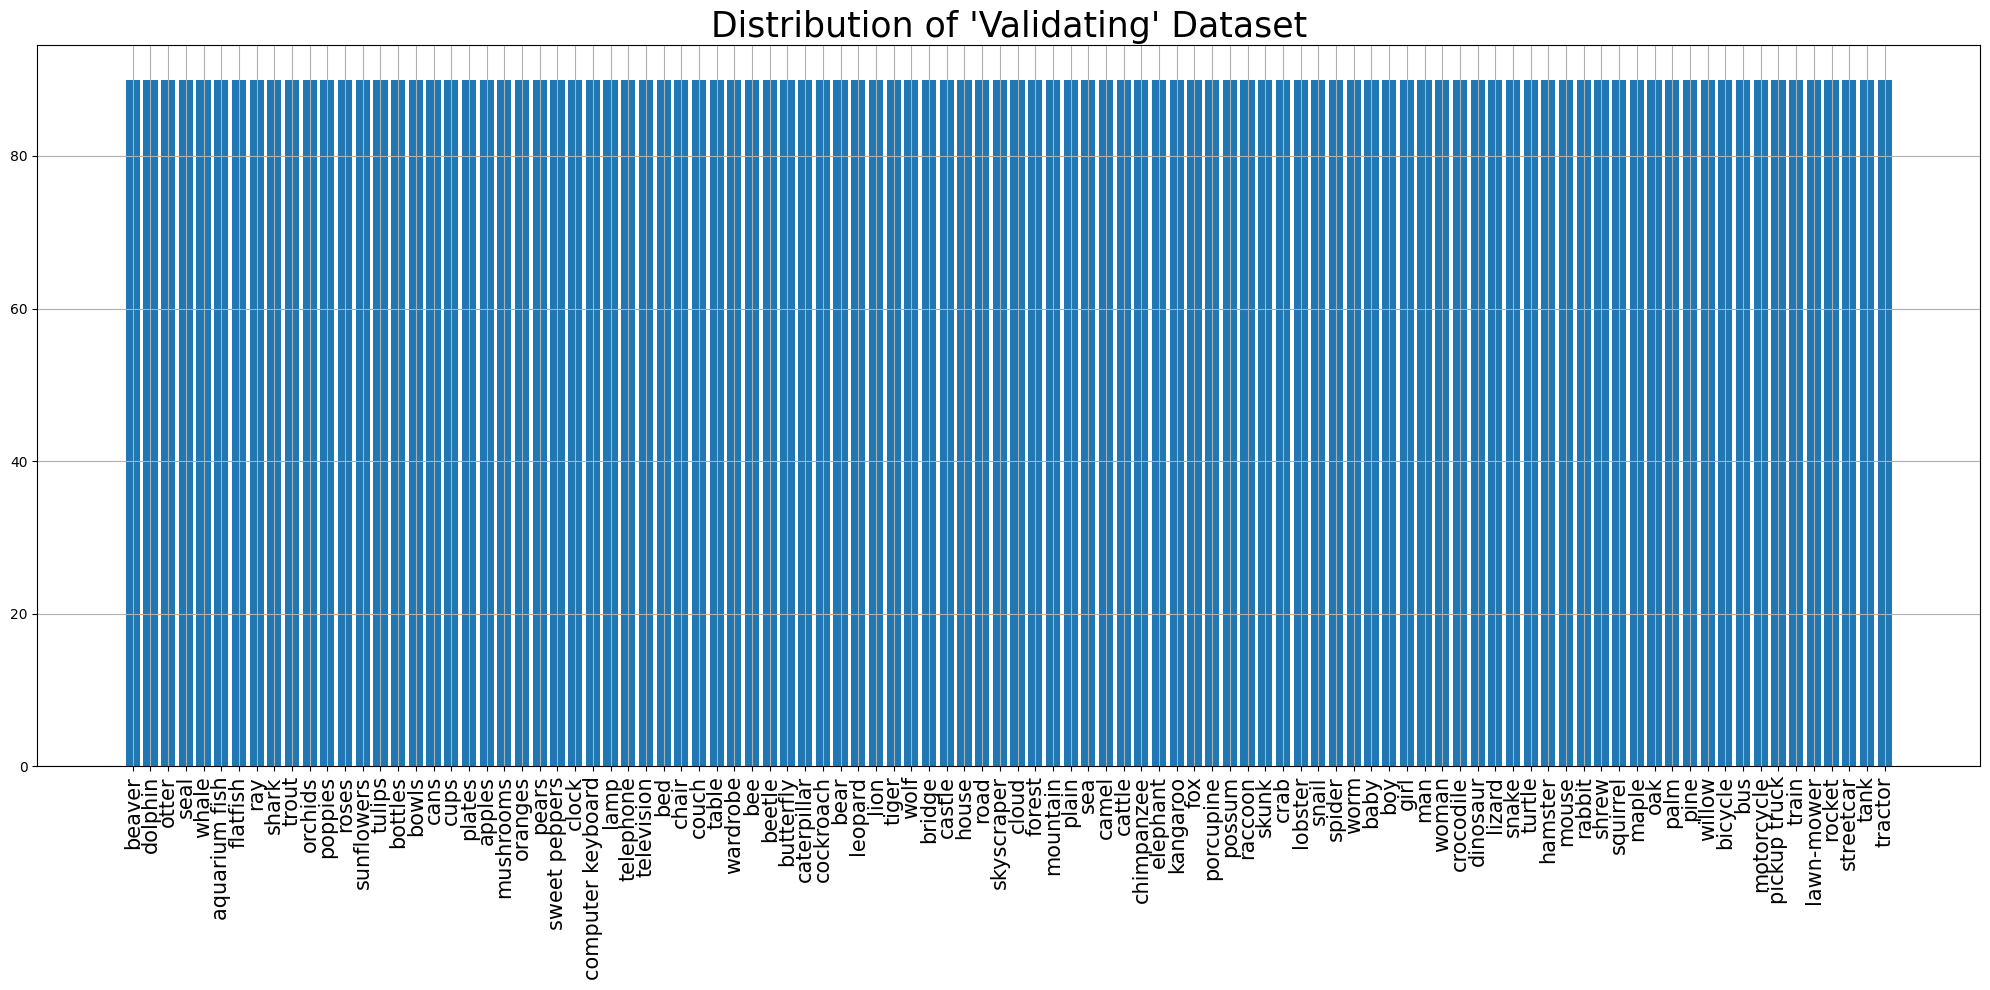

<ipython-input-4-78561581887d>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


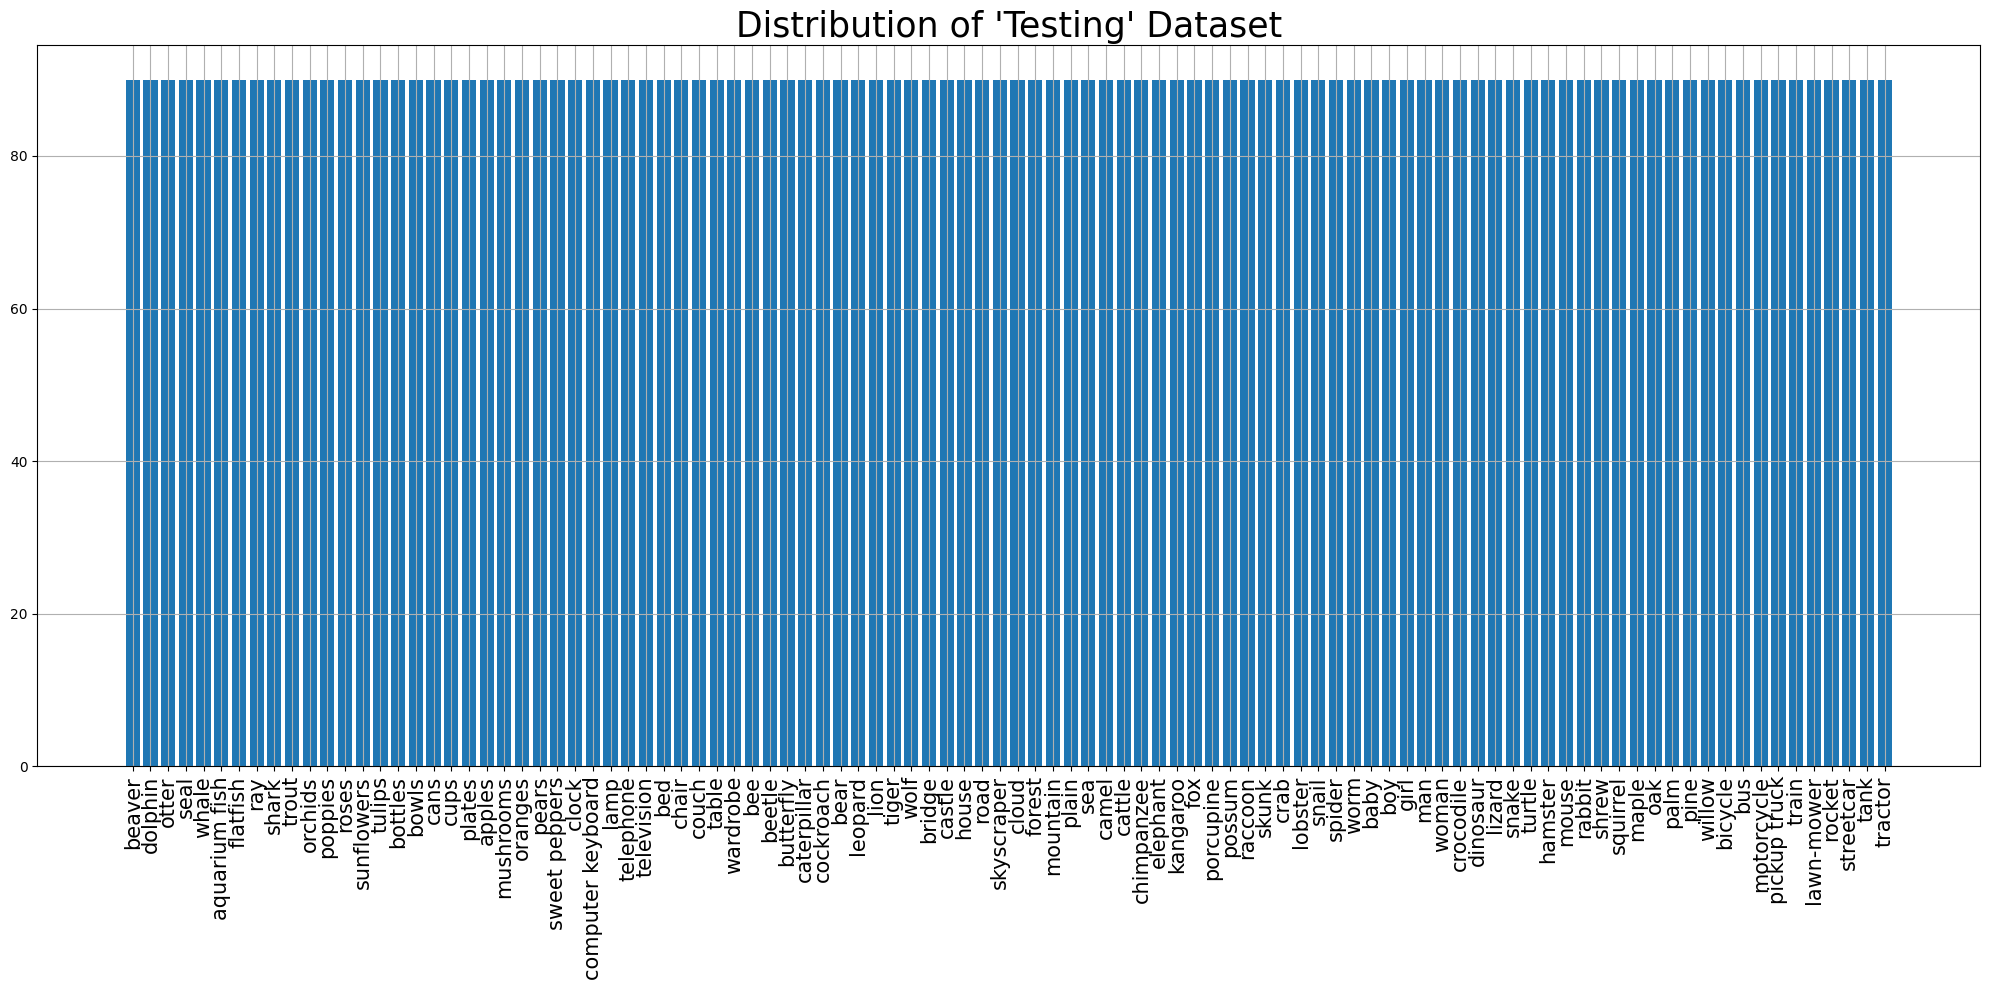

Training dataset:
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)

Validation dataset:
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)

Testing dataset:
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)
<class 'tuple'>
2
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
(64, 224, 224, 3)
(64, 100)
Model input shape: (None, 224, 224, 3)
Model output shape: (None, 100)
2
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(64, 224, 224, 3) (6

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 100)                 │          51,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,665,188 (94.09 MB)

 Trainable params: 1,100,388 (4.20 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/25
657/657 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3158 - f1_score: 0.3120 - loss: 2.9066 - precision: 0.6664
Epoch 1: val_loss improved from inf to 1.51815, saving model to best_model_v2.keras
657/657 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.3159 - f1_score: 0.3121 - loss: 2.9057 - precision: 0.6665 - val_accuracy: 0.5829 - val_f1_score: 0.5788 - val_loss: 1.5181 - val_precision: 0.8111
Epoch 2/25
656/657 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5305 - f1_score: 0.5266 - loss: 1.7396 - precision: 0.7495
Epoch 2: val_loss improved from 1.51815 to 1.40917, saving model to best_model_v2.keras
657/657 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.5305 - f1_score: 0.5266 - loss: 1.7395 - precision: 0.7495 - val_accuracy: 0.6060 - val_f1_score: 0.6011 - val_loss: 1.4092 - val_precision: 0.8091
Epoch 3/25
657/657 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5699 - f1_score: 0.5671 - loss: 1.5622 - precision: 0.7648
Epoch 3: val_loss improved from 1.40917 

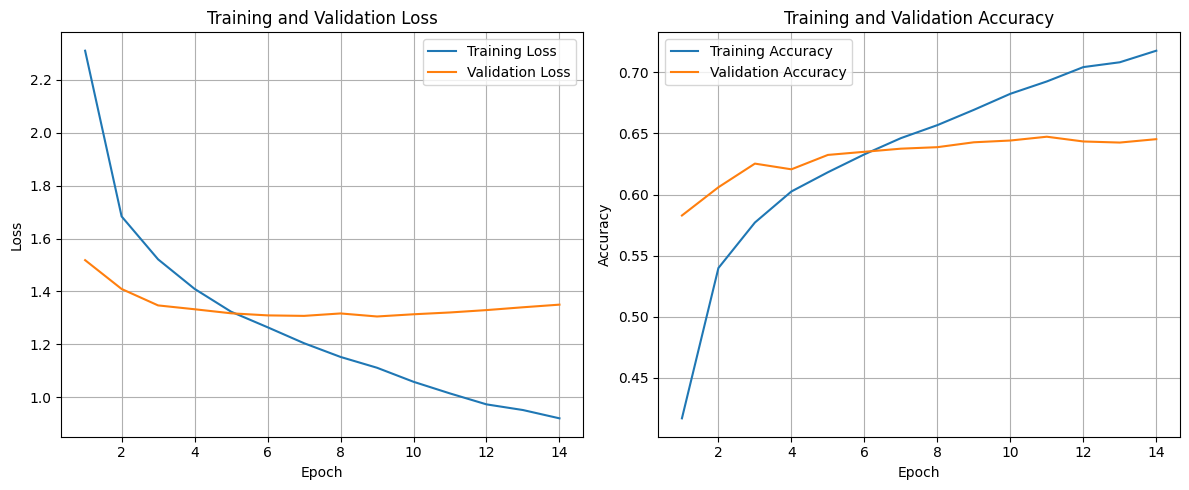

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.6294 - f1_score: 0.6204 - loss: 1.3492 - precision: 0.7660
Test Accuracy: 63.93%
Test Loss: 1.3208928108215332
Test Precision: 78.08%
Test F1 Scores (Per Class): [81.81818  76.92307  51.977394 48.684204 33.93939  61.93548  61.538452
 59.330147 79.53216  83.060104 58.278145 45.508976 65.359474 59.685856
 63.905323 60.355026 77.08333  73.63183  54.2056   60.24096  78.260864
 75.138115 77.71428  76.66666  74.03315  58.767765 51.74129  47.179485
 77.89473  66.666664 61.349686 69.99999  51.315792 60.396034 62.944157
 28.378374 67.796616 60.273968 51.497    85.86956  69.461075 78.49462
 60.52631  70.88607  44.444443 46.46464  47.663544 57.67442  80.21977
 80.87432  36.464085 69.82249  60.78431  86.904755 70.243904 36.464085
 77.83783  73.19587  78.048775 52.482265 78.88888  71.35678  65.04854
 62.032085 43.243237 54.77706  60.73298  54.05405  83.49514  85.08286
 63.013695 71.73912  34.44444  62.893074 31.746027 78.57142  81.81817
 58.0

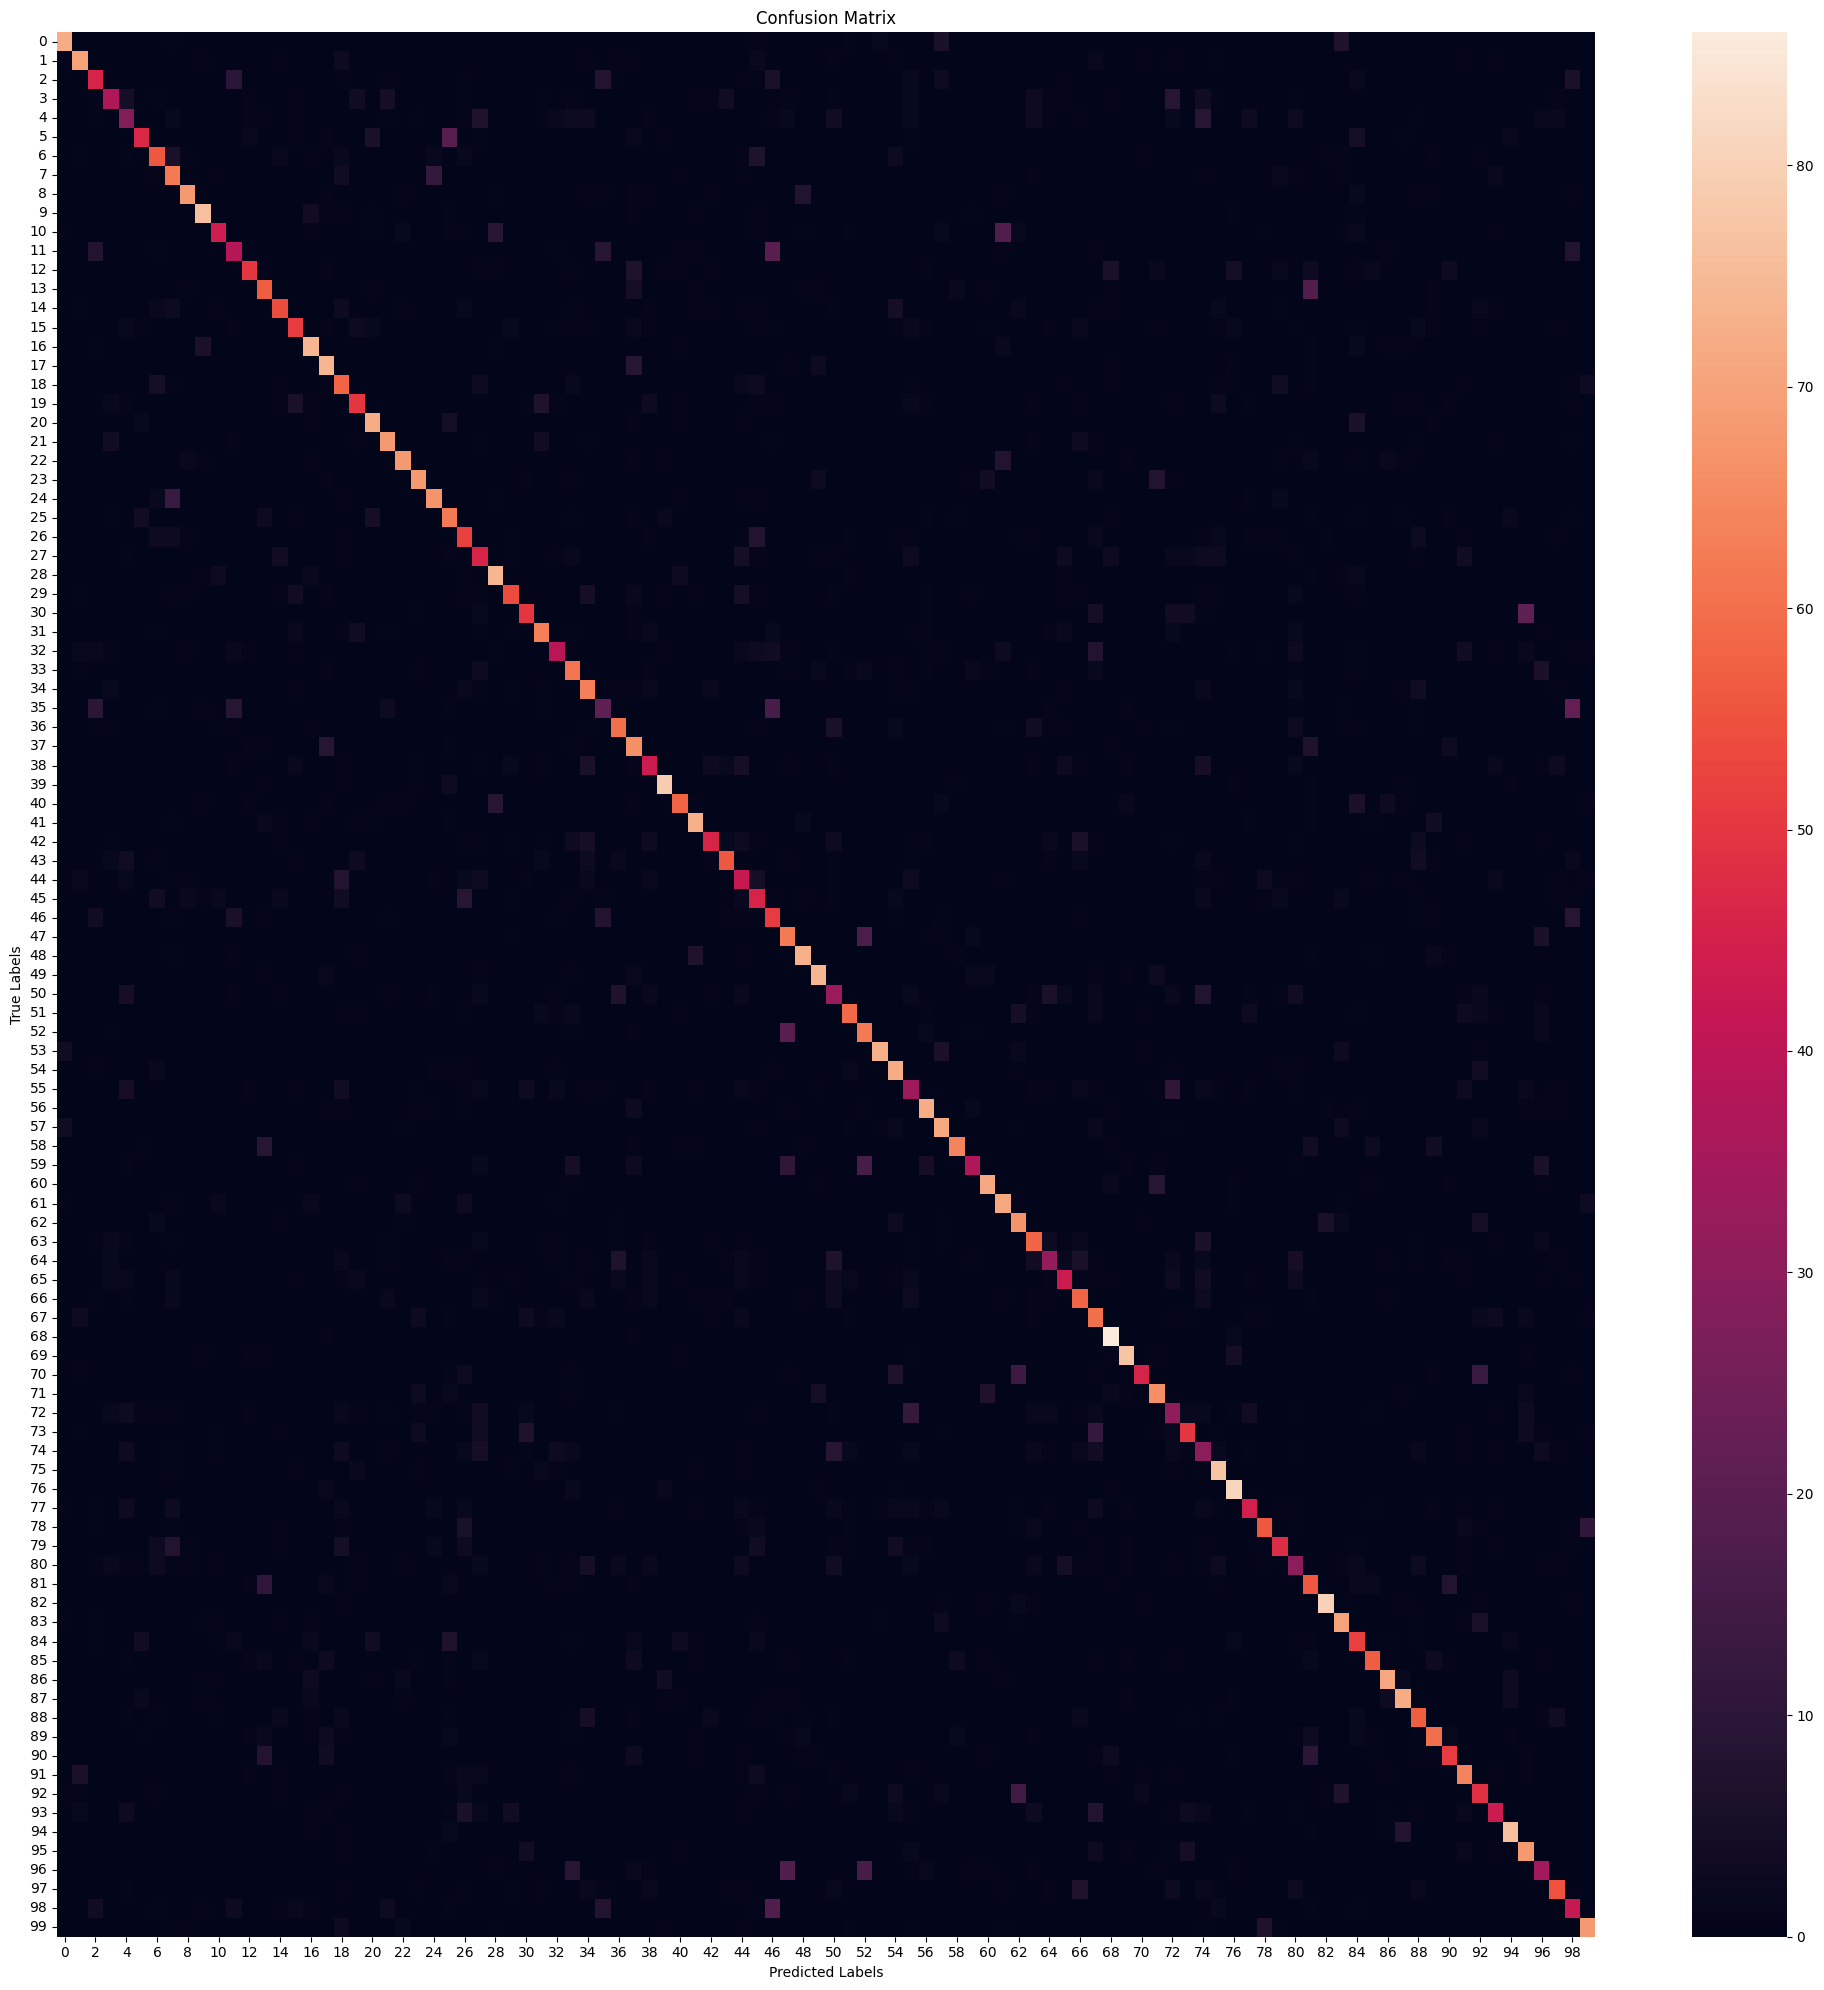

                   precision    recall  f1-score   support

           beaver       0.84      0.80      0.82        90
          dolphin       0.76      0.78      0.77        90
            otter       0.53      0.51      0.52        90
             seal       0.60      0.41      0.49        90
            whale       0.37      0.31      0.34        90
    aquarium fish       0.73      0.52      0.61        90
         flatfish       0.61      0.62      0.62        90
              ray       0.52      0.69      0.59        90
            shark       0.84      0.76      0.80        90
            trout       0.82      0.84      0.83        90
          orchids       0.72      0.49      0.58        90
          poppies       0.50      0.42      0.46        90
            roses       0.78      0.56      0.65        90
       sunflowers       0.56      0.63      0.60        90
           tulips       0.68      0.60      0.64        90
          bottles       0.65      0.57      0.60       

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 100)                 │          51,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,665,188 (94.09 MB)

 Trainable params: 1,100,388 (4.20 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/15
1312/1314 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6848 - f1_score: 0.6822 - loss: 1.0585 - precision: 0.8185
Epoch 1: val_loss improved from inf to 1.25814, saving model to best_model_fine_tune_v2.keras
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 57s 35ms/step - accuracy: 0.6848 - f1_score: 0.6822 - loss: 1.0586 - precision: 0.8185 - val_accuracy: 0.6562 - val_f1_score: 0.6554 - val_loss: 1.2581 - val_precision: 0.7968
Epoch 2/15
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7103 - f1_score: 0.7084 - loss: 0.9666 - precision: 0.8365
Epoch 2: val_loss improved from 1.25814 to 1.24949, saving model to best_model_fine_tune_v2.keras
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 36s 27ms/step - accuracy: 0.7103 - f1_score: 0.7084 - loss: 0.9666 - precision: 0.8365 - val_accuracy: 0.6564 - val_f1_score: 0.6557 - val_loss: 1.2495 - val_precision: 0.7962
Epoch 3/15
1313/1314 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7182 - f1_score: 0.7163 - loss: 0.9272 - precision: 0.8421
Epoch 3: v

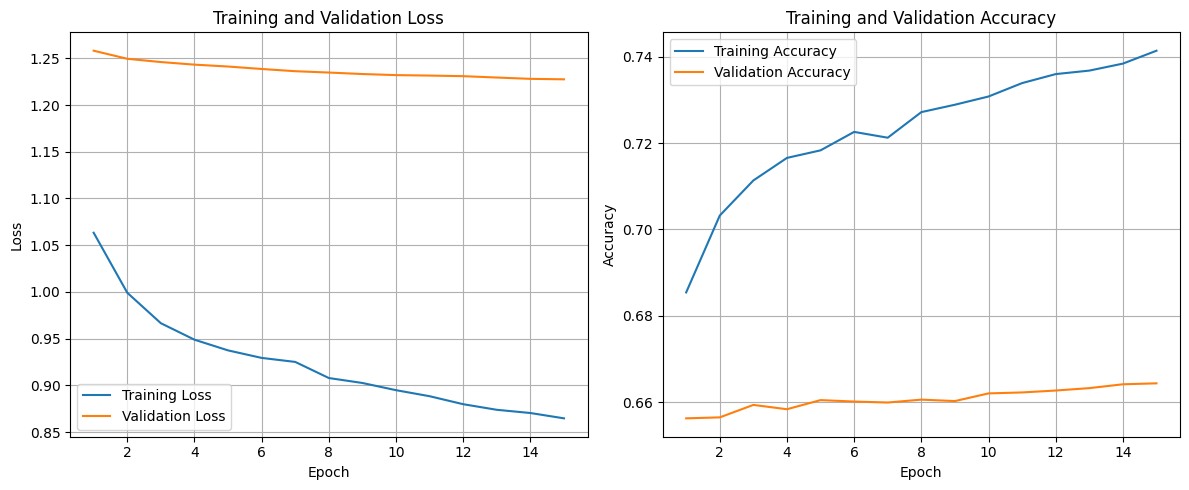

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.6514 - f1_score: 0.6439 - loss: 1.2624 - precision: 0.7851
Test Accuracy: 66.33%
Test Loss: 1.235614538192749
Test Precision: 79.41%
Test F1 Scores (Per Class): [87.49999  80.42328  55.737698 51.64835  38.150284 68.888885 63.87434
 68.13186  79.99999  84.090904 61.176468 46.15384  67.816086 61.87845
 68.208084 57.627117 78.947365 77.08333  58.959538 56.80473  82.16216
 75.89743  79.12087  79.329605 78.918915 64.739876 51.111107 48.73096
 80.       70.44025  64.77273  70.520226 51.219505 60.10362  67.3913
 34.319523 67.77777  62.499992 54.545444 89.017334 71.13402  80.87432
 63.82978  71.67629  45.026173 48.044685 46.32768  60.919537 80.20833
 80.66298  40.909084 74.157295 63.21243  90.39548  69.99999  39.3617
 82.84023  75.82417  79.51807  56.80473  78.02197  72.625694 63.04347
 67.85713  45.12195  49.71751  59.574467 65.11627  87.23404  85.41666
 70.58823  75.675674 38.787876 64.921455 36.871502 82.22221  87.91208
 59.523804 67.

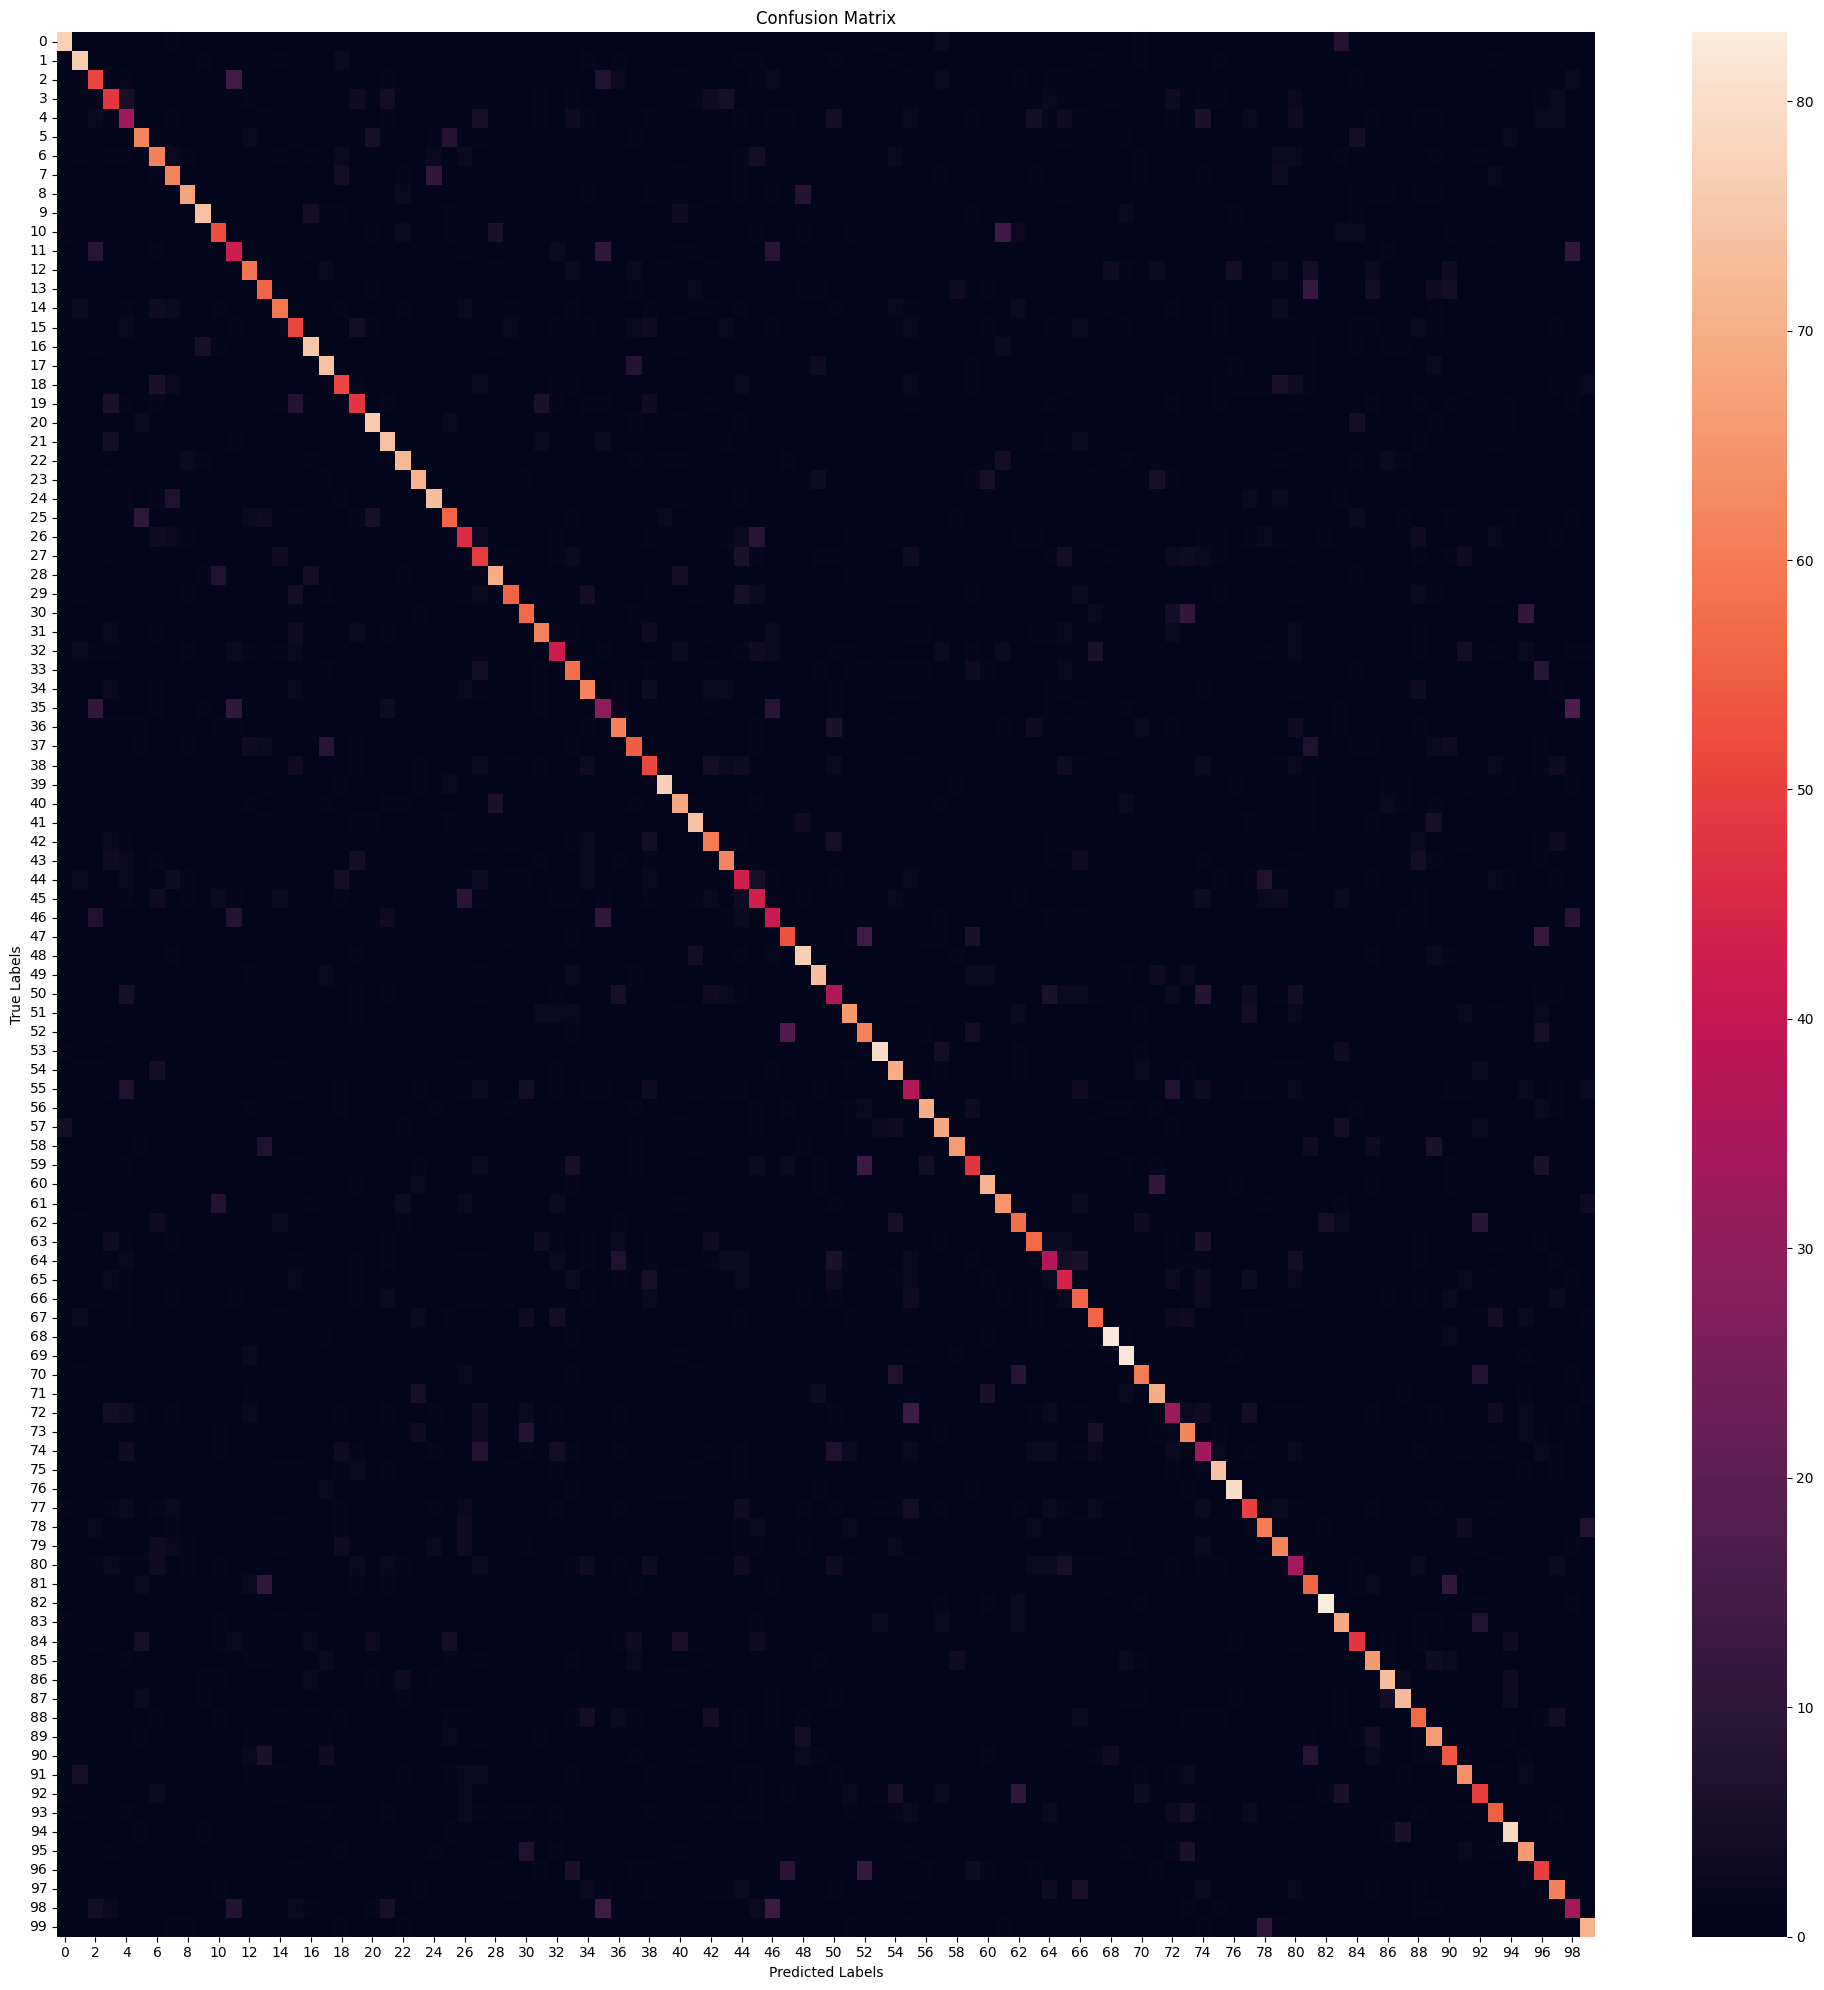

                   precision    recall  f1-score   support

           beaver       0.90      0.86      0.88        90
          dolphin       0.77      0.84      0.80        90
            otter       0.55      0.57      0.56        90
             seal       0.52      0.53      0.52        90
            whale       0.40      0.37      0.38        90
    aquarium fish       0.69      0.69      0.69        90
         flatfish       0.60      0.68      0.64        90
              ray       0.67      0.69      0.68        90
            shark       0.85      0.76      0.80        90
            trout       0.86      0.82      0.84        90
          orchids       0.65      0.58      0.61        90
          poppies       0.46      0.47      0.46        90
            roses       0.70      0.66      0.68        90
       sunflowers       0.62      0.62      0.62        90
           tulips       0.71      0.66      0.68        90
          bottles       0.59      0.57      0.58       

In [6]:
for repeat_2_times in range(2):
    #### <<<<<<<<<<Load and process data>>>>>>>>>>
    # Load CIFAR-100 dataset
    (X_train, y_train), (X_test, y_test) = cifar100.load_data(label_mode='fine')

    # Split (8000) of training data into temporary set
    X_temp, X_train, y_temp, y_train = train_test_split(X_train, y_train, test_size=0.84, stratify=y_train, random_state=42)
    print(f"X_temp.shape: {X_temp.shape}\n")

    # Split temp data into equal validation (4000) and testing (4000) data
    X_temp_val, X_temp_test, y_temp_val, y_temp_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
    print(f"X_temp_val.shape: {X_temp_val.shape}")
    print(f"y_temp_val.shape: {y_temp_val.shape}")
    print(f"X_temp_test.shape: {X_temp_test.shape}")
    print(f"y_temp_test.shape: {y_temp_test.shape}\n")

    # Split test data into validation (5000) and testing (5000)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)

    # Add temp_val to validation (9000) and temp_test to testing (9000) to get a 70/15/15 data split
    X_val = np.concatenate((X_val, X_temp_val), axis=0)
    y_val = np.concatenate((y_val, y_temp_val), axis=0)
    X_test = np.concatenate((X_test, X_temp_test), axis=0)
    y_test = np.concatenate((y_test, y_temp_test), axis=0)

    print(f"X_train.shape: {X_train.shape}")
    print(f"y_train.shape: {y_train.shape}")
    print(f"X_val.shape: {X_val.shape}")
    print(f"y_val.shape: {y_val.shape}")
    print(f"X_test.shape: {X_test.shape}")
    print(f"y_test.shape: {y_test.shape}\n")

    display_imgs(X_train, y_train)

    # Normalise images (scale to range [0, 1]) - Improves convergence speed & accuracy
    X_train, X_val, X_test = X_train / 255.0, X_val / 255.0, X_test / 255.0
    display_imgs(X_train, y_train)

    labels_names = ['beaver','dolphin','otter','seal','whale','aquarium fish','flatfish','ray','shark','trout',
                   'orchids','poppies','roses','sunflowers','tulips','bottles','bowls','cans','cups','plates',
                   'apples','mushrooms','oranges','pears','sweet peppers','clock','computer keyboard','lamp',
                   'telephone','television','bed','chair','couch','table','wardrobe','bee','beetle','butterfly',
                   'caterpillar','cockroach','bear','leopard','lion','tiger','wolf','bridge','castle','house',
                   'road','skyscraper','cloud','forest','mountain','plain','sea','camel','cattle','chimpanzee',
                   'elephant','kangaroo','fox','porcupine','possum','raccoon','skunk','crab','lobster','snail',
                   'spider','worm','baby','boy','girl','man','woman','crocodile','dinosaur','lizard','snake',
                   'turtle','hamster','mouse','rabbit','shrew','squirrel','maple','oak','palm','pine','willow',
                   'bicycle','bus','motorcycle','pickup truck','train','lawn-mower','rocket','streetcar','tank',
                   'tractor']

    class_distrib(y_train, labels_names, "Training")
    class_distrib(y_val, labels_names, "Validating")
    class_distrib(y_test, labels_names, "Testing")

    # Create TensorFlow datasets

    batch_size = 64

    train_dataset_ = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
                     .map(lambda x, y: (tf.image.resize(x, (224, 224)),
                                        tf.squeeze(tf.one_hot(y, depth=100, dtype=tf.float32))))  # Remove extra dimension
                     .batch(batch_size)
                     .prefetch(tf.data.experimental.AUTOTUNE))

    # DEBUG augment
    #train_dataset_aug = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
    #                 .map(augment_dataset, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    #                 .batch(batch_size)
    #                 .prefetch(tf.data.experimental.AUTOTUNE))

    # Combine the original dataset and the augmented dataset
    train_dataset = train_dataset_#.concatenate(train_dataset_aug)

    val_dataset = (tf.data.Dataset.from_tensor_slices((X_val, y_val))
                   .map(lambda x, y: (tf.image.resize(x, (224, 224)),
                                      tf.squeeze(tf.one_hot(y, depth=100, dtype=tf.float32))))  # Remove extra dimension
                   .batch(batch_size)
                   .prefetch(tf.data.experimental.AUTOTUNE))

    test_dataset = (tf.data.Dataset.from_tensor_slices((X_test, y_test))
                     .map(lambda x, y: (tf.image.resize(x, (224, 224)),
                                        tf.squeeze(tf.one_hot(y, depth=100, dtype=tf.float32))))  # Remove extra dimension
                    .batch(batch_size)
                    .prefetch(tf.data.experimental.AUTOTUNE))

    print(f"Training dataset:\n {train_dataset}")
    for img, lbl in train_dataset.take(1):
        #if isinstance(batch, tuple) and len(batch) == 2:
        print(f"Image shape: {img.shape}")  # Should be (batch_size, 224, 224, 3)
        print(f"Label shape: {lbl.shape}")  # Should be (batch_size, 10)
        del img,lbl
    print(f"\nValidation dataset:\n {val_dataset}")
    for img, lbl in val_dataset.take(1):
        #if isinstance(batch, tuple) and len(batch) == 2:
        print(f"Image shape: {img.shape}")  # Should be (batch_size, 224, 224, 3)
        print(f"Label shape: {lbl.shape}")  # Should be (batch_size, 10)
        del img,lbl
    print(f"\nTesting dataset:\n {test_dataset}")
    for img, lbl in test_dataset.take(1):
        #if isinstance(batch, tuple) and len(batch) == 2:
        print(f"Image shape: {img.shape}")  # Should be (batch_size, 224, 224, 3)
        print(f"Label shape: {lbl.shape}")  # Should be (batch_size, 10)
        del img,lbl


    #### <<<<<<<<<<Pre-trained model>>>>>>>>>>
    # Load ResNet50 pre-trained on ImageNet (w/out the top classification layer which is designed for ImageNet (diff dataset))
    resnet_50_base = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the layers of VGG16 so they don't get updated during training - can unfreeze for fine tuning later
    resnet_50_base.trainable = False

    for layer in resnet_50_base.layers:
        if isinstance(layer, tf.keras.layers.Conv2D):
            layer.kernel_regularizer = tf.keras.regularizers.l2(3e-2) # DEBUG l2

    # Add custom classification layers for CIFAR-100 (100 classes) - adapt model to CIFAR-100
    model = models.Sequential([
        resnet_50_base,
        layers.GlobalAveragePooling2D(), # Better for ResNet than Flatten
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.6), # DEBUG dropout
        layers.Dense(100, activation='softmax')  # CIFAR-100 has 100 classes
    ])

    for sample in test_dataset.take(1):
        print(type(sample))  # Should be <class 'tuple'>
        print(len(sample))  # Should be 2
        print(type(sample[0]), type(sample[1]))  # Both should be <class 'tensorflow.Tensor'>
        print(sample[0].shape)  # Should be (batch_size, 224, 224, 3)
        print(sample[1].shape)  # Should be (batch_size, 100)
    print(f"Model input shape: {model.input_shape}")
    print(f"Model output shape: {model.output_shape}")
    sample = next(iter(test_dataset.as_numpy_iterator()))
    print(len(sample))  # Should be 2
    print(type(sample[0]), type(sample[1]))  # Both should be <class 'numpy.ndarray'>
    print(sample[0].shape, sample[1].shape)  # Should match model input and output
    print("\n")
    #for x, y in test_dataset.take(1):
    #    print(type(x), type(y))  # Both should be <class 'tensorflow.Tensor'>
    #for x_batch, y_batch in test_dataset.take(1):
    #    test_loss, test_acc = model.evaluate(x_batch, y_batch)
    #    print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

    # Compile the model
    #tensorboard_callback = keras.callbacks.TensorBoard(log_dir="./logs")
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-3, weight_decay=3e-2), # DEBUG weight
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'precision', 'f1_score'])

    model.summary()

    #### <<<<<<<<<<Train Model & Track Training/Validation Error>>>>>>>>>>
    early_stopping = EarlyStopping(monitor='val_loss', # or val_accuracy
                                   patience=5, # Num. epochs with no improvements - help void overfitting
                                   restore_best_weights=True)
    #reduce_lr = ReduceLROnPlateau(monitor='val_loss', # or val_accuracy
    #                              factor=0.1, # Reduce lr by a factor
    #                              patience=3, # Num epochs w/ no improvement
    #                              min_lr=1e-6, # Min lr
    #                              verbose=1)
    #tensorboard = TensorBoard(log_dir='./logs', # Logs directory
    #                         histogram_freq=1, # Logs histograms for weights/activations
    #                         write_graph=True, # Logs graph of model
    #                         write_images=True) # Log images like weight histogram
    checkpoint = ModelCheckpoint('best_model_v2.keras', # Path where the best model will be saved
                                 monitor='val_loss', # What to monitor (validation loss)
                                 save_best_only=True, # Only save model when validation loss improves
                                 mode='min', # Looking to minimse the validation loss
                                 verbose=1) # Print out message when saving model
    checkpoint_fine_tune = ModelCheckpoint('best_model_fine_tune_v2.keras', # Path where the best model will be saved
                                 monitor='val_loss', # What to monitor (validation loss)
                                 save_best_only=True, # Only save model when validation loss improves
                                 mode='min', # Looking to minimse the validation loss
                                 verbose=1) # Print out message when saving model
    #cvs_logger = CSVLogger('training_log.csv', seperator=',', append=True) # Save train metrics to analyse

    # Train the model
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=25,
                        batch_size=batch_size, callbacks=[early_stopping, checkpoint], verbose=1)

    #### <<<<<<<<<<Plot Training & Validation Error>>>>>>>>>>

    # Extract loss and accuracy
    epochs = range(1,len(history.history['loss'])+1)
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    plot_evidence(epochs, train_loss, val_loss, train_acc, val_acc)

    #### <<<<<<<<<<Evaluate Model on Test Data>>>>>>>>>>

    # Evaluate on test data
    model = load_model('best_model_v2.keras')
    results = model.evaluate(test_dataset)
    test_loss = results[0]
    test_acc = results[1]
    test_precision = results[2]
    test_f1_scores = results[3]
    print(f"Test Accuracy: {test_acc*100:.2f}%")
    print(f"Test Loss: {test_loss}")
    print(f"Test Precision: {test_precision*100:.2f}%")
    print(f"Test F1 Scores (Per Class): {test_f1_scores.numpy()*100}")
    print(f"Average Test F1 Scores:{np.average(test_f1_scores.numpy()*100):.2f}\n")

    #### <<<<<<<<<<Generate Confusion Matrix>>>>>>>>>>

    # Get predictions
    X_test_revised = tf.image.resize(X_test, (224, 224))
    y_pred = model.predict(X_test_revised)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = y_test.flatten()

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

    # Plot confusion matrix
    plt.figure(figsize=(20, 20))
    sns.heatmap(conf_matrix) #cmap='Blues', fmt='d'
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    print(classification_report(y_true_classes, y_pred_classes, target_names=labels_names))
    #tensorboard --logdir==path_to_your_logs

    # Create a DataFrame from the history of the training and store the epoch values.
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    # Finally, display the hist DataFrame.
    hist

    #### <<<<<<<<<<Fine-Tune>>>>>>>>>>
    # Adapt Model
    for layer in resnet_50_base.layers:
        layer.trainable = True # Allow layers to be updated

    # Compile again w/ lower learning rate (prevents destroying learned features)
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'precision', 'f1_score'])

    model.summary()

    #### <<<<<<<<<<Modify Dataset>>>>>>>>>>


    # DEBUG augment
    train_dataset_aug_ = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
                     .map(augment_dataset, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                     .batch(batch_size)
                     .prefetch(tf.data.experimental.AUTOTUNE))

    # Combine the original dataset and the augmented dataset
    train_dataset_aug = train_dataset.concatenate(train_dataset_aug_) # Not val or test as augment train helps generalise better, but want to provide consistent benchmark for eval perf

    #### <<<<<<<<<<Train Model & Track Training/Validation Error>>>>>>>>>>

    # Train the model
    history_fine_tune = model.fit(train_dataset_aug, validation_data=val_dataset, epochs=15,
                                  batch_size=batch_size, callbacks=[early_stopping, checkpoint_fine_tune], verbose=1)

    #### <<<<<<<<<<Plot Training & Validation Error>>>>>>>>>>

    # Extract loss and accuracy
    epochs = range(1,len(history_fine_tune.history['loss'])+1)
    train_loss = history_fine_tune.history['loss']
    val_loss = history_fine_tune.history['val_loss']
    train_acc = history_fine_tune.history['accuracy']
    val_acc = history_fine_tune.history['val_accuracy']

    plot_evidence(epochs, train_loss, val_loss, train_acc, val_acc)

    #### <<<<<<<<<<Evaluate Model on Test Data>>>>>>>>>>

    # Evaluate on test data
    model_fine_tune = load_model('best_model_fine_tune_v2.keras')
    results = model_fine_tune.evaluate(test_dataset)
    test_loss = results[0]
    test_acc = results[1]
    test_precision = results[2]
    test_f1_scores = results[3]
    print(f"Test Accuracy: {test_acc*100:.2f}%")
    print(f"Test Loss: {test_loss}")
    print(f"Test Precision: {test_precision*100:.2f}%")
    print(f"Test F1 Scores (Per Class): {test_f1_scores.numpy()*100}")
    print(f"Average Test F1 Scores:{np.average(test_f1_scores.numpy()*100):.2f}\n")

    #### <<<<<<<<<<Generate Confusion Matrix>>>>>>>>>>

    # Get predictions
    X_test_revised = tf.image.resize(X_test, (224, 224))
    y_pred = model_fine_tune.predict(X_test_revised)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = y_test.flatten()

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

    # Plot confusion matrix
    plt.figure(figsize=(20, 20))
    sns.heatmap(conf_matrix) #cmap='Blues', fmt='d'
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    print(classification_report(y_true_classes, y_pred_classes, target_names=labels_names))

    # Create a DataFrame from the history of the training and store the epoch values.
    hist = pd.DataFrame(history_fine_tune.history)
    hist['epoch'] = history_fine_tune.epoch

    # Finally, display the hist DataFrame.
    hist

# Dropout(0.6), L2Reg(3e-2), weight_decay(3e-2), train_augmentation

X_temp.shape: (8000, 32, 32, 3)

X_temp_val.shape: (4000, 32, 32, 3)
y_temp_val.shape: (4000, 1)
X_temp_test.shape: (4000, 32, 32, 3)
y_temp_test.shape: (4000, 1)

X_train.shape: (42000, 32, 32, 3)
y_train.shape: (42000, 1)
X_val.shape: (9000, 32, 32, 3)
y_val.shape: (9000, 1)
X_test.shape: (9000, 32, 32, 3)
y_test.shape: (9000, 1)

labels[12181].shape: (1,)
imgs[12181].shape: (32, 32, 3)


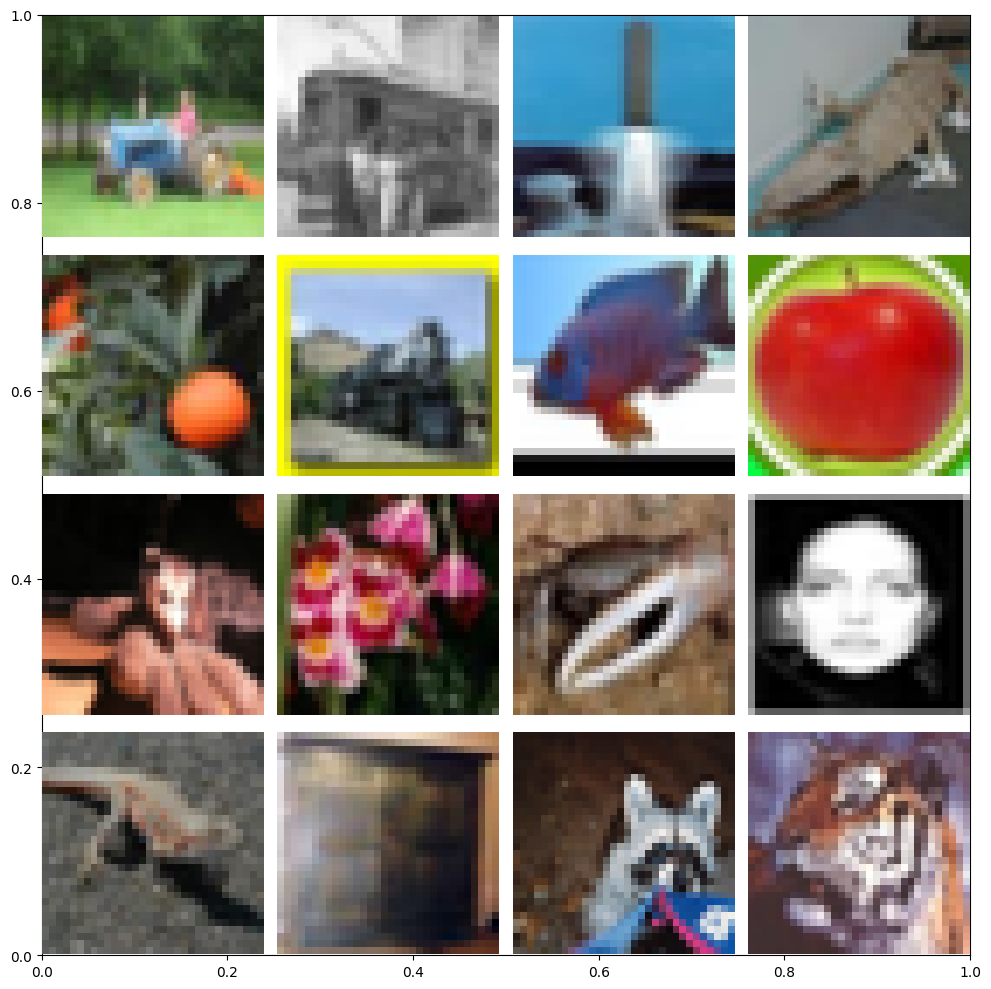

labels[14121].shape: (1,)
imgs[14121].shape: (32, 32, 3)


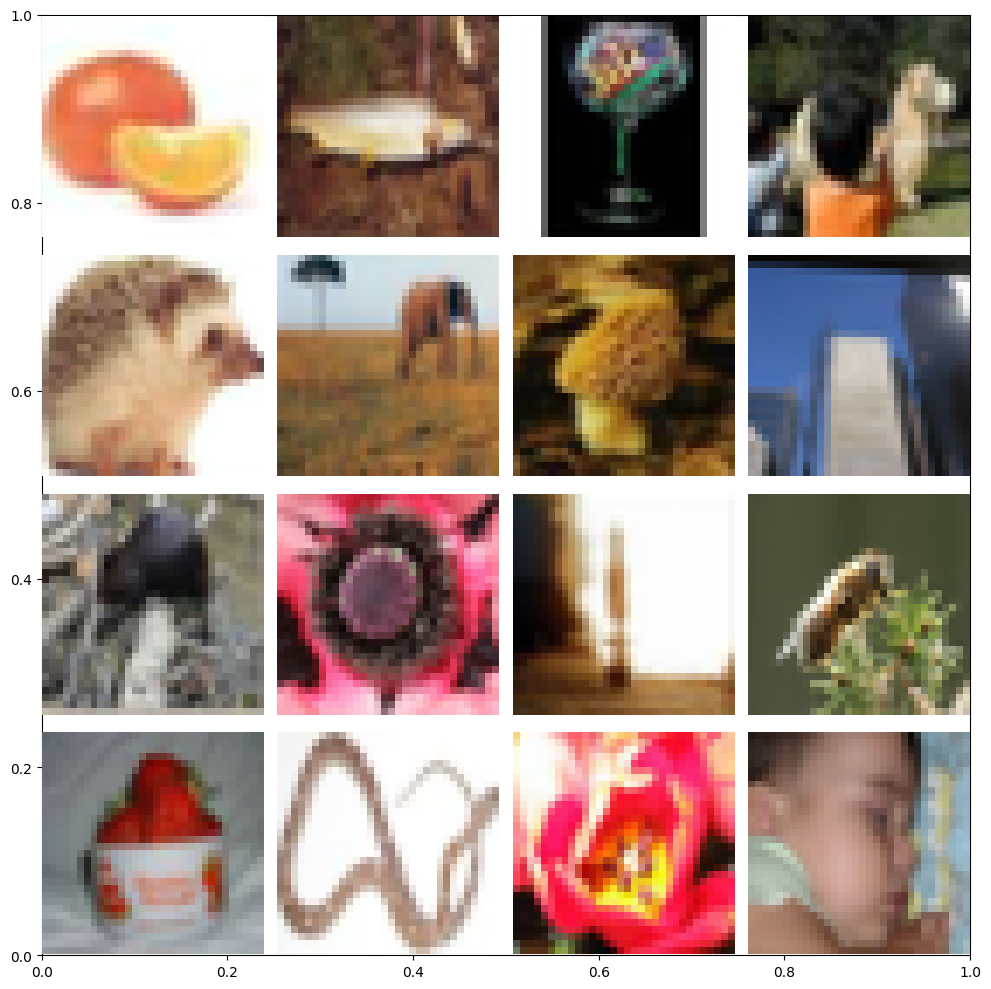

<ipython-input-4-78561581887d>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


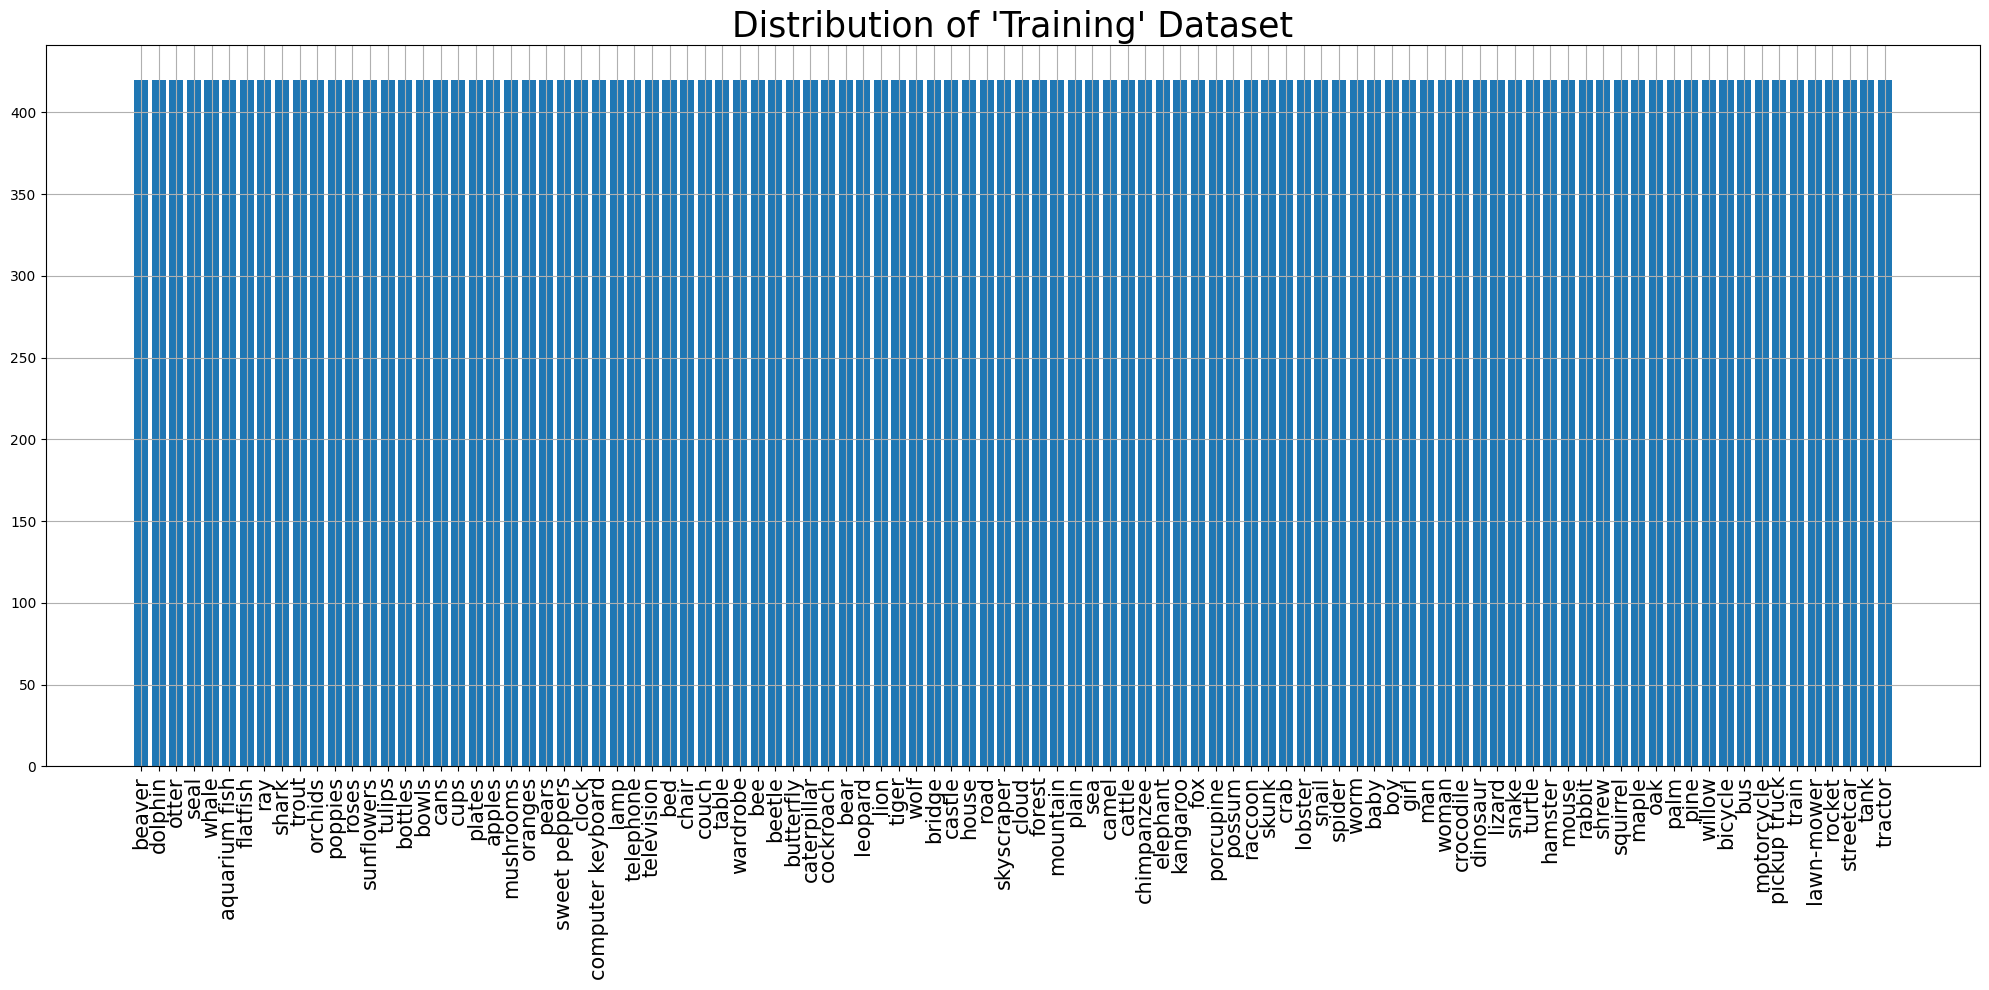

<ipython-input-4-78561581887d>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


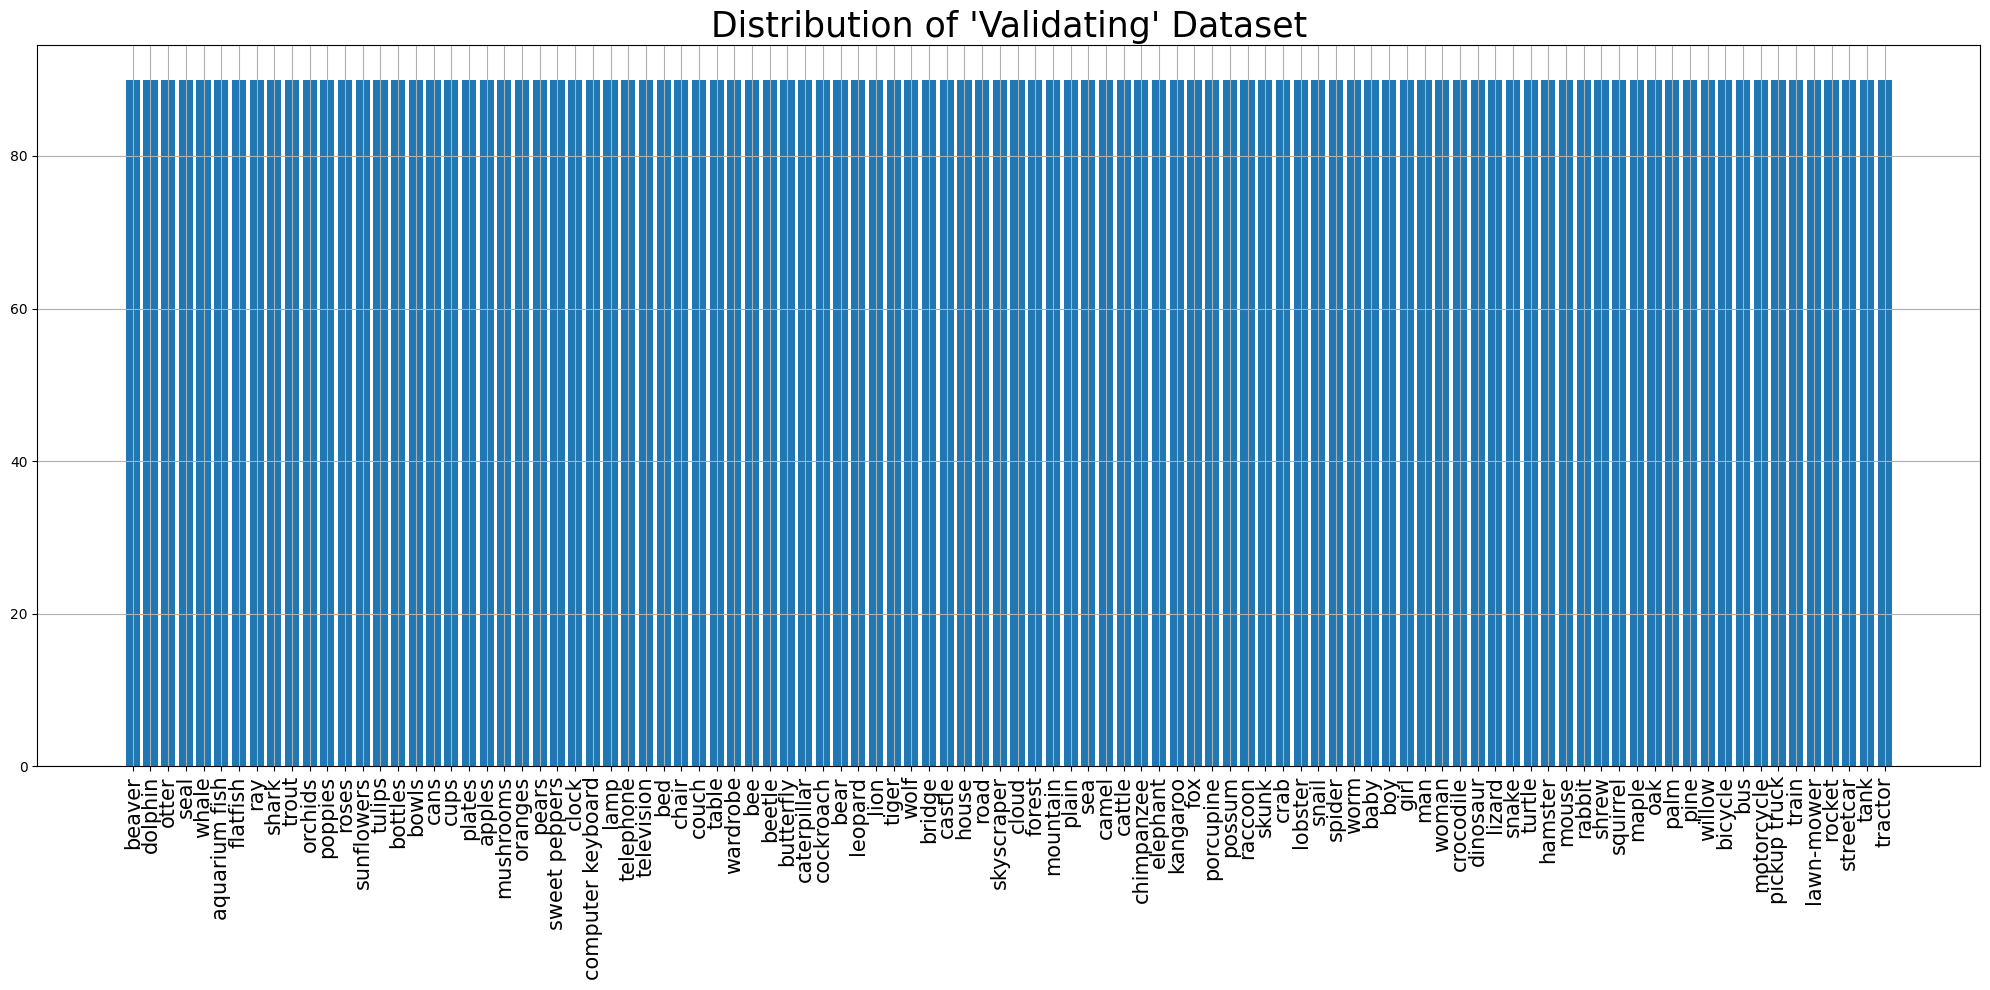

<ipython-input-4-78561581887d>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


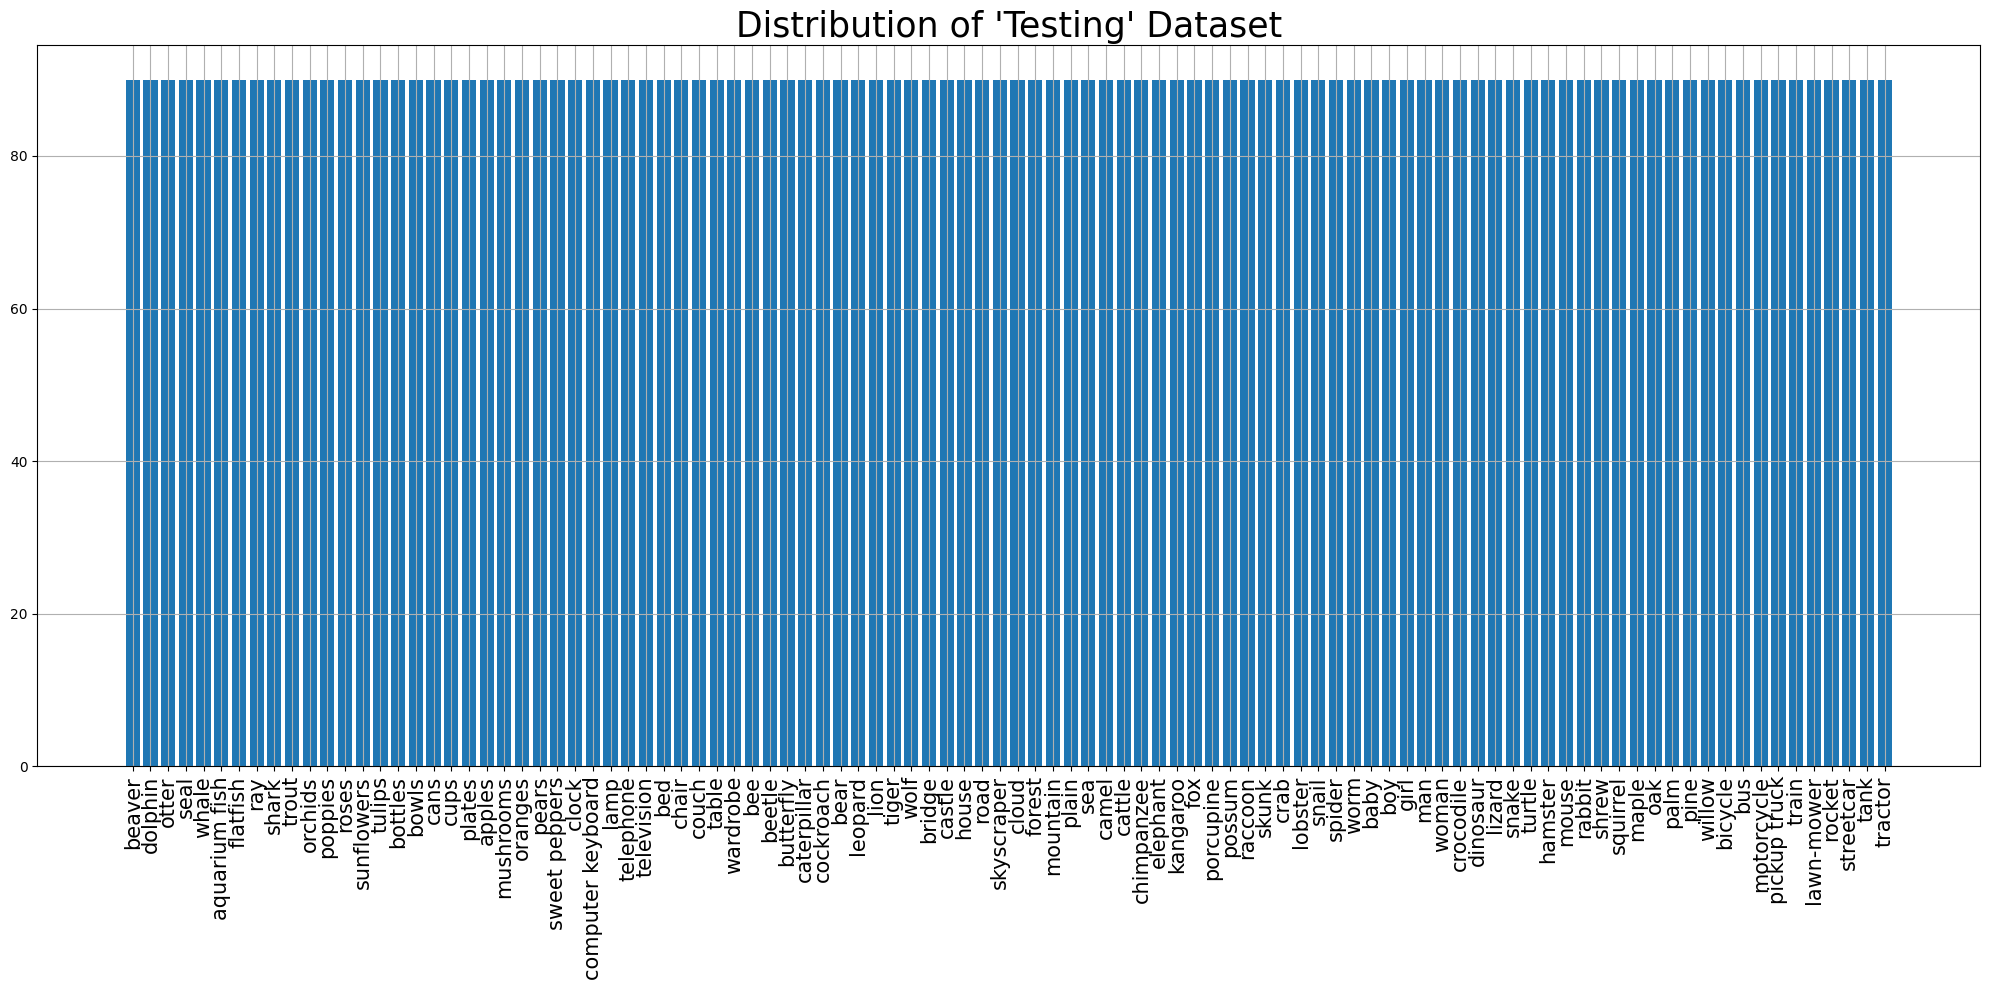

Training dataset:
 <_ConcatenateDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)

Validation dataset:
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)

Testing dataset:
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)
<class 'tuple'>
2
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
(64, 224, 224, 3)
(64, 100)
Model input shape: (None, 224, 224, 3)
Model output shape: (None, 100)
2
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(64, 224, 224, 3)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 100)                 │          51,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,665,188 (94.09 MB)

 Trainable params: 1,100,388 (4.20 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/25
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3805 - f1_score: 0.3768 - loss: 2.5198 - precision: 0.6877
Epoch 1: val_loss improved from inf to 1.39783, saving model to best_model_v3.keras
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 57s 35ms/step - accuracy: 0.3806 - f1_score: 0.3769 - loss: 2.5194 - precision: 0.6878 - val_accuracy: 0.6050 - val_f1_score: 0.6005 - val_loss: 1.3978 - val_precision: 0.8141
Epoch 2/25
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5653 - f1_score: 0.5622 - loss: 1.5643 - precision: 0.7582
Epoch 2: val_loss improved from 1.39783 to 1.31449, saving model to best_model_v3.keras
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 36s 27ms/step - accuracy: 0.5653 - f1_score: 0.5622 - loss: 1.5643 - precision: 0.7582 - val_accuracy: 0.6290 - val_f1_score: 0.6256 - val_loss: 1.3145 - val_precision: 0.8129
Epoch 3/25
1313/1314 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6051 - f1_score: 0.6030 - loss: 1.3909 - precision: 0.7773
Epoch 3: val_loss improved fro

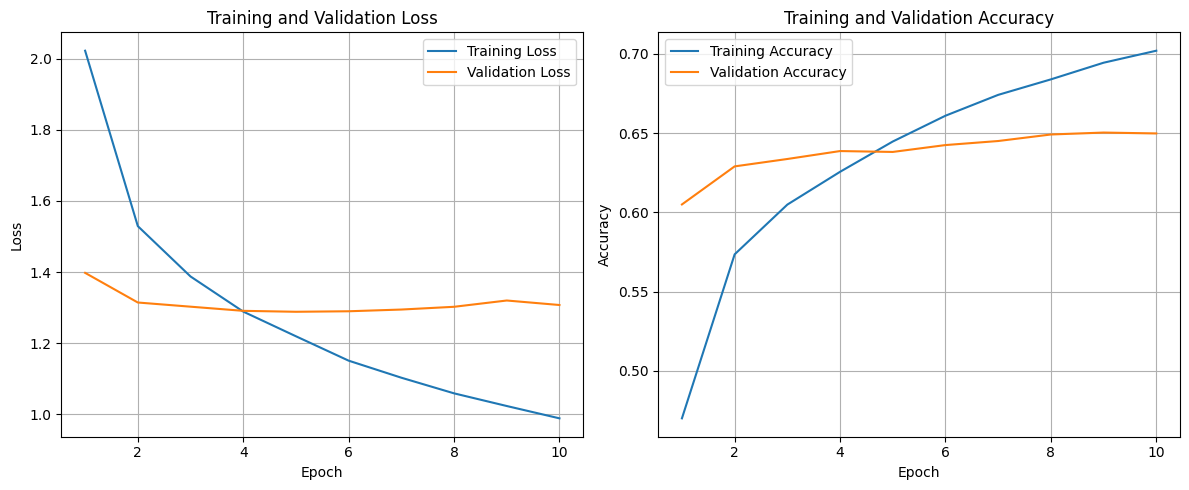

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.6348 - f1_score: 0.6276 - loss: 1.3111 - precision: 0.7859
Test Accuracy: 64.30%
Test Loss: 1.2860703468322754
Test Precision: 79.51%
Test F1 Scores (Per Class): [82.558136 76.34408  53.40909  41.610733 37.499992 67.878784 62.176155
 69.99999  76.300575 78.60696  59.886997 42.3841   67.08861  58.883244
 65.957436 54.222214 77.24867  71.497574 59.756096 59.756096 81.24999
 72.94117  80.701744 78.88888  79.347824 63.917522 47.76119  45.23809
 78.49462  64.59627  61.03895  69.27374  52.760727 56.999992 62.999992
 18.965513 68.78981  57.3991   50.68492  91.428566 72.94117  80.43478
 64.38356  67.77777  50.74626  47.999996 43.724693 52.910053 82.90154
 82.872925 40.60913  72.51461  64.15093  87.86127  67.2811   38.05309
 77.77777  65.65657  78.14569  50.31446  80.       70.58823  59.740257
 67.796616 38.80597  56.953632 65.89595  57.297295 85.71427  82.352936
 67.02127  73.14285  30.4878   60.24096  36.923073 81.52173  79.80295
 55.36

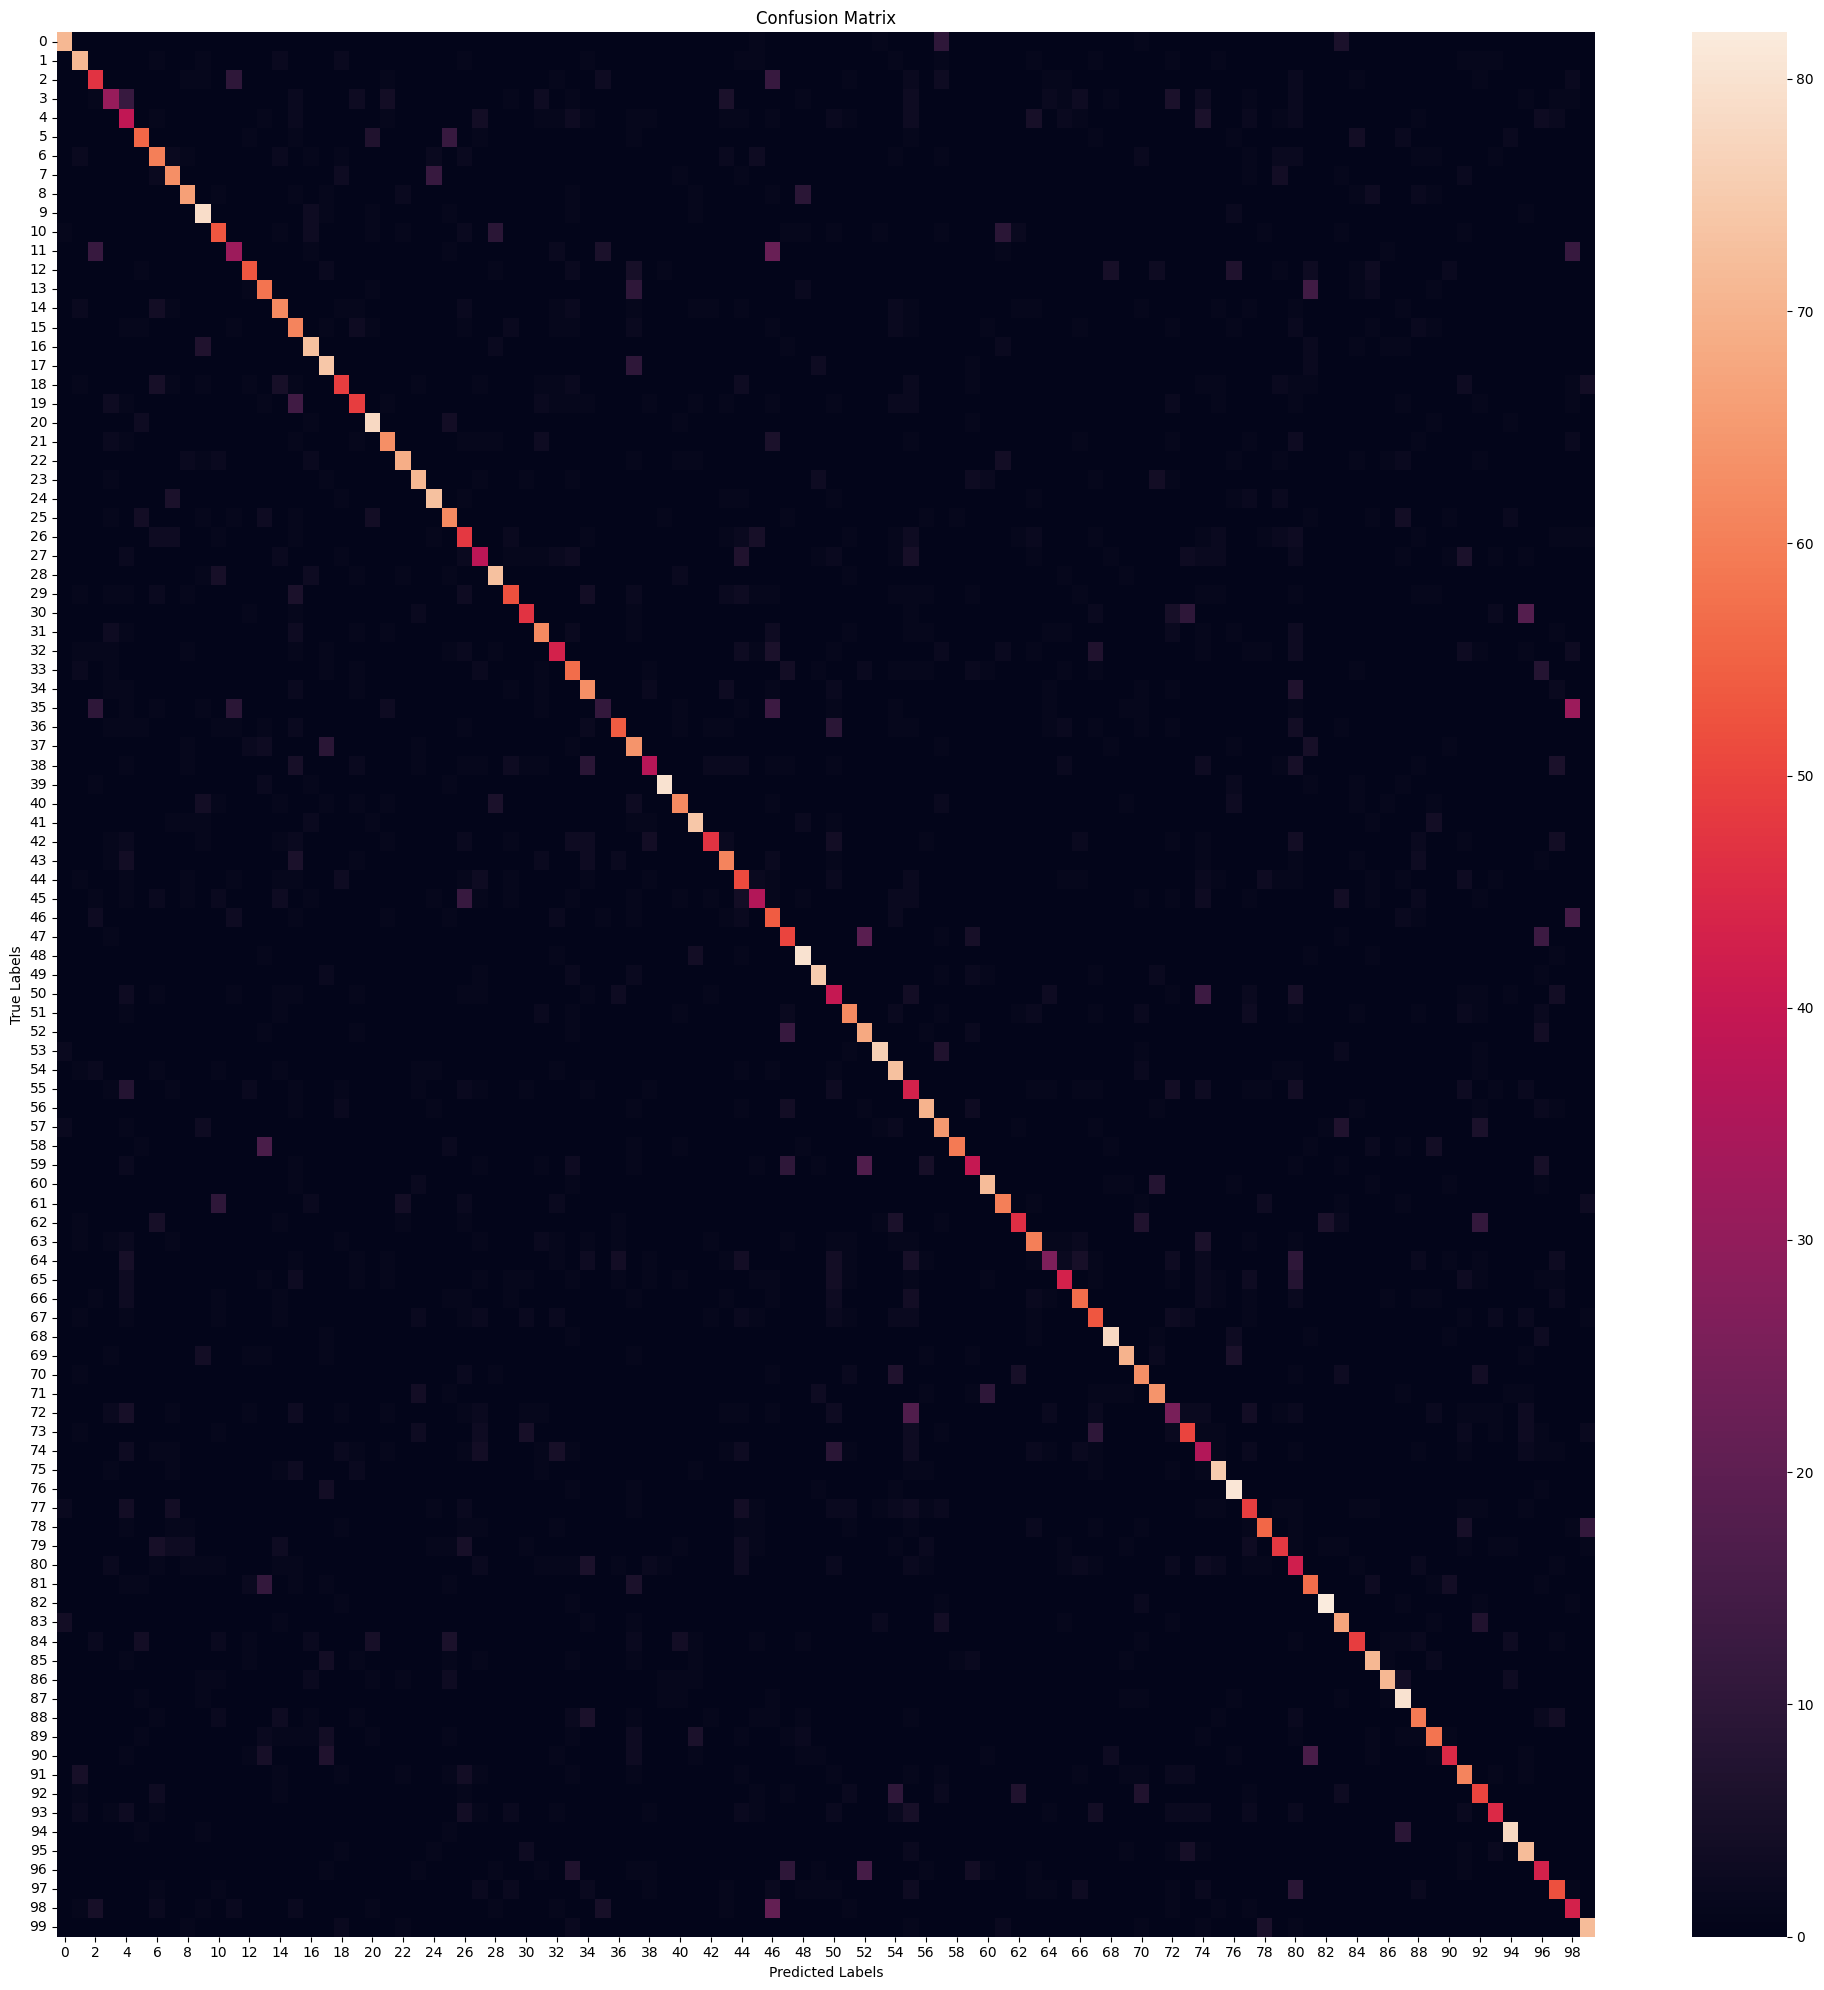

                   precision    recall  f1-score   support

           beaver       0.87      0.79      0.83        90
          dolphin       0.74      0.79      0.76        90
            otter       0.55      0.52      0.53        90
             seal       0.53      0.34      0.42        90
            whale       0.33      0.43      0.38        90
    aquarium fish       0.75      0.62      0.68        90
         flatfish       0.58      0.67      0.62        90
              ray       0.70      0.70      0.70        90
            shark       0.80      0.73      0.76        90
            trout       0.71      0.88      0.79        90
          orchids       0.61      0.59      0.60        90
          poppies       0.52      0.36      0.42        90
            roses       0.78      0.59      0.67        90
       sunflowers       0.54      0.64      0.59        90
           tulips       0.63      0.69      0.66        90
          bottles       0.45      0.68      0.54       

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 100)                 │          51,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,665,188 (94.09 MB)

 Trainable params: 1,100,388 (4.20 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/15
1970/1971 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6739 - f1_score: 0.6720 - loss: 1.0964 - precision: 0.8154
Epoch 1: val_loss improved from inf to 1.23921, saving model to best_model_fine_tune_v3.keras
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 74s 31ms/step - accuracy: 0.6739 - f1_score: 0.6720 - loss: 1.0964 - precision: 0.8154 - val_accuracy: 0.6564 - val_f1_score: 0.6555 - val_loss: 1.2392 - val_precision: 0.7977
Epoch 2/15
1970/1971 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7031 - f1_score: 0.7011 - loss: 0.9966 - precision: 0.8331
Epoch 2: val_loss improved from 1.23921 to 1.23250, saving model to best_model_fine_tune_v3.keras
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 52s 27ms/step - accuracy: 0.7031 - f1_score: 0.7011 - loss: 0.9966 - precision: 0.8331 - val_accuracy: 0.6601 - val_f1_score: 0.6593 - val_loss: 1.2325 - val_precision: 0.7946
Epoch 3/15
1969/1971 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7097 - f1_score: 0.7076 - loss: 0.9694 - precision: 0.8362
Epoch 3: v

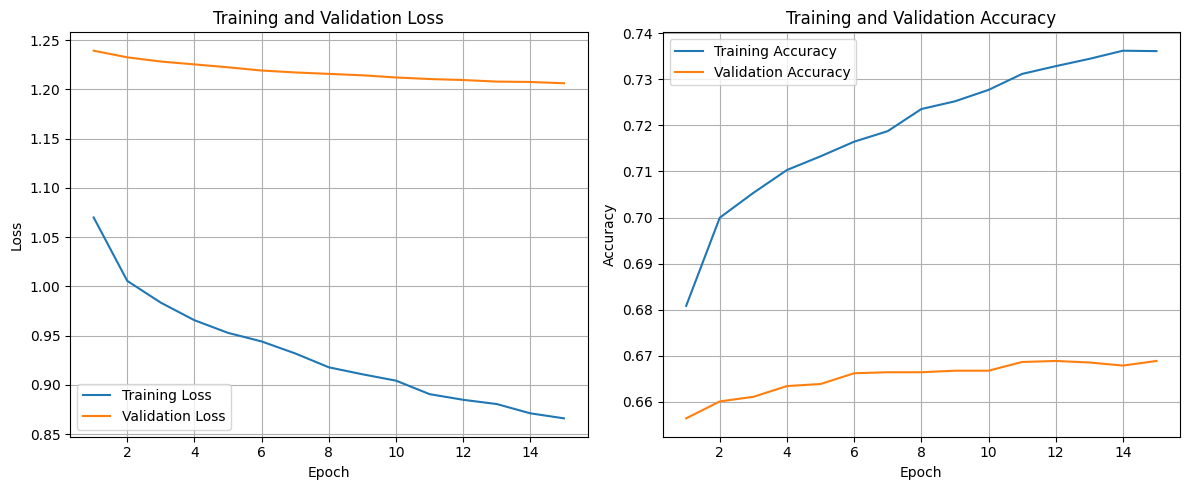

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.6626 - f1_score: 0.6547 - loss: 1.2223 - precision: 0.7941
Test Accuracy: 67.26%
Test Loss: 1.202204942703247
Test Precision: 80.19%
Test F1 Scores (Per Class): [85.71427  76.34408  57.894737 50.28571  39.784943 69.89246  62.827217
 70.786514 79.99999  82.02247  63.589745 47.204964 65.14285  60.1156
 68.63905  56.98323  78.30688  75.13227  58.88888  63.636356 83.060104
 75.93583  80.21977  80.446915 83.060104 68.57143  54.838707 54.54545
 78.65168  67.90123  66.666664 72.94117  55.345905 61.13989  69.565216
 39.999996 72.31638  58.064507 54.857136 92.48554  73.79678  81.60919
 67.02702  69.66292  48.958324 53.84615  48.087425 57.471264 82.10526
 82.48587  41.379307 73.56321  67.357506 89.99999  74.111664 38.88888
 81.39534  71.35134  79.761894 58.18181  82.02247  73.809525 66.31015
 68.181816 48.447197 54.02298  63.541664 62.032085 85.56149  81.44328
 71.590904 75.675674 44.047615 63.387978 37.77777  82.608696 88.26815
 61.176468

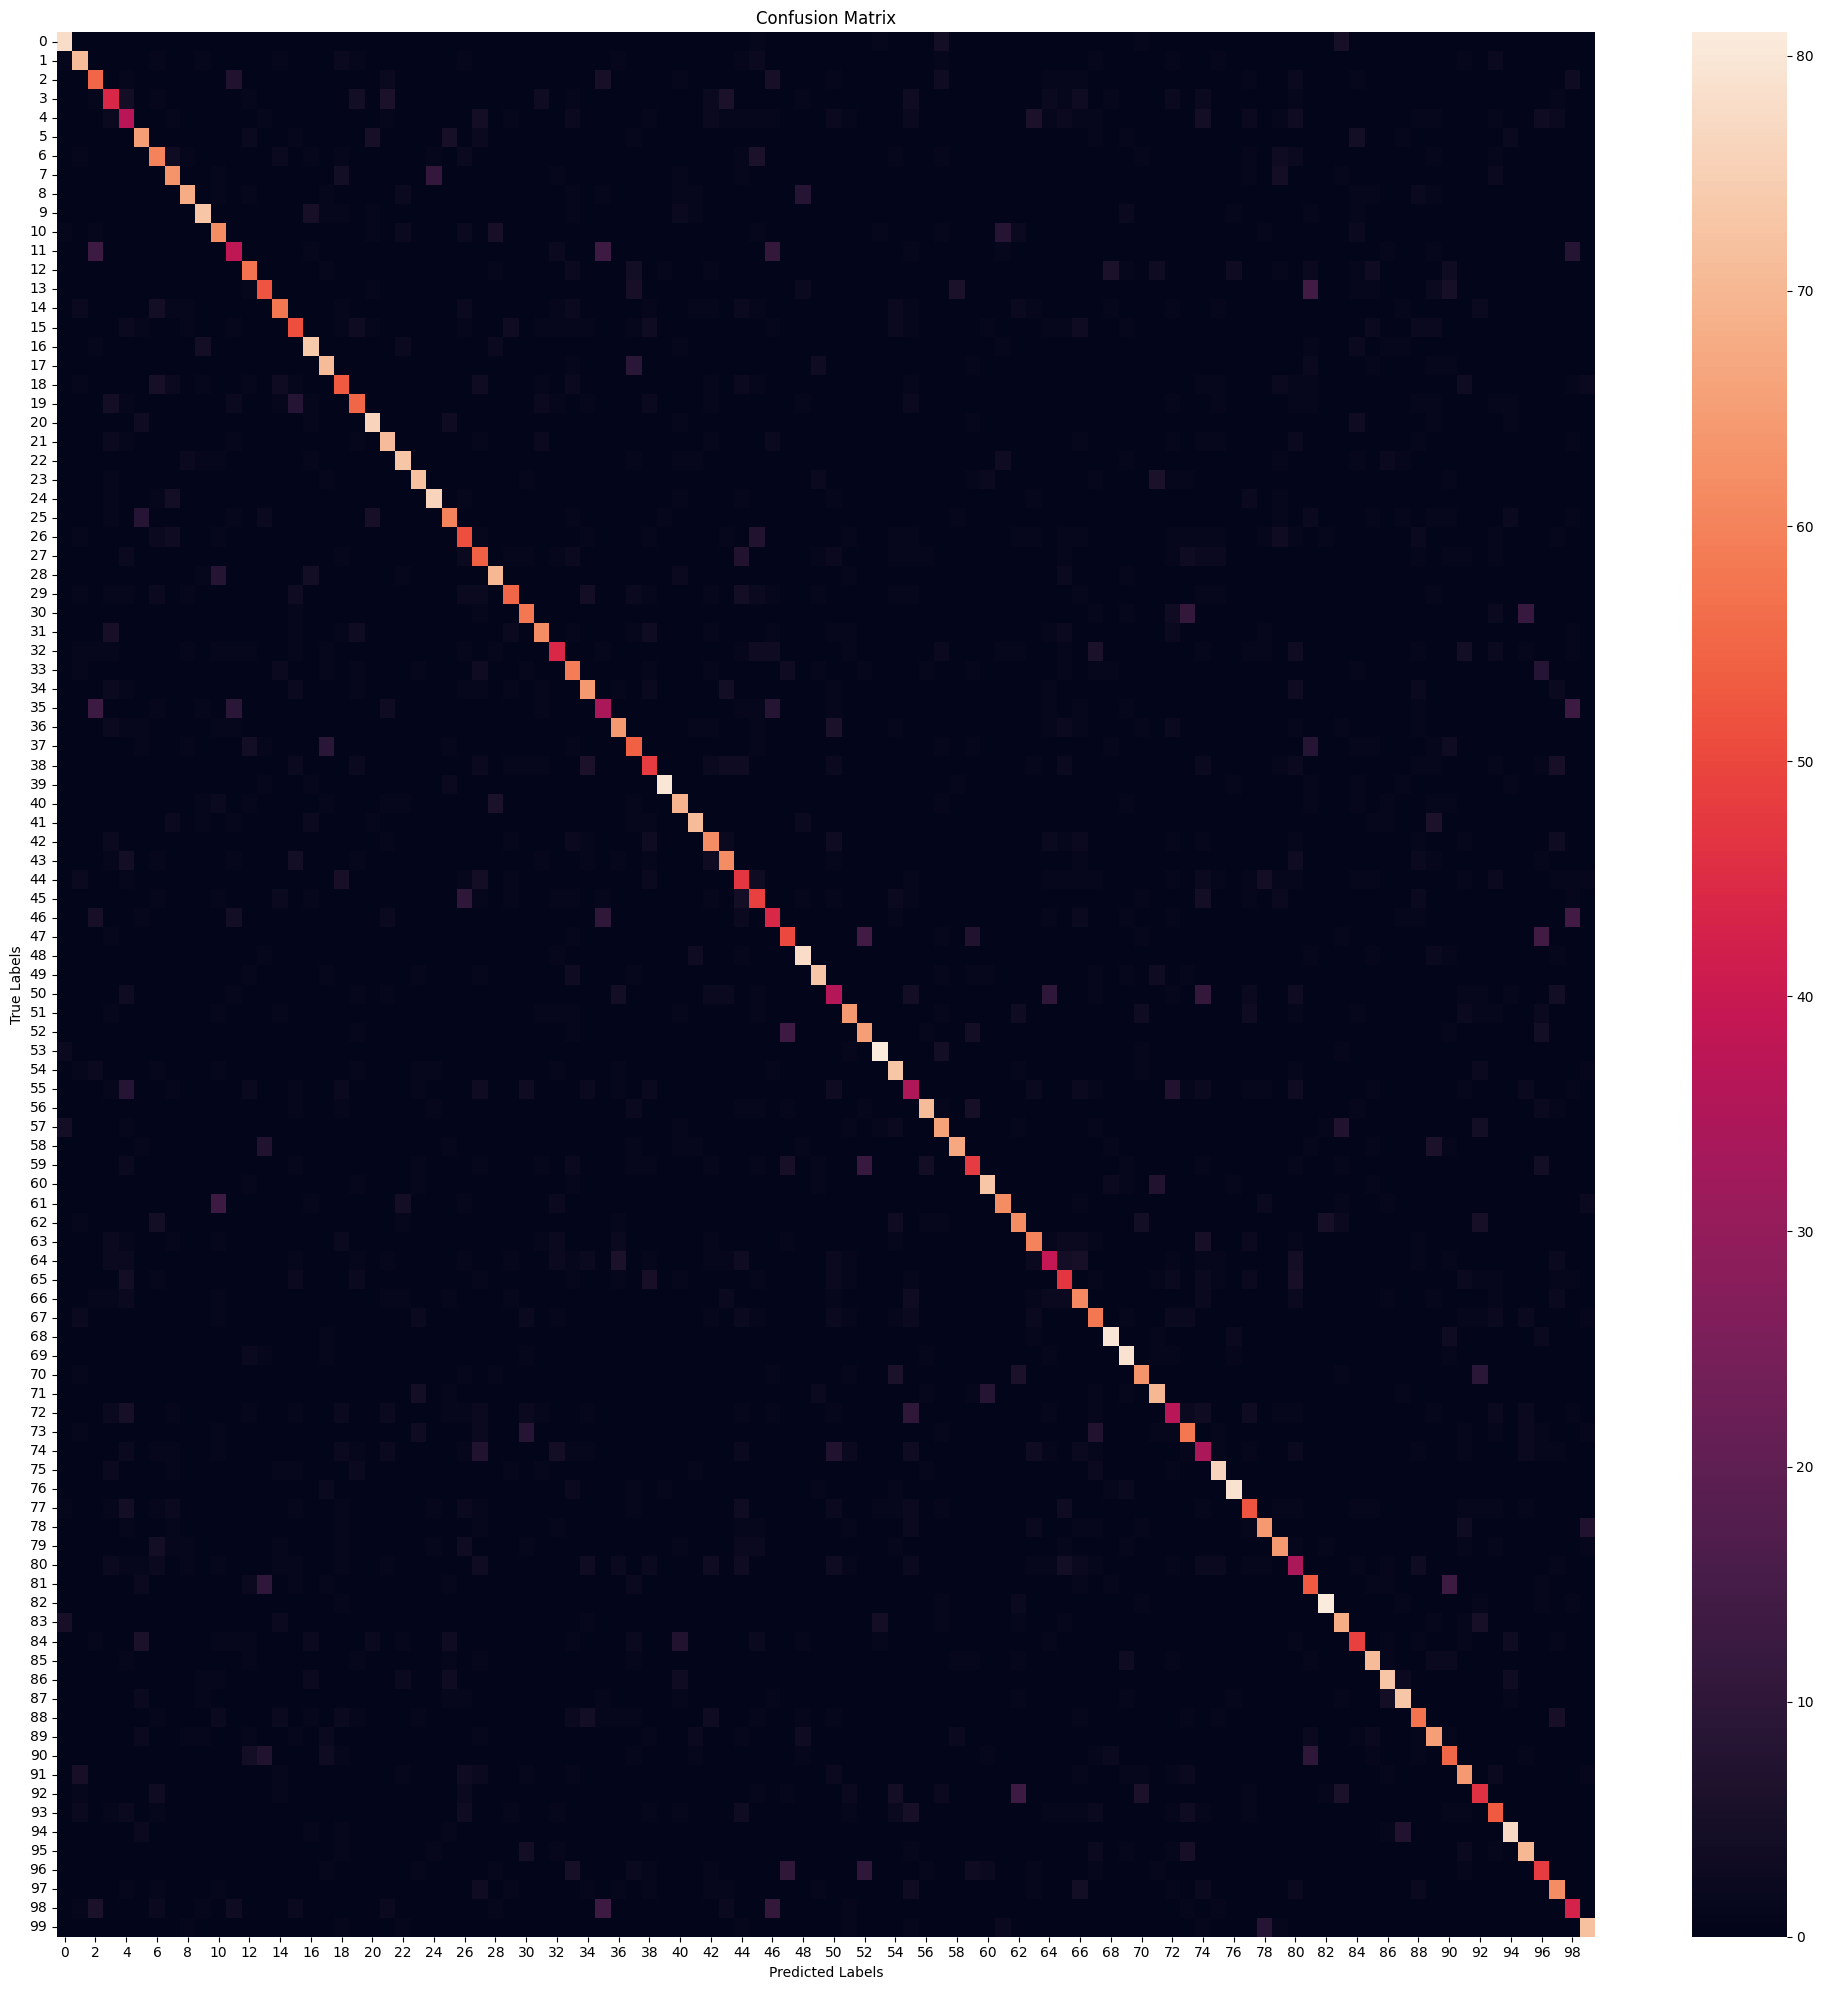

                   precision    recall  f1-score   support

           beaver       0.85      0.87      0.86        90
          dolphin       0.74      0.79      0.76        90
            otter       0.55      0.61      0.58        90
             seal       0.52      0.49      0.50        90
            whale       0.39      0.41      0.40        90
    aquarium fish       0.68      0.72      0.70        90
         flatfish       0.59      0.67      0.63        90
              ray       0.72      0.70      0.71        90
            shark       0.85      0.76      0.80        90
            trout       0.83      0.81      0.82        90
          orchids       0.59      0.69      0.64        90
          poppies       0.53      0.42      0.47        90
            roses       0.67      0.63      0.65        90
       sunflowers       0.63      0.58      0.60        90
           tulips       0.73      0.64      0.69        90
          bottles       0.57      0.57      0.57       

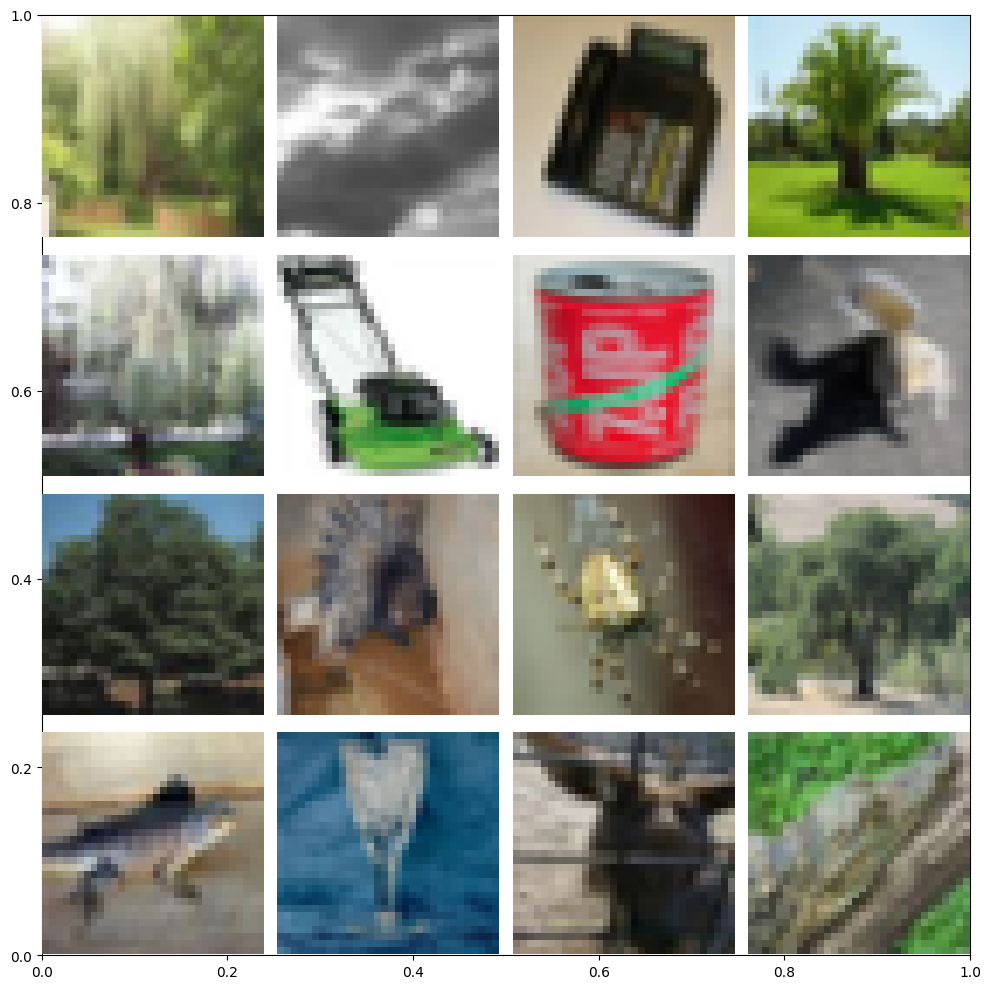

labels[3318].shape: (1,)
imgs[3318].shape: (32, 32, 3)


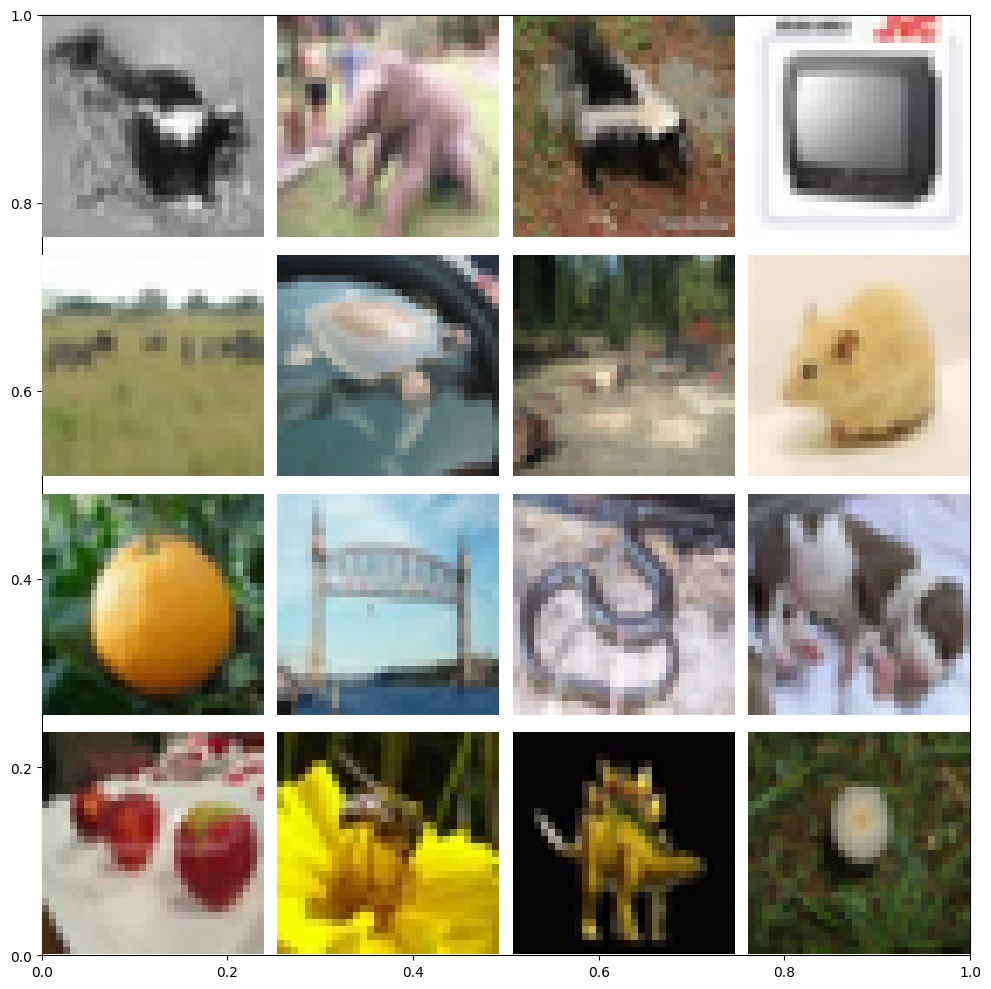

<ipython-input-4-78561581887d>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


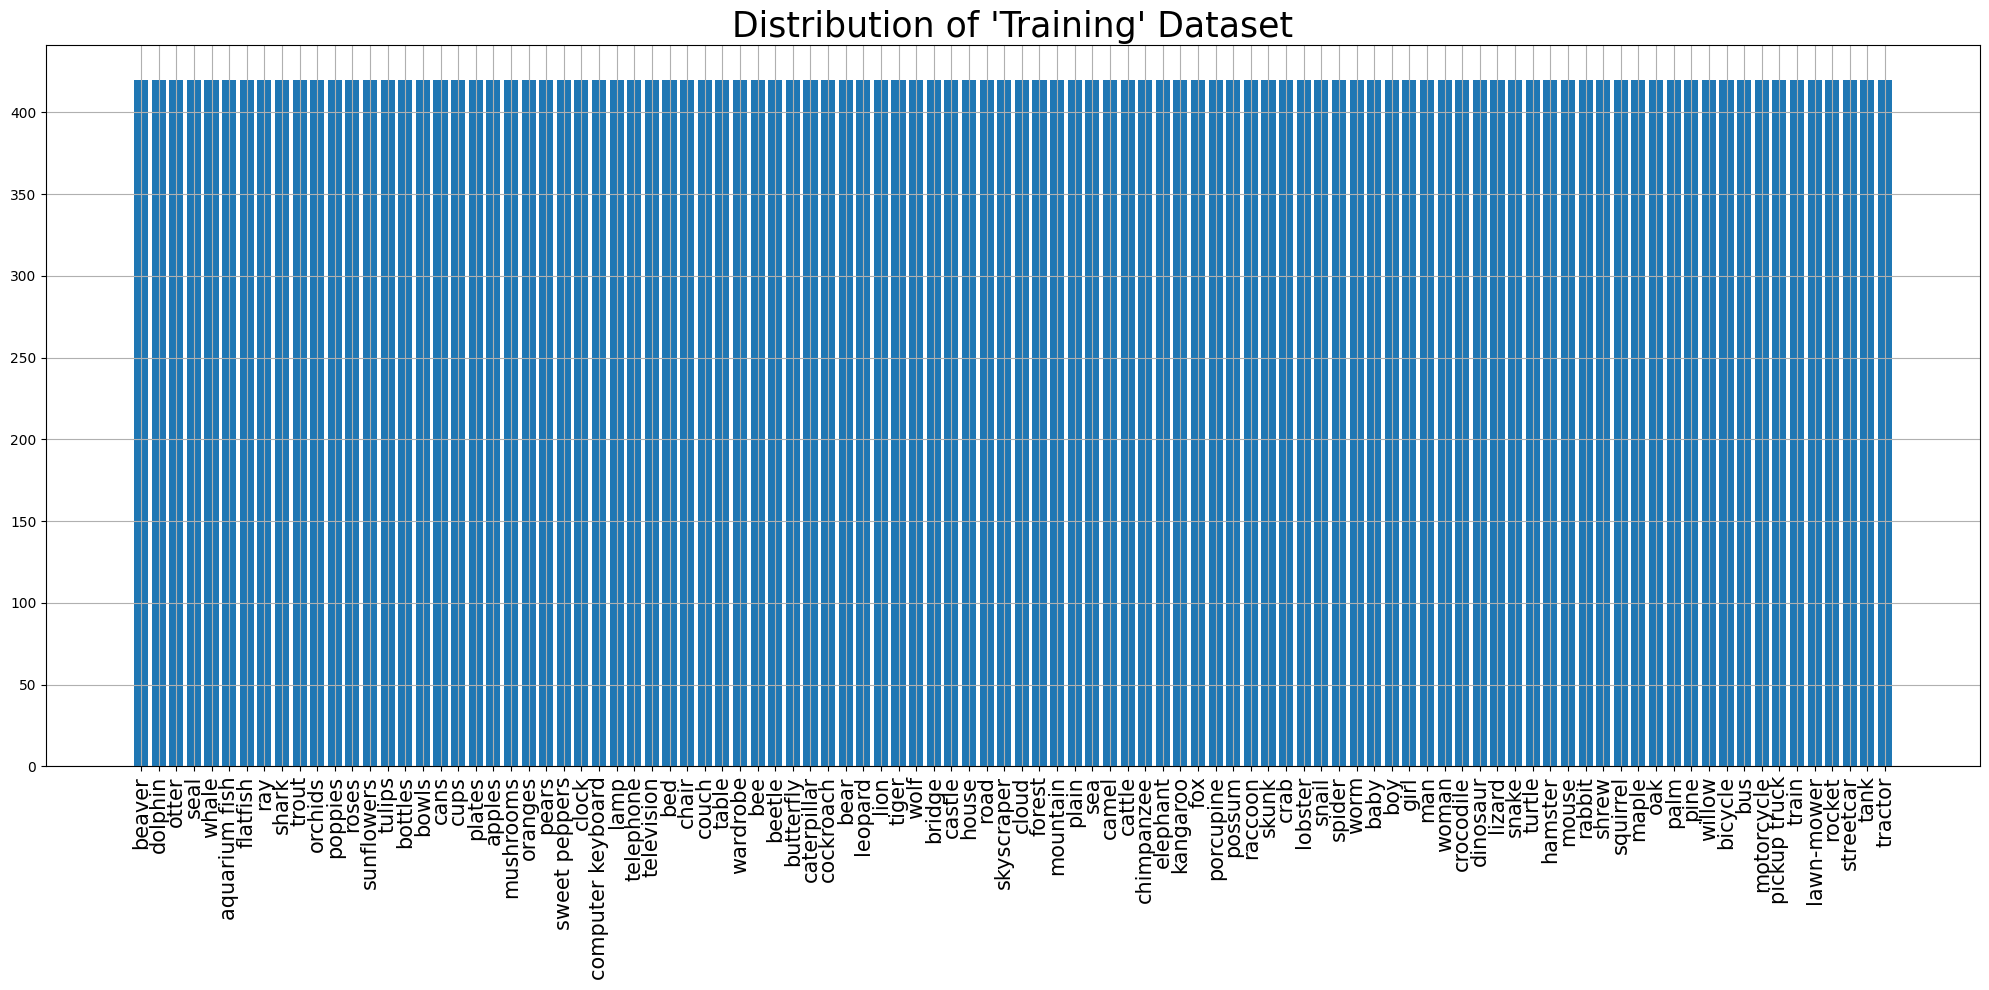

<ipython-input-4-78561581887d>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


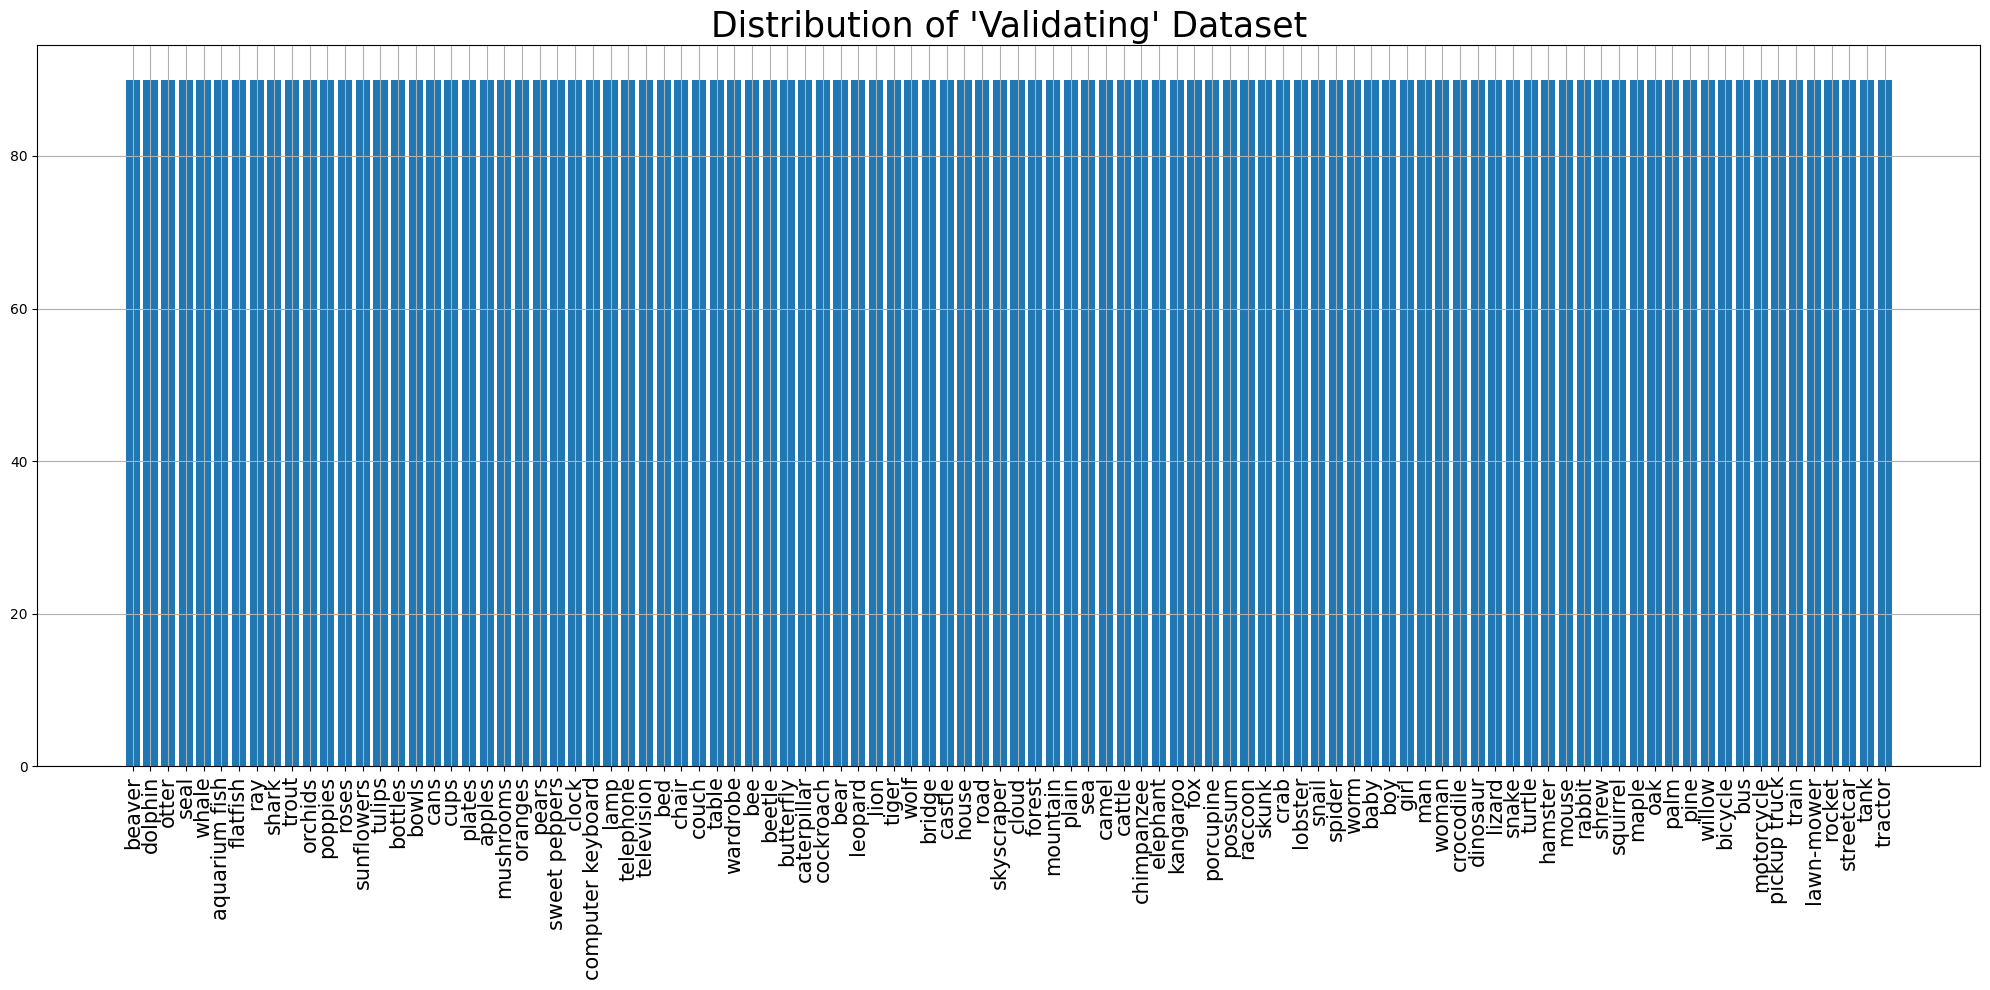

<ipython-input-4-78561581887d>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


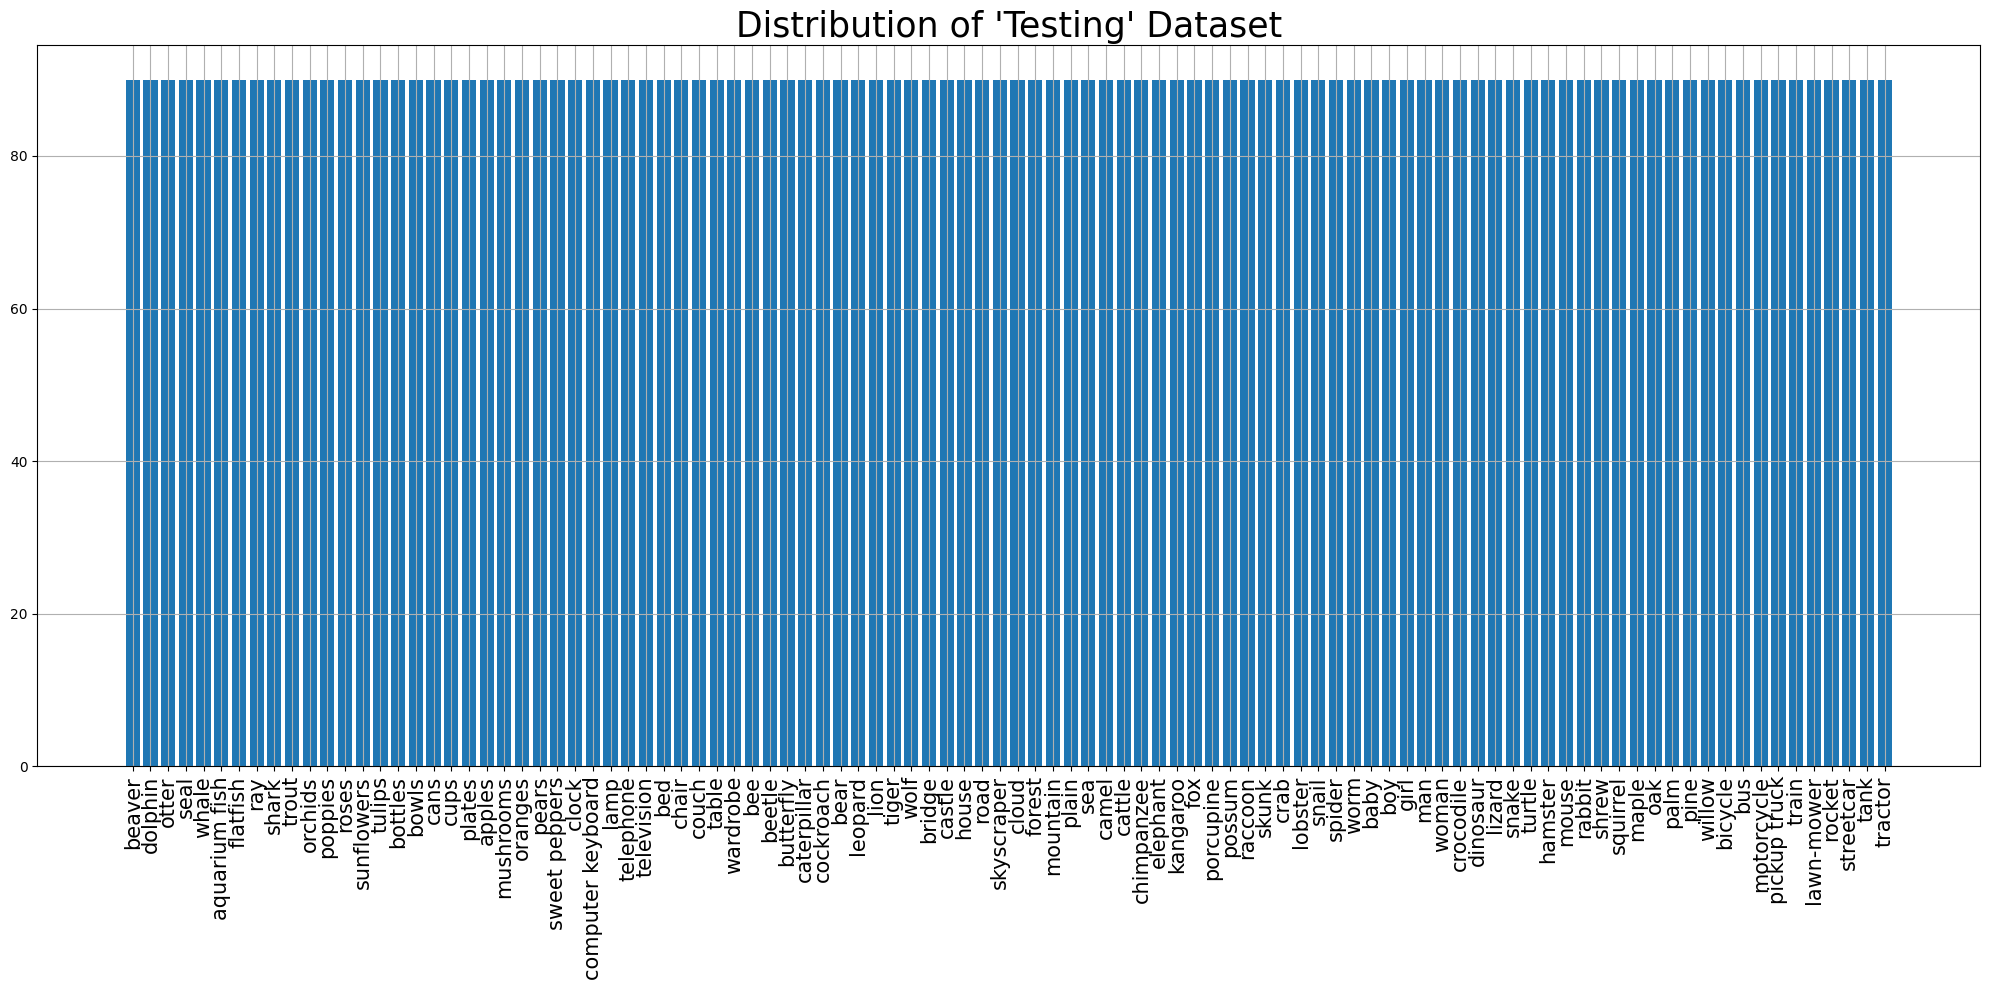

Training dataset:
 <_ConcatenateDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)

Validation dataset:
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)

Testing dataset:
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)
<class 'tuple'>
2
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
(64, 224, 224, 3)
(64, 100)
Model input shape: (None, 224, 224, 3)
Model output shape: (None, 100)
2
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(64, 224, 224, 3)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_7           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 100)                 │          51,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,665,188 (94.09 MB)

 Trainable params: 1,100,388 (4.20 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/25
1312/1314 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3853 - f1_score: 0.3806 - loss: 2.5243 - precision: 0.6891
Epoch 1: val_loss improved from inf to 1.39970, saving model to best_model_v3.keras
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 56s 35ms/step - accuracy: 0.3855 - f1_score: 0.3808 - loss: 2.5232 - precision: 0.6892 - val_accuracy: 0.6044 - val_f1_score: 0.5999 - val_loss: 1.3997 - val_precision: 0.8074
Epoch 2/25
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5628 - f1_score: 0.5594 - loss: 1.5709 - precision: 0.7598
Epoch 2: val_loss improved from 1.39970 to 1.33181, saving model to best_model_v3.keras
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 36s 27ms/step - accuracy: 0.5628 - f1_score: 0.5594 - loss: 1.5709 - precision: 0.7598 - val_accuracy: 0.6269 - val_f1_score: 0.6269 - val_loss: 1.3318 - val_precision: 0.8146
Epoch 3/25
1313/1314 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6056 - f1_score: 0.6029 - loss: 1.3928 - precision: 0.7782
Epoch 3: val_loss improved fro

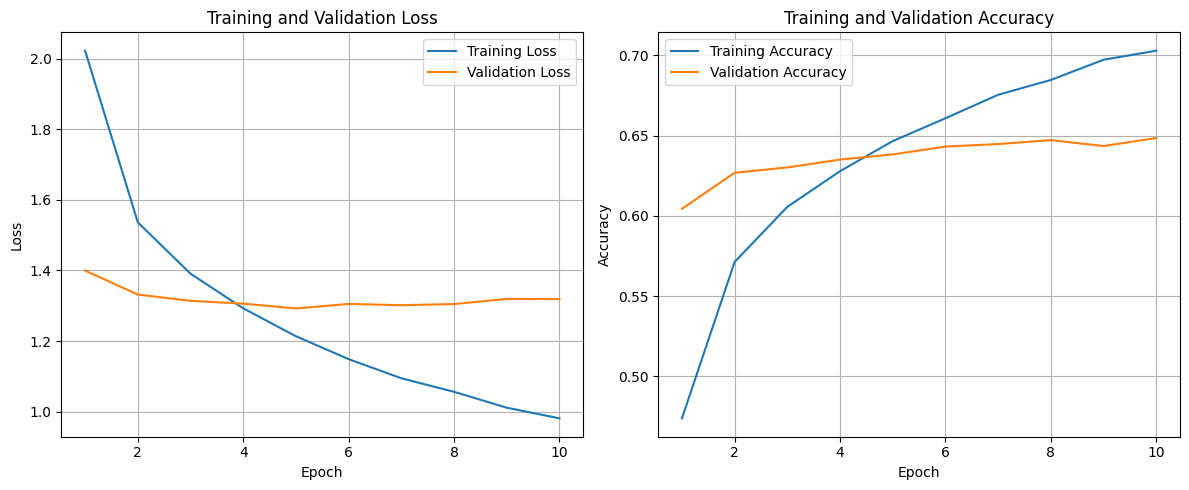

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.6366 - f1_score: 0.6285 - loss: 1.3105 - precision: 0.7859
Test Accuracy: 64.27%
Test Loss: 1.2877730131149292
Test Precision: 79.15%
Test F1 Scores (Per Class): [82.68156  79.365074 52.941174 48.36601  35.460987 66.26506  58.69565
 69.47368  79.99999  81.31868  61.445778 45.45454  66.25767  56.989246
 65.060234 53.88127  81.11111  73.684204 59.89847  53.987724 80.43478
 77.64706  77.456635 77.27273  79.768776 62.5641   50.495045 45.74468
 78.39195  64.17112  61.25     65.64102  45.67901  53.164555 69.31818
 17.3913   67.46988  56.15763  47.61904  87.29281  69.62025  77.31957
 62.820507 69.66292  52.216743 50.810806 47.47081  59.192818 79.99999
 83.51647  38.247005 69.005844 60.999996 85.549126 67.37968  31.70731
 78.61271  69.74358  69.93006  53.59477  77.77777  73.44632  67.08861
 68.604645 40.310078 58.024685 62.499992 60.869556 87.23404  82.291664
 65.65657  70.87379  36.756752 59.30232  33.749996 81.96721  84.04254
 57.31706

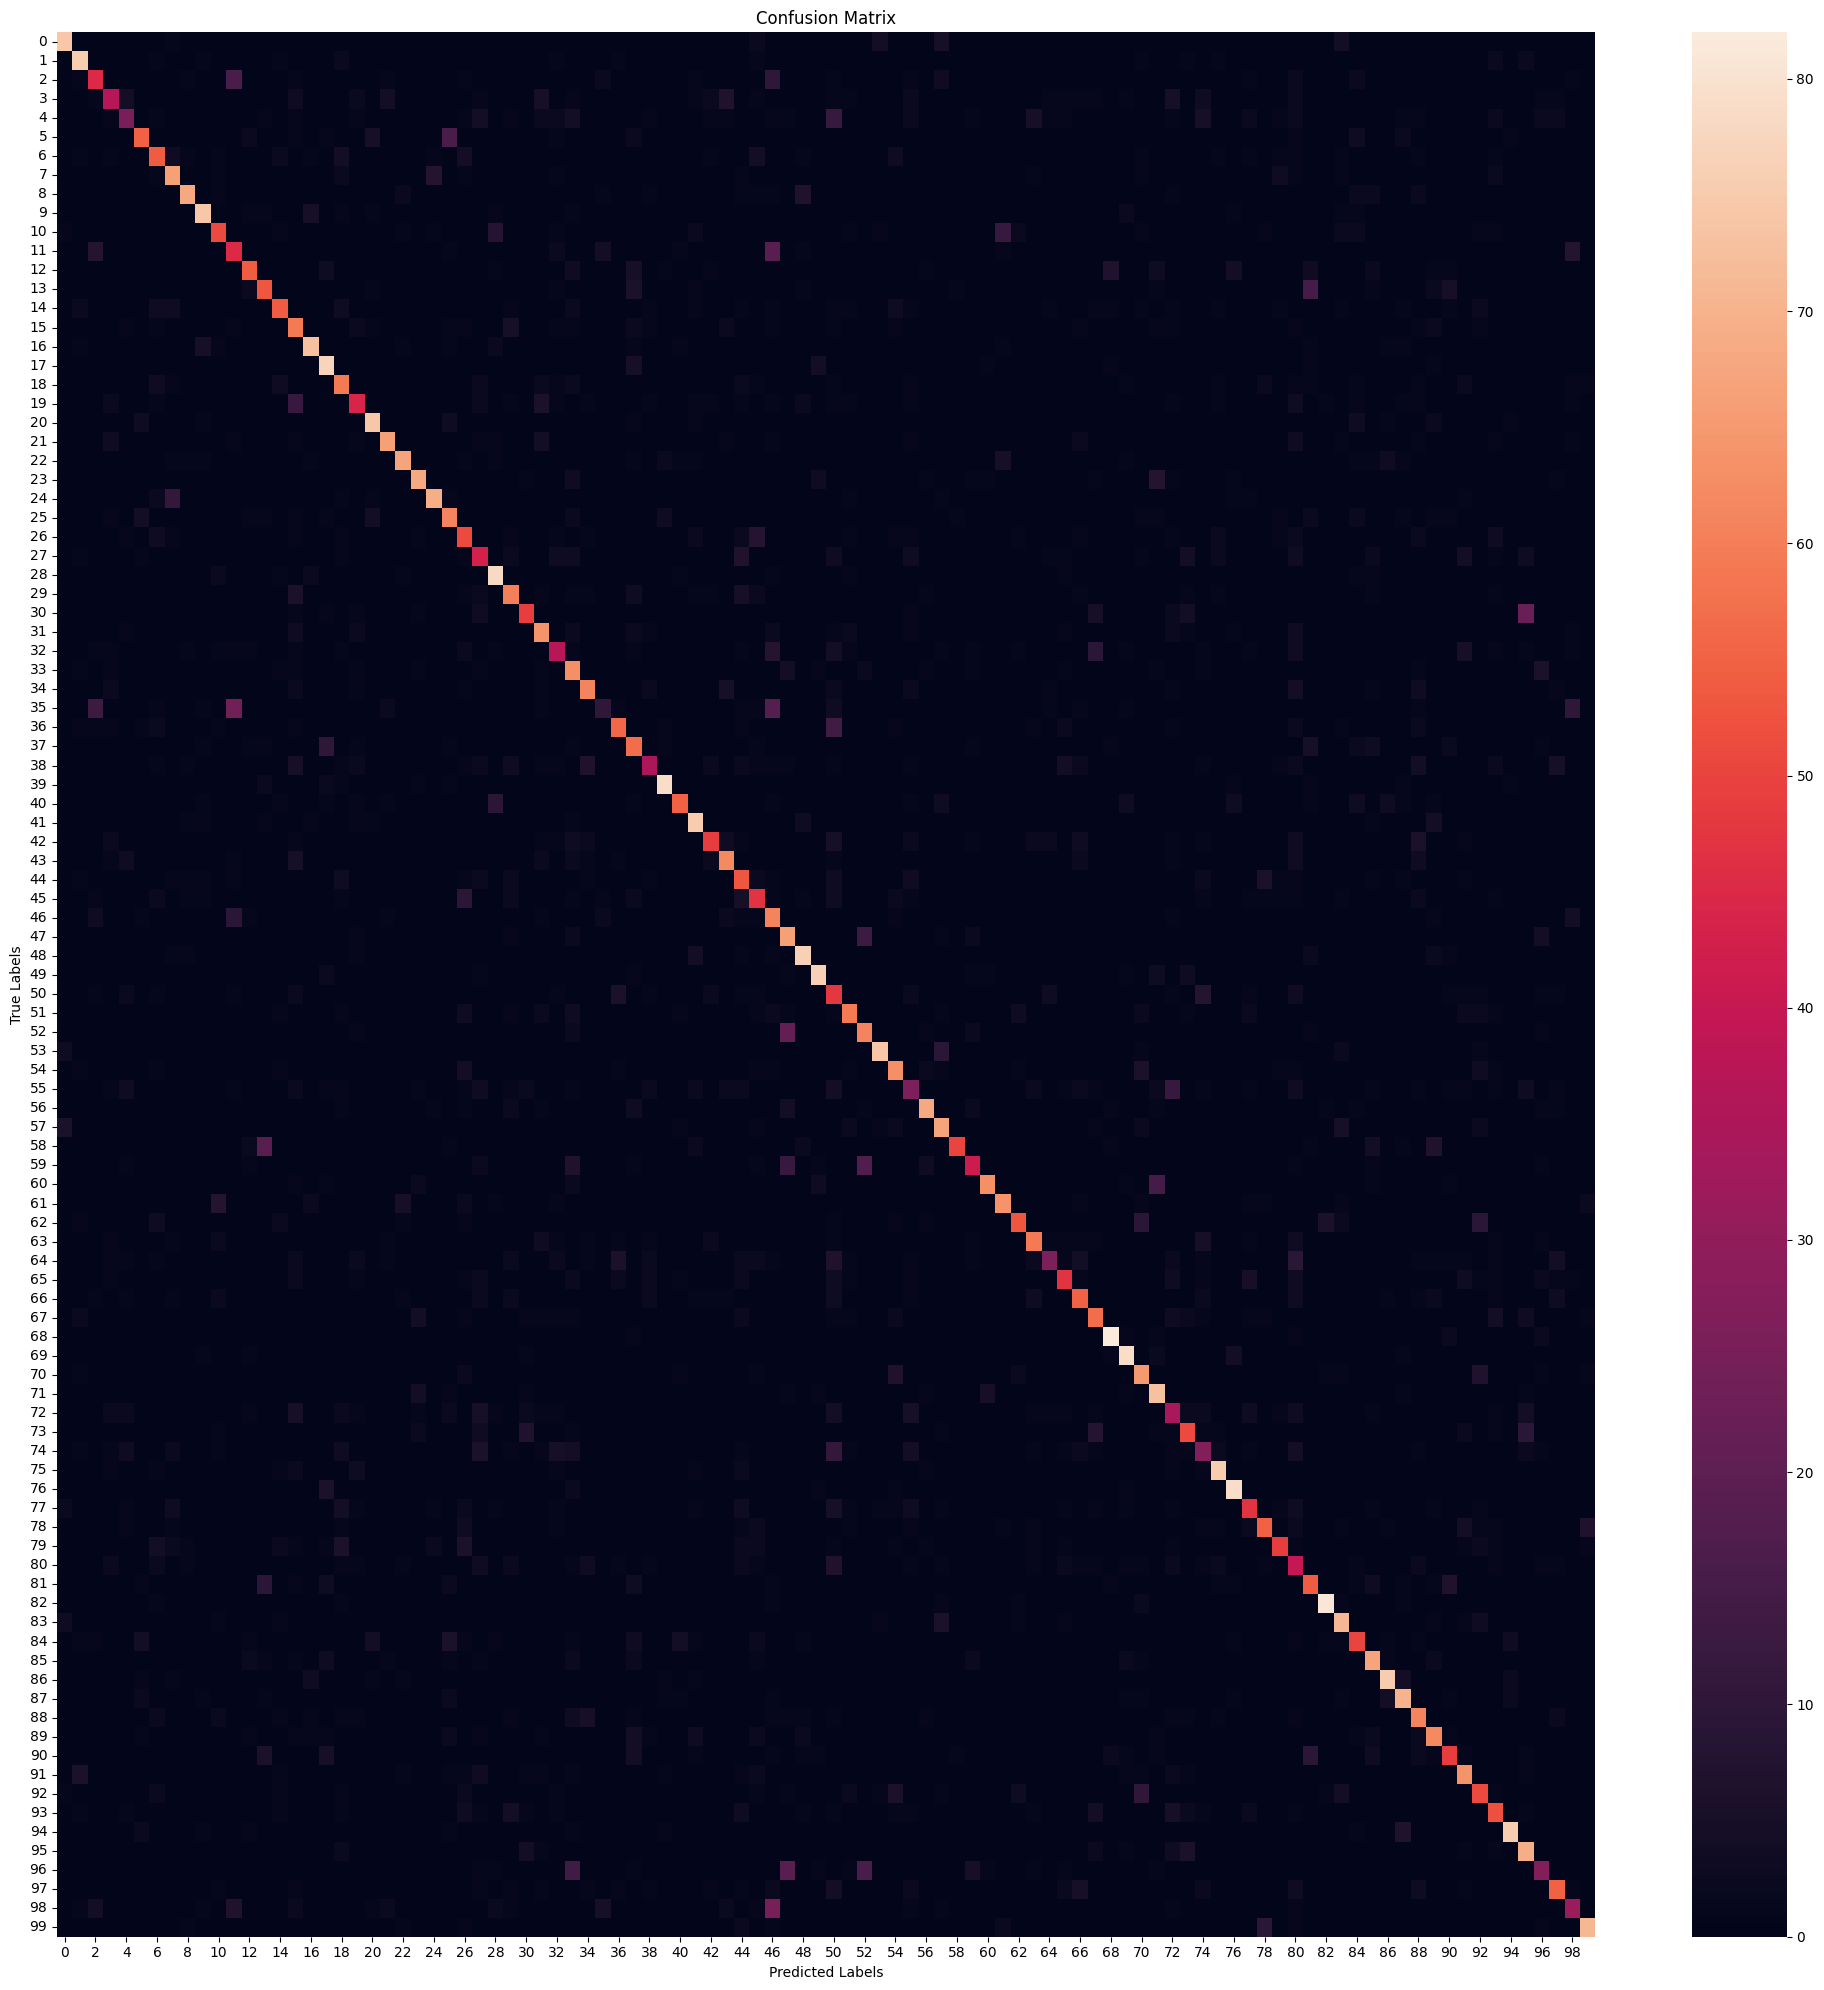

                   precision    recall  f1-score   support

           beaver       0.82      0.82      0.82        90
          dolphin       0.76      0.83      0.79        90
            otter       0.56      0.50      0.53        90
             seal       0.59      0.41      0.48        90
            whale       0.49      0.28      0.35        90
    aquarium fish       0.72      0.61      0.66        90
         flatfish       0.57      0.60      0.59        90
              ray       0.66      0.73      0.69        90
            shark       0.85      0.76      0.80        90
            trout       0.80      0.82      0.81        90
          orchids       0.66      0.57      0.61        90
          poppies       0.42      0.50      0.45        90
            roses       0.74      0.60      0.66        90
       sunflowers       0.55      0.59      0.57        90
           tulips       0.71      0.60      0.65        90
          bottles       0.46      0.66      0.54       

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_7           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 100)                 │          51,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,665,188 (94.09 MB)

 Trainable params: 1,100,388 (4.20 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/15
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6780 - f1_score: 0.6761 - loss: 1.0871 - precision: 0.8185
Epoch 1: val_loss improved from inf to 1.24744, saving model to best_model_fine_tune_v3.keras
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 73s 31ms/step - accuracy: 0.6780 - f1_score: 0.6761 - loss: 1.0871 - precision: 0.8185 - val_accuracy: 0.6522 - val_f1_score: 0.6510 - val_loss: 1.2474 - val_precision: 0.7970
Epoch 2/15
1970/1971 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7049 - f1_score: 0.7028 - loss: 0.9853 - precision: 0.8332
Epoch 2: val_loss improved from 1.24744 to 1.24231, saving model to best_model_fine_tune_v3.keras
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 53s 27ms/step - accuracy: 0.7049 - f1_score: 0.7028 - loss: 0.9853 - precision: 0.8332 - val_accuracy: 0.6566 - val_f1_score: 0.6557 - val_loss: 1.2423 - val_precision: 0.7936
Epoch 3/15
1969/1971 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7120 - f1_score: 0.7102 - loss: 0.9631 - precision: 0.8397
Epoch 3: v

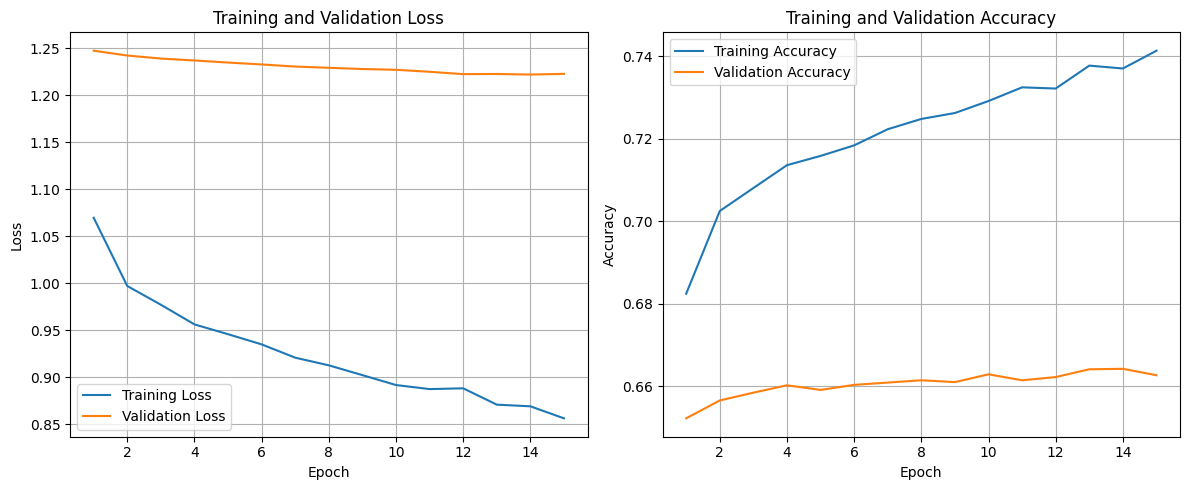

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.6574 - f1_score: 0.6494 - loss: 1.2309 - precision: 0.7864
Test Accuracy: 66.71%
Test Loss: 1.2028621435165405
Test Precision: 79.37%
Test F1 Scores (Per Class): [81.767944 79.79274  54.27136  50.56179  40.86021  69.23077  57.868015
 68.53932  79.99999  78.68852  64.83515  50.31446  68.57143  63.218384
 69.047615 62.702698 80.21977  76.8421   65.217384 59.30232  81.72042
 77.31957  82.16216  82.08092  82.7225   67.04545  55.294113 49.751236
 78.02197  70.731705 64.04494  74.556206 51.533733 60.301506 67.357506
 34.939754 71.99999  60.416664 47.999996 90.69767  69.47368  81.52173
 62.92134  71.67629  50.810806 55.43478  53.631275 56.470577 84.32432
 83.51647  41.176464 74.03315  63.157898 88.76403  71.71716  42.857136
 80.701744 69.89246  79.28994  56.97674  83.42856  73.37277  66.29213
 67.46988  39.240498 58.426964 59.016384 64.04494  83.51647  84.491974
 67.415726 75.268814 39.49044  59.574467 41.711224 82.608696 86.18784
 58.3

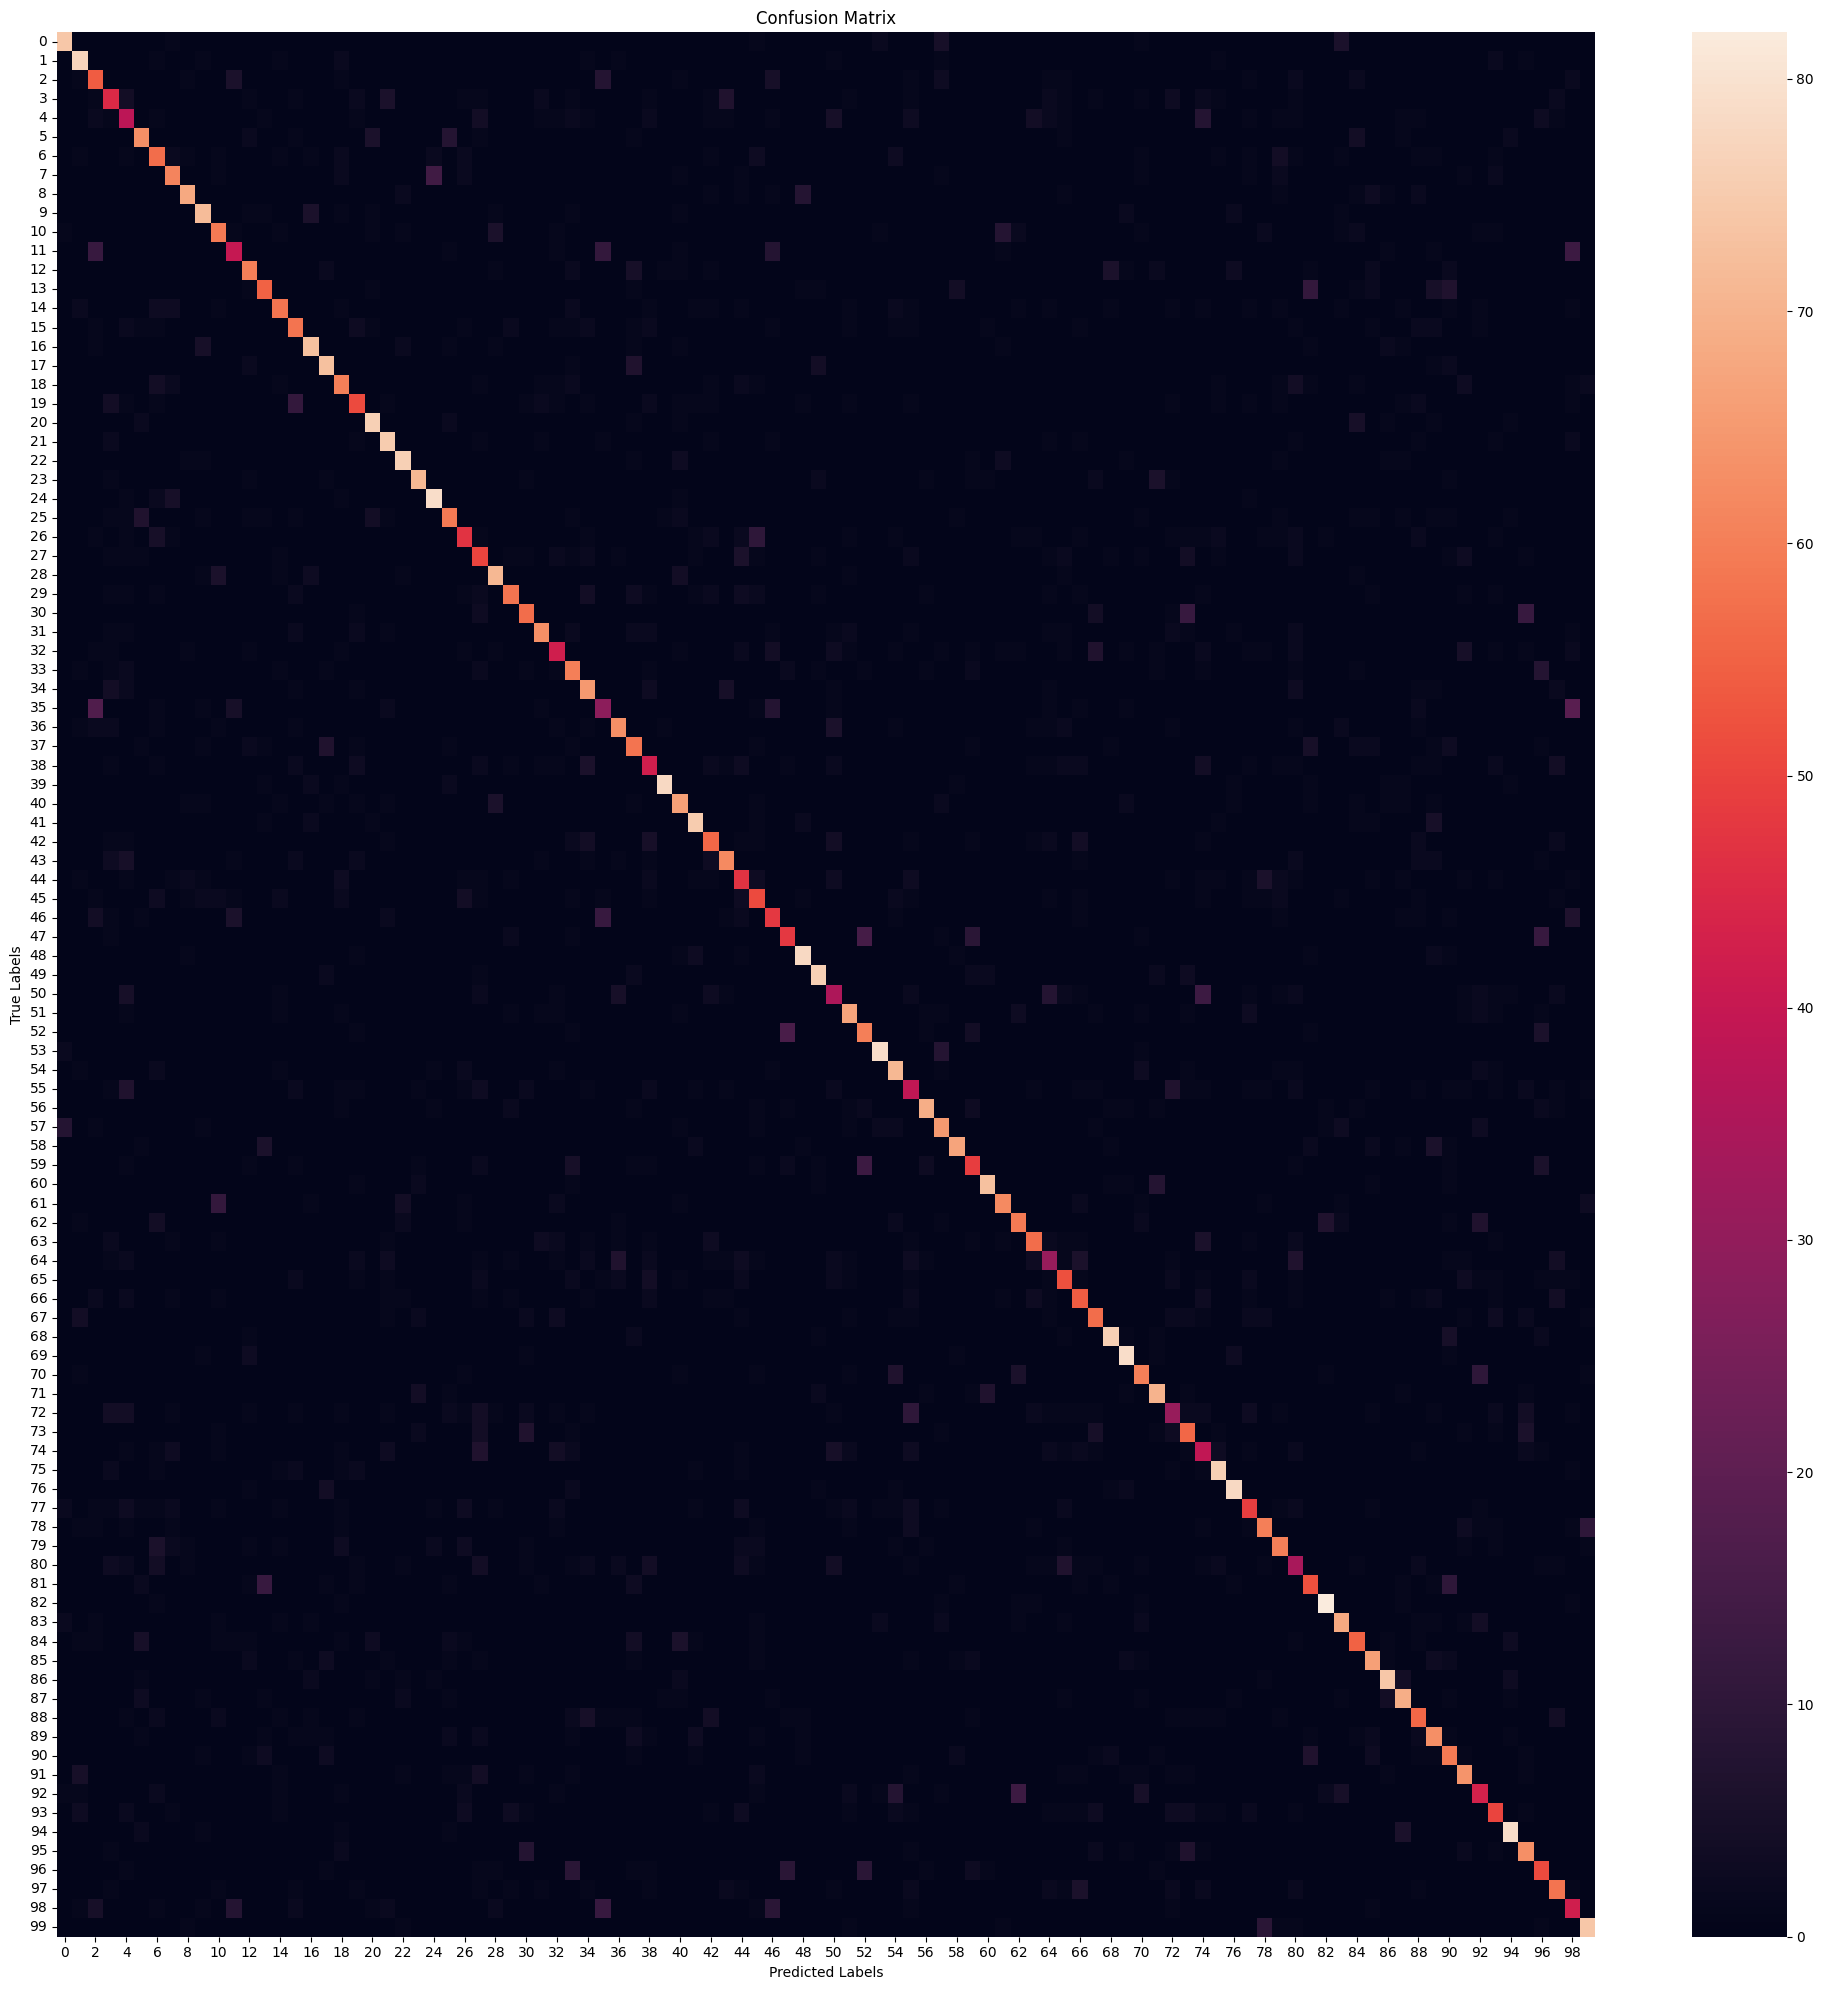

                   precision    recall  f1-score   support

           beaver       0.82      0.82      0.82        90
          dolphin       0.75      0.86      0.80        90
            otter       0.50      0.60      0.54        90
             seal       0.51      0.50      0.51        90
            whale       0.40      0.42      0.41        90
    aquarium fish       0.68      0.70      0.69        90
         flatfish       0.53      0.63      0.58        90
              ray       0.69      0.68      0.69        90
            shark       0.85      0.76      0.80        90
            trout       0.77      0.80      0.79        90
          orchids       0.64      0.66      0.65        90
          poppies       0.58      0.44      0.50        90
            roses       0.71      0.67      0.69        90
       sunflowers       0.65      0.61      0.63        90
           tulips       0.73      0.64      0.69        90
          bottles       0.61      0.64      0.63       

In [9]:
for repeat_2_times in range(2):
    #### <<<<<<<<<<Load and process data>>>>>>>>>>
    # Load CIFAR-100 dataset
    (X_train, y_train), (X_test, y_test) = cifar100.load_data(label_mode='fine')

    # Split (8000) of training data into temporary set
    X_temp, X_train, y_temp, y_train = train_test_split(X_train, y_train, test_size=0.84, stratify=y_train, random_state=42)
    print(f"X_temp.shape: {X_temp.shape}\n")

    # Split temp data into equal validation (4000) and testing (4000) data
    X_temp_val, X_temp_test, y_temp_val, y_temp_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
    print(f"X_temp_val.shape: {X_temp_val.shape}")
    print(f"y_temp_val.shape: {y_temp_val.shape}")
    print(f"X_temp_test.shape: {X_temp_test.shape}")
    print(f"y_temp_test.shape: {y_temp_test.shape}\n")

    # Split test data into validation (5000) and testing (5000)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)

    # Add temp_val to validation (9000) and temp_test to testing (9000) to get a 70/15/15 data split
    X_val = np.concatenate((X_val, X_temp_val), axis=0)
    y_val = np.concatenate((y_val, y_temp_val), axis=0)
    X_test = np.concatenate((X_test, X_temp_test), axis=0)
    y_test = np.concatenate((y_test, y_temp_test), axis=0)

    print(f"X_train.shape: {X_train.shape}")
    print(f"y_train.shape: {y_train.shape}")
    print(f"X_val.shape: {X_val.shape}")
    print(f"y_val.shape: {y_val.shape}")
    print(f"X_test.shape: {X_test.shape}")
    print(f"y_test.shape: {y_test.shape}\n")

    display_imgs(X_train, y_train)

    # Normalise images (scale to range [0, 1]) - Improves convergence speed & accuracy
    X_train, X_val, X_test = X_train / 255.0, X_val / 255.0, X_test / 255.0
    display_imgs(X_train, y_train)

    labels_names = ['beaver','dolphin','otter','seal','whale','aquarium fish','flatfish','ray','shark','trout',
                   'orchids','poppies','roses','sunflowers','tulips','bottles','bowls','cans','cups','plates',
                   'apples','mushrooms','oranges','pears','sweet peppers','clock','computer keyboard','lamp',
                   'telephone','television','bed','chair','couch','table','wardrobe','bee','beetle','butterfly',
                   'caterpillar','cockroach','bear','leopard','lion','tiger','wolf','bridge','castle','house',
                   'road','skyscraper','cloud','forest','mountain','plain','sea','camel','cattle','chimpanzee',
                   'elephant','kangaroo','fox','porcupine','possum','raccoon','skunk','crab','lobster','snail',
                   'spider','worm','baby','boy','girl','man','woman','crocodile','dinosaur','lizard','snake',
                   'turtle','hamster','mouse','rabbit','shrew','squirrel','maple','oak','palm','pine','willow',
                   'bicycle','bus','motorcycle','pickup truck','train','lawn-mower','rocket','streetcar','tank',
                   'tractor']

    class_distrib(y_train, labels_names, "Training")
    class_distrib(y_val, labels_names, "Validating")
    class_distrib(y_test, labels_names, "Testing")

    # Create TensorFlow datasets

    batch_size = 64

    train_dataset_ = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
                     .map(lambda x, y: (tf.image.resize(x, (224, 224)),
                                        tf.squeeze(tf.one_hot(y, depth=100, dtype=tf.float32))))  # Remove extra dimension
                     .batch(batch_size)
                     .prefetch(tf.data.experimental.AUTOTUNE))

    # DEBUG augment
    train_dataset_aug = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
                     .map(augment_dataset, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                     .batch(batch_size)
                     .prefetch(tf.data.experimental.AUTOTUNE))

    # Combine the original dataset and the augmented dataset
    train_dataset = train_dataset_.concatenate(train_dataset_aug)

    val_dataset = (tf.data.Dataset.from_tensor_slices((X_val, y_val))
                   .map(lambda x, y: (tf.image.resize(x, (224, 224)),
                                      tf.squeeze(tf.one_hot(y, depth=100, dtype=tf.float32))))  # Remove extra dimension
                   .batch(batch_size)
                   .prefetch(tf.data.experimental.AUTOTUNE))

    test_dataset = (tf.data.Dataset.from_tensor_slices((X_test, y_test))
                     .map(lambda x, y: (tf.image.resize(x, (224, 224)),
                                        tf.squeeze(tf.one_hot(y, depth=100, dtype=tf.float32))))  # Remove extra dimension
                    .batch(batch_size)
                    .prefetch(tf.data.experimental.AUTOTUNE))

    print(f"Training dataset:\n {train_dataset}")
    for img, lbl in train_dataset.take(1):
        #if isinstance(batch, tuple) and len(batch) == 2:
        print(f"Image shape: {img.shape}")  # Should be (batch_size, 224, 224, 3)
        print(f"Label shape: {lbl.shape}")  # Should be (batch_size, 10)
        del img,lbl
    print(f"\nValidation dataset:\n {val_dataset}")
    for img, lbl in val_dataset.take(1):
        #if isinstance(batch, tuple) and len(batch) == 2:
        print(f"Image shape: {img.shape}")  # Should be (batch_size, 224, 224, 3)
        print(f"Label shape: {lbl.shape}")  # Should be (batch_size, 10)
        del img,lbl
    print(f"\nTesting dataset:\n {test_dataset}")
    for img, lbl in test_dataset.take(1):
        #if isinstance(batch, tuple) and len(batch) == 2:
        print(f"Image shape: {img.shape}")  # Should be (batch_size, 224, 224, 3)
        print(f"Label shape: {lbl.shape}")  # Should be (batch_size, 10)
        del img,lbl


    #### <<<<<<<<<<Pre-trained model>>>>>>>>>>
    # Load ResNet50 pre-trained on ImageNet (w/out the top classification layer which is designed for ImageNet (diff dataset))
    resnet_50_base = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the layers of VGG16 so they don't get updated during training - can unfreeze for fine tuning later
    resnet_50_base.trainable = False

    for layer in resnet_50_base.layers:
        if isinstance(layer, tf.keras.layers.Conv2D):
            layer.kernel_regularizer = tf.keras.regularizers.l2(3e-2) # DEBUG l2

    # Add custom classification layers for CIFAR-100 (100 classes) - adapt model to CIFAR-100
    model = models.Sequential([
        resnet_50_base,
        layers.GlobalAveragePooling2D(), # Better for ResNet than Flatten
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.6), # DEBUG dropout
        layers.Dense(100, activation='softmax')  # CIFAR-100 has 100 classes
    ])

    for sample in test_dataset.take(1):
        print(type(sample))  # Should be <class 'tuple'>
        print(len(sample))  # Should be 2
        print(type(sample[0]), type(sample[1]))  # Both should be <class 'tensorflow.Tensor'>
        print(sample[0].shape)  # Should be (batch_size, 224, 224, 3)
        print(sample[1].shape)  # Should be (batch_size, 100)
    print(f"Model input shape: {model.input_shape}")
    print(f"Model output shape: {model.output_shape}")
    sample = next(iter(test_dataset.as_numpy_iterator()))
    print(len(sample))  # Should be 2
    print(type(sample[0]), type(sample[1]))  # Both should be <class 'numpy.ndarray'>
    print(sample[0].shape, sample[1].shape)  # Should match model input and output
    print("\n")
    #for x, y in test_dataset.take(1):
    #    print(type(x), type(y))  # Both should be <class 'tensorflow.Tensor'>
    #for x_batch, y_batch in test_dataset.take(1):
    #    test_loss, test_acc = model.evaluate(x_batch, y_batch)
    #    print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

    # Compile the model
    #tensorboard_callback = keras.callbacks.TensorBoard(log_dir="./logs")
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-3, weight_decay=3e-2), # DEBUG weight
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'precision', 'f1_score'])

    model.summary()

    #### <<<<<<<<<<Train Model & Track Training/Validation Error>>>>>>>>>>
    early_stopping = EarlyStopping(monitor='val_loss', # or val_accuracy
                                   patience=5, # Num. epochs with no improvements - help void overfitting
                                   restore_best_weights=True)
    #reduce_lr = ReduceLROnPlateau(monitor='val_loss', # or val_accuracy
    #                              factor=0.1, # Reduce lr by a factor
    #                              patience=3, # Num epochs w/ no improvement
    #                              min_lr=1e-6, # Min lr
    #                              verbose=1)
    #tensorboard = TensorBoard(log_dir='./logs', # Logs directory
    #                         histogram_freq=1, # Logs histograms for weights/activations
    #                         write_graph=True, # Logs graph of model
    #                         write_images=True) # Log images like weight histogram
    checkpoint = ModelCheckpoint('best_model_v3.keras', # Path where the best model will be saved
                                 monitor='val_loss', # What to monitor (validation loss)
                                 save_best_only=True, # Only save model when validation loss improves
                                 mode='min', # Looking to minimse the validation loss
                                 verbose=1) # Print out message when saving model
    checkpoint_fine_tune = ModelCheckpoint('best_model_fine_tune_v3.keras', # Path where the best model will be saved
                                 monitor='val_loss', # What to monitor (validation loss)
                                 save_best_only=True, # Only save model when validation loss improves
                                 mode='min', # Looking to minimse the validation loss
                                 verbose=1) # Print out message when saving model
    #cvs_logger = CSVLogger('training_log.csv', seperator=',', append=True) # Save train metrics to analyse

    # Train the model
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=25,
                        batch_size=batch_size, callbacks=[early_stopping, checkpoint], verbose=1)

    #### <<<<<<<<<<Plot Training & Validation Error>>>>>>>>>>

    # Extract loss and accuracy
    epochs = range(1,len(history.history['loss'])+1)
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    plot_evidence(epochs, train_loss, val_loss, train_acc, val_acc)

    #### <<<<<<<<<<Evaluate Model on Test Data>>>>>>>>>>

    # Evaluate on test data
    model = load_model('best_model_v3.keras')
    results = model.evaluate(test_dataset)
    test_loss = results[0]
    test_acc = results[1]
    test_precision = results[2]
    test_f1_scores = results[3]
    print(f"Test Accuracy: {test_acc*100:.2f}%")
    print(f"Test Loss: {test_loss}")
    print(f"Test Precision: {test_precision*100:.2f}%")
    print(f"Test F1 Scores (Per Class): {test_f1_scores.numpy()*100}")
    print(f"Average Test F1 Scores:{np.average(test_f1_scores.numpy()*100):.2f}\n")

    #### <<<<<<<<<<Generate Confusion Matrix>>>>>>>>>>

    # Get predictions
    X_test_revised = tf.image.resize(X_test, (224, 224))
    y_pred = model.predict(X_test_revised)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = y_test.flatten()

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

    # Plot confusion matrix
    plt.figure(figsize=(20, 20))
    sns.heatmap(conf_matrix) #cmap='Blues', fmt='d'
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    print(classification_report(y_true_classes, y_pred_classes, target_names=labels_names))
    #tensorboard --logdir==path_to_your_logs

    # Create a DataFrame from the history of the training and store the epoch values.
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    # Finally, display the hist DataFrame.
    hist

    #### <<<<<<<<<<Fine-Tune>>>>>>>>>>
    # Adapt Model
    for layer in resnet_50_base.layers:
        layer.trainable = True # Allow layers to be updated

    # Compile again w/ lower learning rate (prevents destroying learned features)
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'precision', 'f1_score'])

    model.summary()

    #### <<<<<<<<<<Modify Dataset>>>>>>>>>>


    # DEBUG augment
    train_dataset_aug_ = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
                     .map(augment_dataset, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                     .batch(batch_size)
                     .prefetch(tf.data.experimental.AUTOTUNE))

    # Combine the original dataset and the augmented dataset
    train_dataset_aug = train_dataset.concatenate(train_dataset_aug_) # Not val or test as augment train helps generalise better, but want to provide consistent benchmark for eval perf

    #### <<<<<<<<<<Train Model & Track Training/Validation Error>>>>>>>>>>

    # Train the model
    history_fine_tune = model.fit(train_dataset_aug, validation_data=val_dataset, epochs=15,
                                  batch_size=batch_size, callbacks=[early_stopping, checkpoint_fine_tune], verbose=1)

    #### <<<<<<<<<<Plot Training & Validation Error>>>>>>>>>>

    # Extract loss and accuracy
    epochs = range(1,len(history_fine_tune.history['loss'])+1)
    train_loss = history_fine_tune.history['loss']
    val_loss = history_fine_tune.history['val_loss']
    train_acc = history_fine_tune.history['accuracy']
    val_acc = history_fine_tune.history['val_accuracy']

    plot_evidence(epochs, train_loss, val_loss, train_acc, val_acc)

    #### <<<<<<<<<<Evaluate Model on Test Data>>>>>>>>>>

    # Evaluate on test data
    model_fine_tune = load_model('best_model_fine_tune_v3.keras')
    results = model_fine_tune.evaluate(test_dataset)
    test_loss = results[0]
    test_acc = results[1]
    test_precision = results[2]
    test_f1_scores = results[3]
    print(f"Test Accuracy: {test_acc*100:.2f}%")
    print(f"Test Loss: {test_loss}")
    print(f"Test Precision: {test_precision*100:.2f}%")
    print(f"Test F1 Scores (Per Class): {test_f1_scores.numpy()*100}")
    print(f"Average Test F1 Scores:{np.average(test_f1_scores.numpy()*100):.2f}\n")

    #### <<<<<<<<<<Generate Confusion Matrix>>>>>>>>>>

    # Get predictions
    X_test_revised = tf.image.resize(X_test, (224, 224))
    y_pred = model_fine_tune.predict(X_test_revised)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = y_test.flatten()

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

    # Plot confusion matrix
    plt.figure(figsize=(20, 20))
    sns.heatmap(conf_matrix) #cmap='Blues', fmt='d'
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    print(classification_report(y_true_classes, y_pred_classes, target_names=labels_names))

    # Create a DataFrame from the history of the training and store the epoch values.
    hist = pd.DataFrame(history_fine_tune.history)
    hist['epoch'] = history_fine_tune.epoch

    # Finally, display the hist DataFrame.
    hist